# GDP Models


In [1]:
library(UsingR)
library(quantmod)
library(ggplot2)
library(grid)
library(gridExtra)
library(knitr)
library(kableExtra)
library(tools)
library(zoo)
library(signal)
library(stringr)
library(corrplot)
library(caret)
library(rpart)
library(rpart.plot)
library(randomForest)
library(Quandl)
library(nnet)
library(readr)
#library(devtools)
#install_github("andrewuhl/RollingWindow")
library(RollingWindow)
#install.packages("EIAdata")
library(EIAdata)
library(gtable)
library(data.table)
library(readxl)
library(plotly)

Loading required package: MASS

Loading required package: HistData

Loading required package: Hmisc

Loading required package: lattice

Loading required package: survival

Loading required package: Formula

Loading required package: ggplot2


Attaching package: 'Hmisc'


The following objects are masked from 'package:base':

    format.pval, units



Attaching package: 'UsingR'


The following object is masked from 'package:survival':

    cancer


Loading required package: xts

Loading required package: zoo


Attaching package: 'zoo'


The following objects are masked from 'package:base':

    as.Date, as.Date.numeric


Loading required package: TTR

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Attaching package: 'quantmod'


The following object is masked from 'package:Hmisc':

    Lag



Attaching package: 'signal'


The following objects are masked from 'package:stats':

    filter, poly


corrplot 0.92 loaded


Attaching packa

Call helper functions

In [2]:
source("plotHelper.r")

Define the source of the data (local or web) and whether to update the models.

In [3]:
b.refresh.models = FALSE

Define the plotting ranges and vertical defaults

In [4]:
dt.recent = as.Date("2017-01-01")
d.GSPC.max = 3500

Load up the off-line data

In [5]:
load("C:/Users/Rainy/OneDrive//RecessionIndicator_Buffer.RData")

This snippet is needed because some of the ticker symbols include are invalid variable names so re-cast those variable names.

In [6]:
df.symbols$string.symbol <-
  str_replace_all(df.symbols$string.symbol, "[^[:alnum:]]", "")

Do the interpolation to daily samples and tidy the data

In [7]:
source("calcInterpolate.r")

In [8]:
df.data <- calcInterpolate(df.symbols)

Warning message in merge.xts(xtsData, get(df.symbols$string.symbol[idx])):
"NAs introduced by coercion"


Truncate the data. A very few data series do go back to 1854, but most don't even go past WWII so truncate the dataframe

In [9]:
df.data <- df.data[as.Date(rownames(df.data)) > as.Date("1940-01-01"),]

Create aggreagate data series
Some analysis requires that two or more series be combined. For example, normallizing debt by GDP to get a sense of the proportion of debt to the total economy helps understand the debt cycle.

In [10]:
source("calcAggregateSeries.r")

Calculate the year-over-year, 50 day moving average, and other features in the data

In [11]:
source("calcFeatures.r")

In [12]:
lst.df <- calcFeatures(df.data, df.symbols)
df.data <- lst.df[[1]]
df.symbols <- lst.df[[2]]

[1] "USREC has zero or negative values. Log series will be zero."
[1] "GSFTX.Volume has zero or negative values. Log series will be zero."
[1] "LFMIX.Volume has zero or negative values. Log series will be zero."
[1] "LFMCX.Volume has zero or negative values. Log series will be zero."
[1] "LFMAX.Volume has zero or negative values. Log series will be zero."
[1] "LCSIX.Volume has zero or negative values. Log series will be zero."
[1] "VBIRX.Volume has zero or negative values. Log series will be zero."
[1] "VFSUX.Volume has zero or negative values. Log series will be zero."
[1] "LTUIX.Volume has zero or negative values. Log series will be zero."
[1] "PTTPX.Volume has zero or negative values. Log series will be zero."
[1] "NERYX.Volume has zero or negative values. Log series will be zero."
[1] "STIGX.Volume has zero or negative values. Log series will be zero."
[1] "HLGAX.Volume has zero or negative values. Log series will be zero."
[1] "FTRGX.Volume has zero or negative values. Log series 

These are auxilliary series that use the YoY and smoothed data.

In [13]:
source("calcFeaturesAggregate.r")

Build the recession data frame

In [14]:
source("calcRecession.r")

# Validate GDP Series
I was confused about what was in the GDPNow series. I created this series of plots to be sure nominal and real GDP were correct.

## Real and nominal

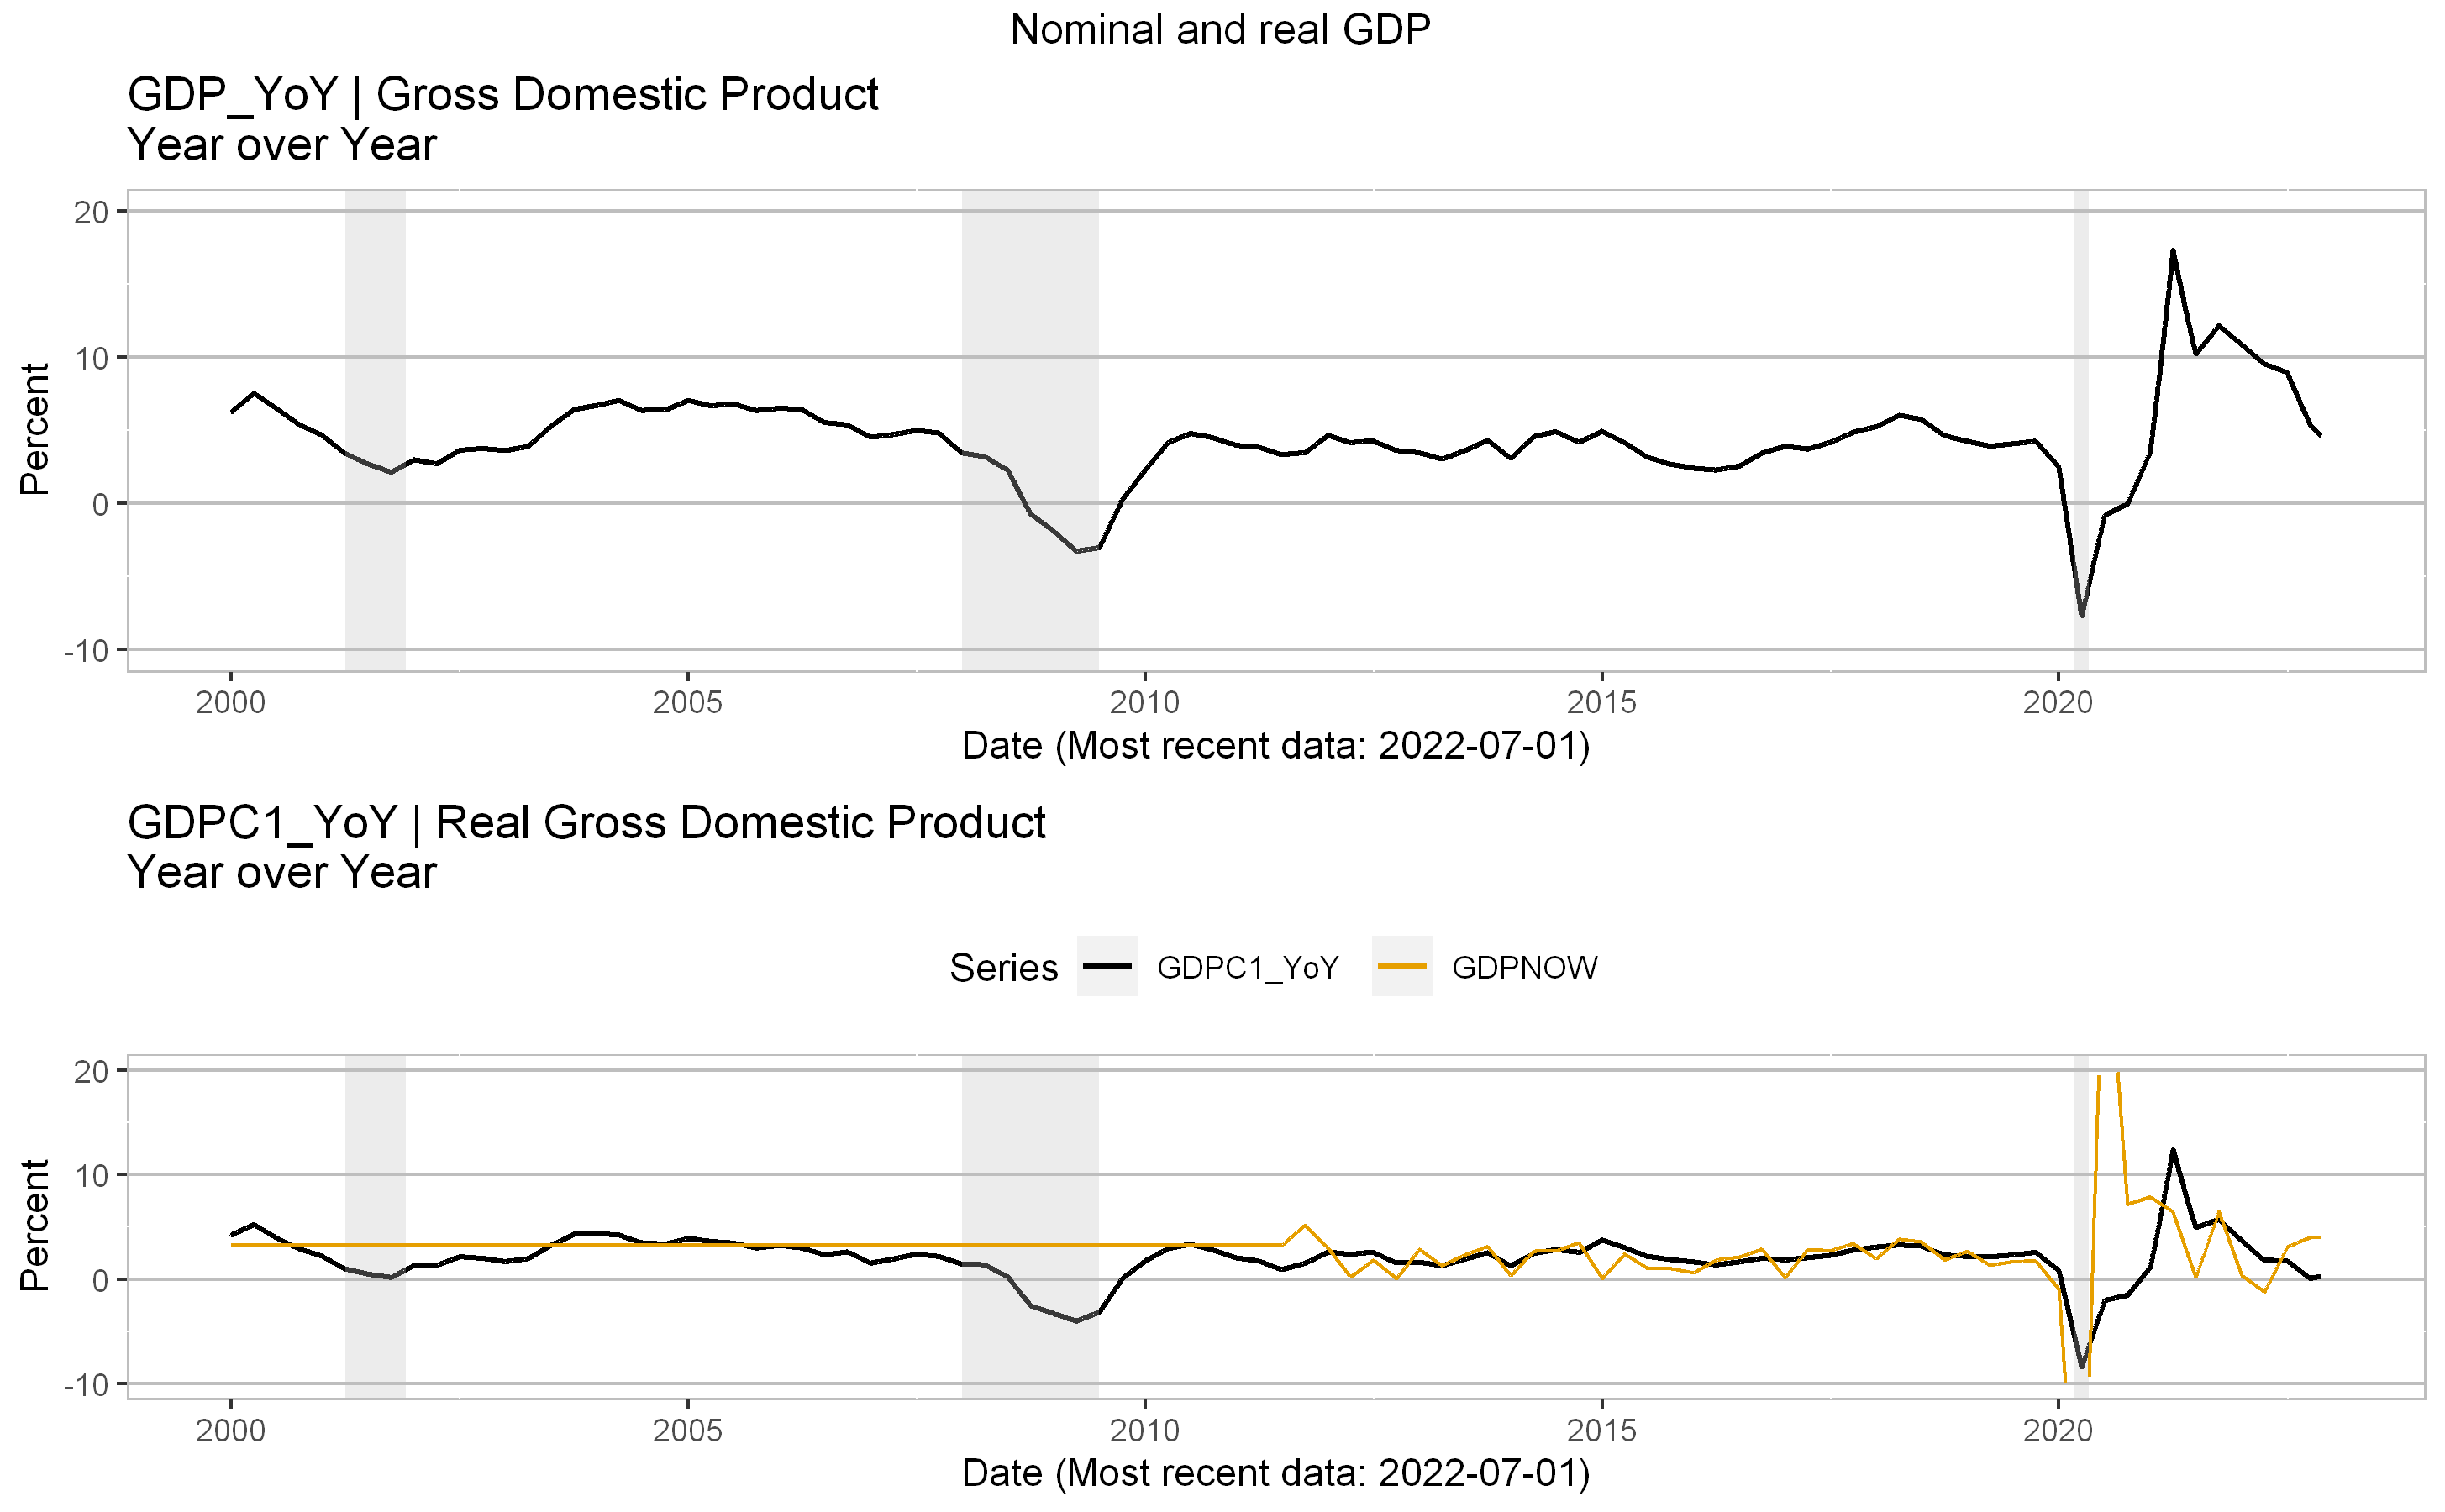

In [15]:
options(repr.plot.width = 9.7, repr.plot.height = 6, repr.plot.res = 300)

datay <- "GDP_YoY"
ylim <- c(-10, 20)
dtStart = as.Date('2000-01-01')
p1 <-
  plotSingleQuick(dfRecession, df.data, datay, ylim, dtStart, b.percentile = FALSE)


datay.1 <- "GDPC1_YoY"
datay.aux.1 <- "GDPNOW"
ylim.1 <- c(-10, 20)
p2 <- plotSingleQuick(dfRecession, df.data, datay.1, ylim.1, dtStart, b.percentile = FALSE, b.legend = TRUE)
p2 <- p2 + geom_line(
    data = df.data,
    aes_string(x = "date",
      y = datay.aux.1,
      colour = shQuote(datay.aux.1)
    ),
    na.rm = TRUE
  )

grid.arrange(p1,
             p2,
             ncol = 1,
             top = "Nominal and real GDP")

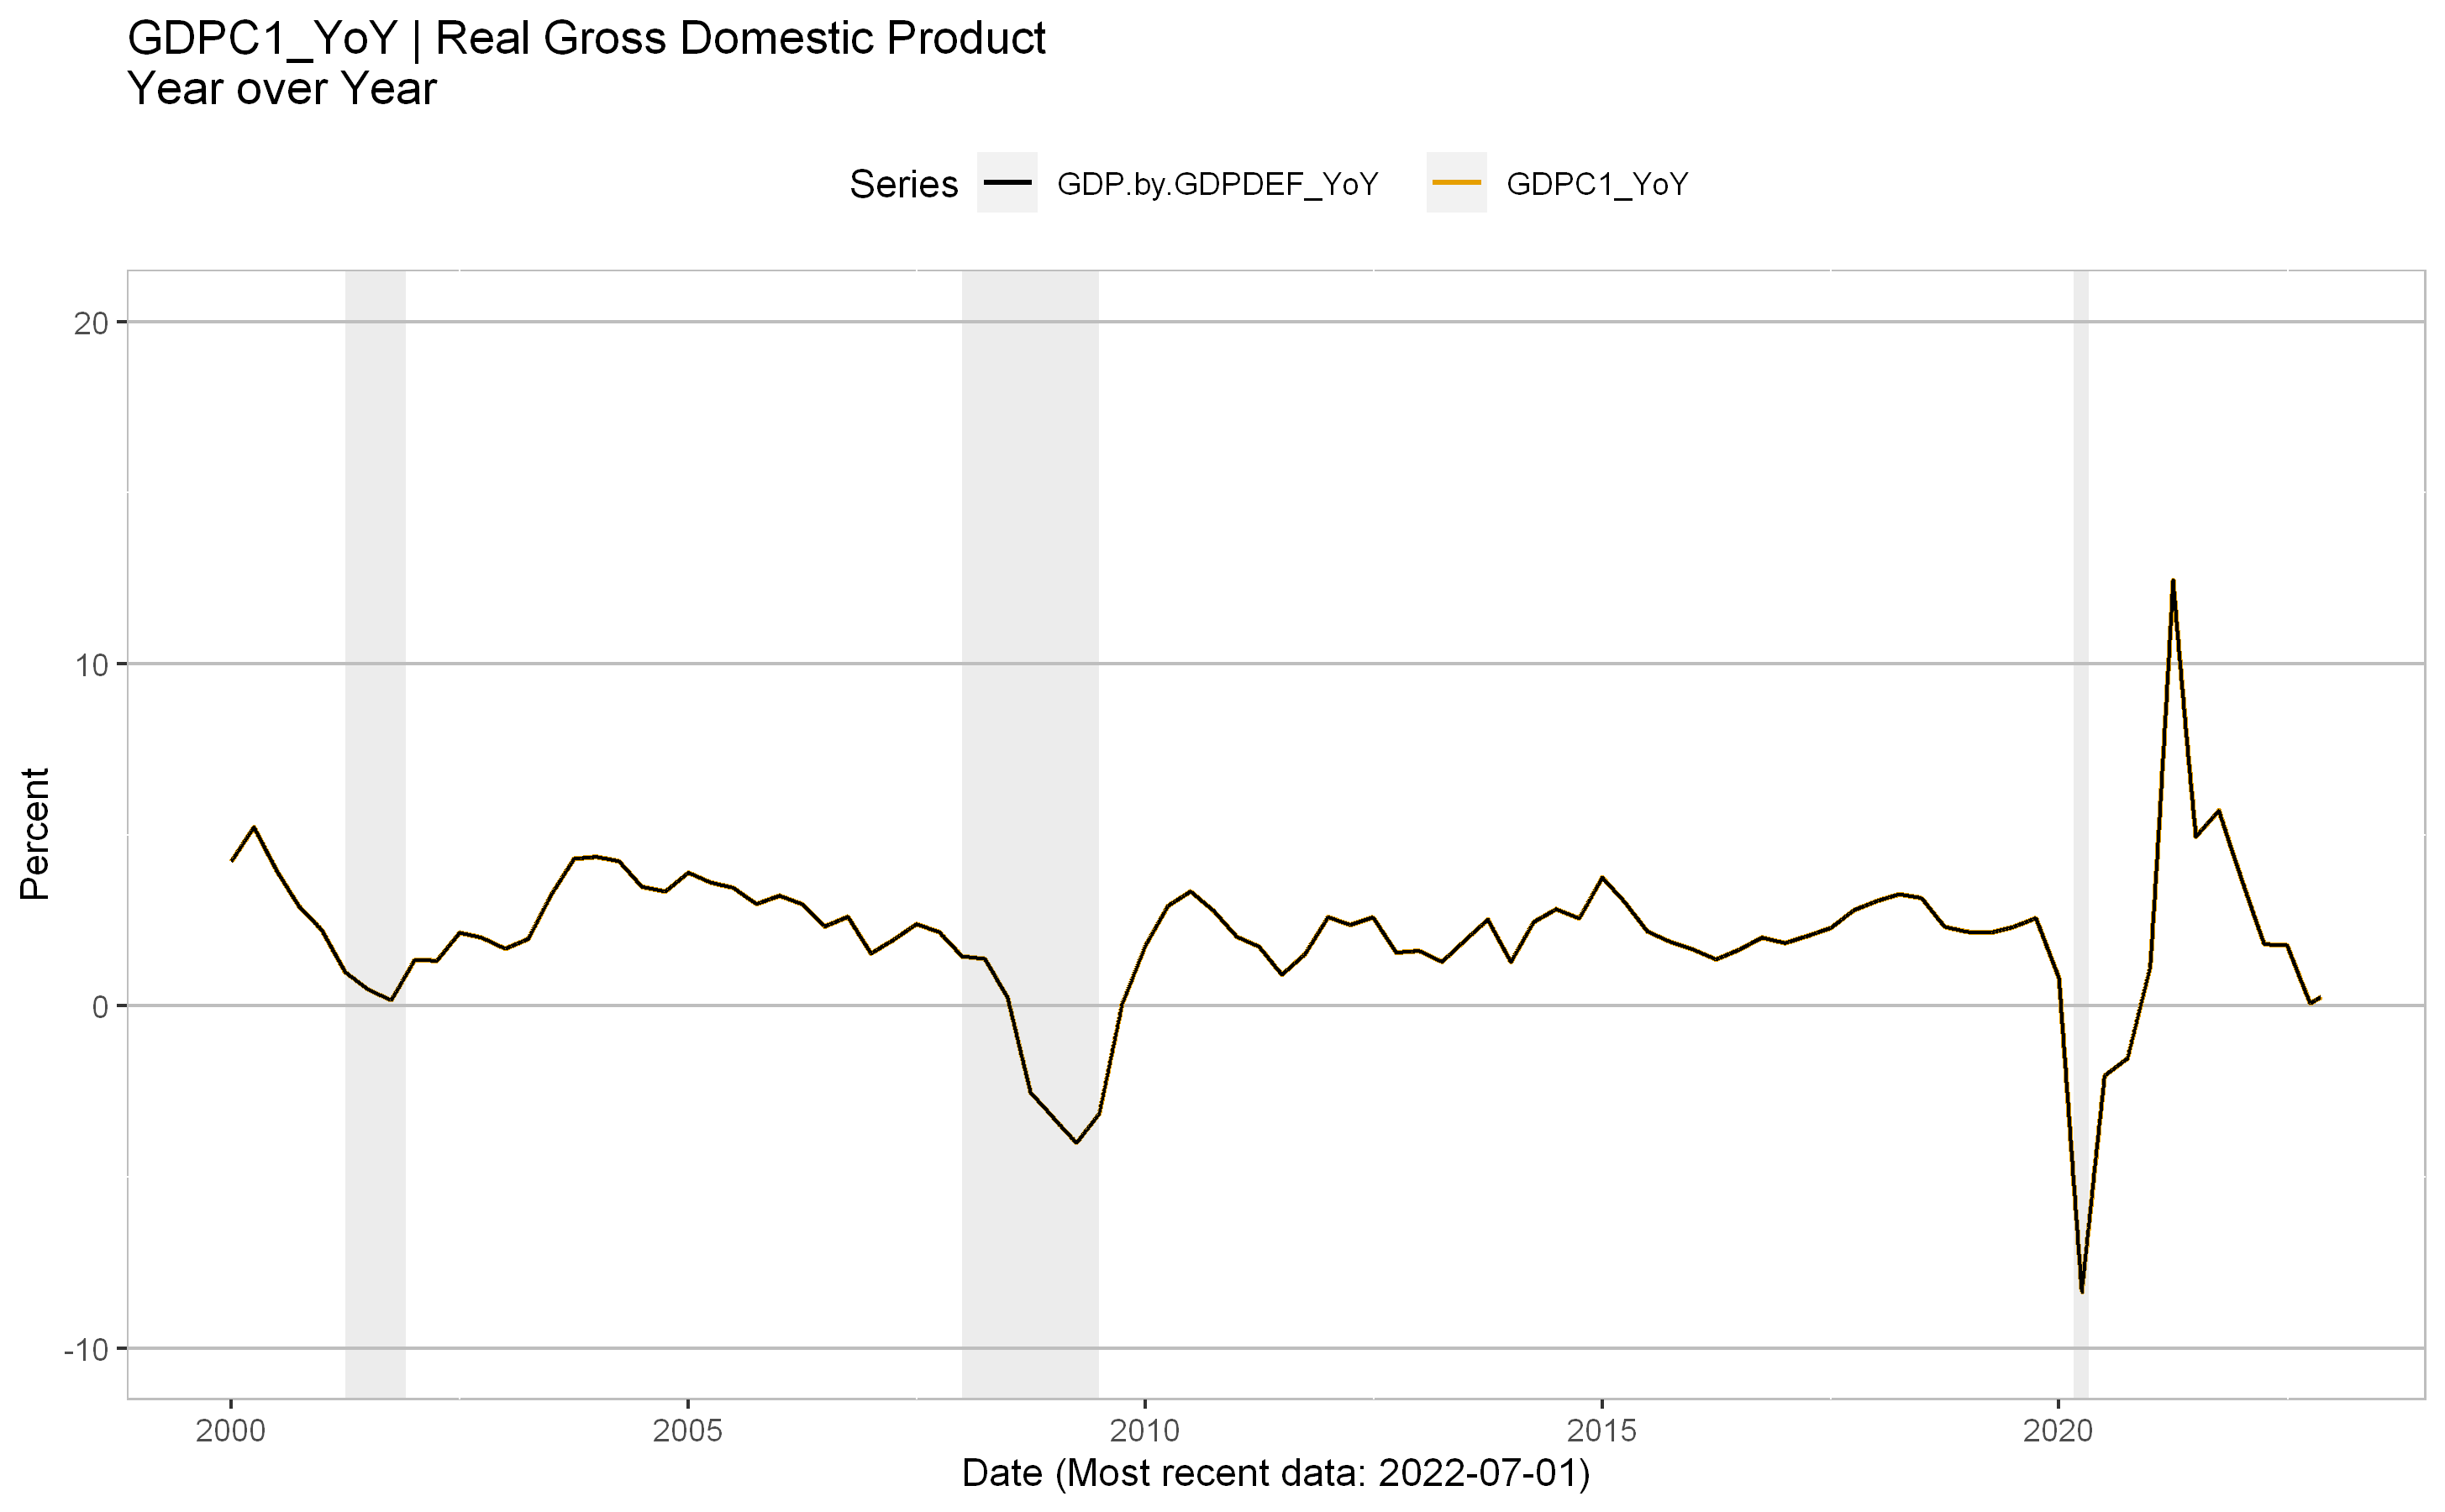

In [16]:
options(repr.plot.width = 9.7, repr.plot.height = 6, repr.plot.res = 300)

datay <- "GDPC1_YoY"
datay.aux.1 <- "GDP.by.GDPDEF_YoY"
ylim <- c(-10, 20)
dtStart = as.Date('2000-01-01')
p1 <-
  plotSingleQuick(dfRecession, df.data, datay, ylim, dtStart, b.legend <- TRUE, b.percentile = FALSE)
p1 + geom_line(
    data = df.data,
    aes_string(x = "date",
      y = datay.aux.1,
      colour = shQuote(datay.aux.1)
    ),
    na.rm = TRUE
  )

# Define training ranges and parameters

In [17]:
# Exclude the Covid19 datasets
dt.start.prediction <- as.Date(max(c(index(CLF16OV[1]), index(POPTHM[1]))))
dt.end.prediction <- as.Date("2020-01-31")

# Supporting Series Models

The underlying data series for GDP only get updated once a month and they are often delayed by weeks. I would like to synthesize a few series that could be used to get more up to date estimates. I am going to start with the PCE series since that is the largest contributer to the GDP numbers.

## PCE

### Data exploration

Truncate the data. Yahoo rarely goes past 2000

In [18]:
dt.start.prediction.pce <- as.Date("2000-01-01")
df.data.pce <- df.data[as.Date(rownames(df.data)) > dt.start.prediction.pce,]

Starting with some correlation see if we can find market data series (updated daily) that could be used to estimate PCE.

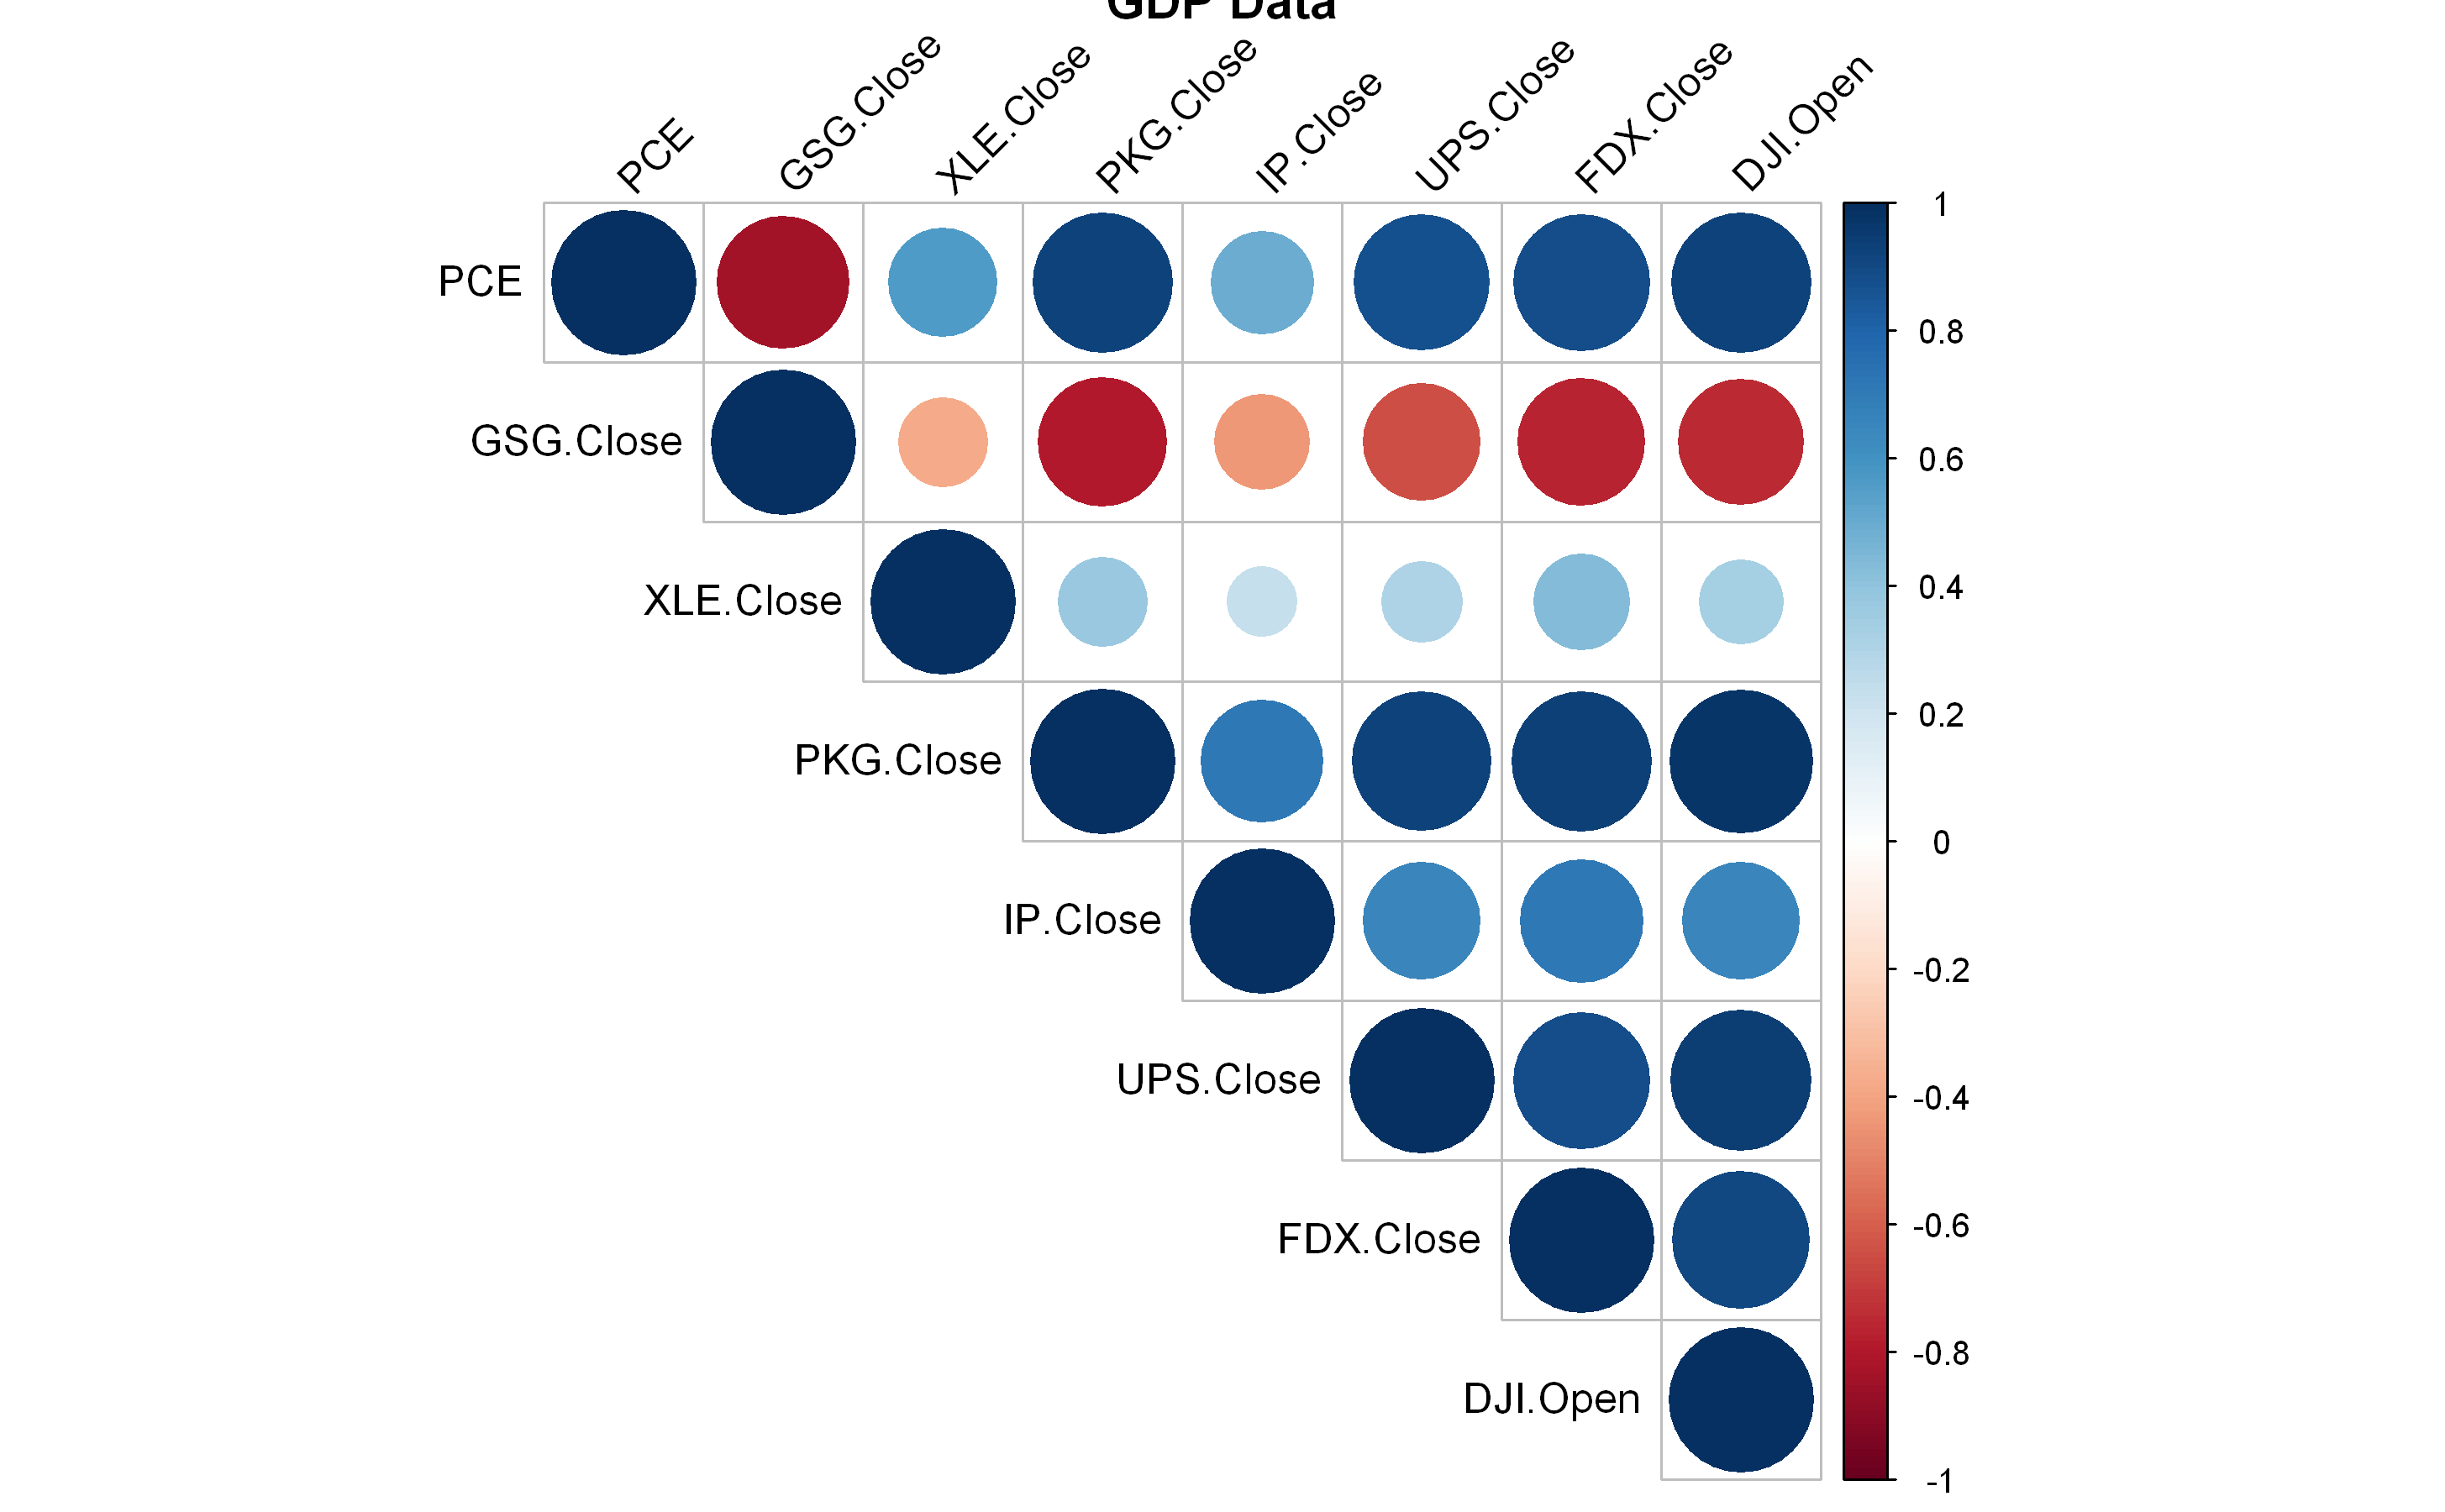

In [19]:
training.cor.pce <-
  df.data.pce[, c("PCE", "GSG.Close", "XLE.Close", "PKG.Close", "IP.Close", "UPS.Close", "FDX.Close", "DJI.Open")]

  rcorr.data <- rcorr(as.matrix(training.cor.pce), type = "pearson")
  #print(rcorr.data)

  corrplot::corrplot(cor(training.cor.pce), type="upper", order="original", 
           tl.col="black", tl.srt=45, title ="GDP Data")

### Begin training up some models for PCE

In [20]:
df.pce.model <-
  df.data[df.data$date >= dt.start.prediction.pce &
            df.data$date <= dt.end.prediction,]

# I break the data into three sets: 50% for training, 25% for testing, and 25% for validation.
set.seed(123456)
in.train <- createDataPartition(y = df.pce.model$PCE, p = 0.50, list = FALSE)
df.train <- df.pce.model[in.train,]
df.data.rest <- df.pce.model[-in.train,]
in.val <- createDataPartition(y = df.data.rest$PCE, p = 0.50, list = FALSE)
df.val <- df.data.rest[in.val,]
df.test <- df.data.rest[-in.val,]
rm(df.data.rest)

# Perform the linear fit
list.fit.reg.pce <- train(
  PCE ~ GSG.Close + PKG.Close + UPS.Close + FDX.Close,
  data = df.train,
  method = "lm",
  preProcess = c('center', 'scale')
)


# Perform the pca fit
list.fit.pcr.pce <- train(
  PCE ~ GSG.Close + PKG.Close + UPS.Close + FDX.Close + DJI.Open,
  data = df.train,
  method = "pcr",
  preProcess = c('center', 'scale')
)

# Perform the knn fit
list.fit.knn.pce <- train(
  PCE ~ GSG.Close + PKG.Close + UPS.Close + FDX.Close + DJI.Open,
  data = df.train,
  method = "knn",
  preProcess = c('center', 'scale')
)



### Adds the linear prediction to the data frame

In [21]:
# Add linear prediction to the dataframe
str.symbol <- "PCE.lm"
df.data[str.symbol] <-
  predict(list.fit.reg.pce, newdata = df.data)

In [22]:
str.description <- "Linear Model Prediction\nPCE given GSG,\nPKG, UPS, and FDX"
df.symbols <-
  rbind(
    df.symbols,
    data.frame(
      string.symbol = str.symbol,
      string.source = "Predict",
      string.description = str.description,
      string.label.y = getPlotYLabel(df.symbols, "POPTHM")[1],
      float.expense.ratio = -1.00,
      Max030 = FALSE,
      Max180 = FALSE,
      date.series.start = dt.start.prediction,
      date.series.end = as.Date(Sys.Date())
    )
  )

str.description <- "Linear Model Prediction\nPCE given GSG,\nPKG, UPS, and FDX"
df.symbols <-
  rbind(
    df.symbols,
    data.frame(
      string.symbol = str.symbol,
      string.source = "Predict",
      string.description = str.description,
      string.label.y = getPlotYLabel(df.symbols, "POPTHM")[1],
      float.expense.ratio = -1.00,
      Max030 = FALSE,
      Max180 = FALSE,
      date.series.start = dt.start.prediction,
      date.series.end = as.Date(Sys.Date())
    )
  )

Add the linear prediction year-over-year growth

In [23]:
# The YoY calculation for the linear model
str.symbolYoY <- paste(str.symbol, "_YoY", sep = "")
df.data[str.symbolYoY] <- CalcYoY(df.data, str.symbol, 365)

df.symbols <-
  rbind(
    df.symbols,
    data.frame(
      string.symbol = str.symbolYoY,
      string.source = "Calc",
      string.description = paste(str.description, "\nYear over Year", sep =
                                   ""),
      string.label.y = "Percent",
      float.expense.ratio = -1.00,
      Max030 = FALSE,
      Max180 = FALSE,
      date.series.start = dt.start.prediction,
      date.series.end = as.Date(Sys.Date())
    )
  )

### Add linear prediction by PCA to the dataframe

In [24]:
str.symbol.pcr <- "PCE.pcr"
df.data[str.symbol.pcr] <-
  predict(list.fit.pcr.pce, newdata = df.data, ncomp = 1)

In [25]:
list.fit.pcr.pce

Principal Component Analysis 

3668 samples
   5 predictor

Pre-processing: centered (5), scaled (5) 
Resampling: Bootstrapped (25 reps) 
Summary of sample sizes: 3668, 3668, 3668, 3668, 3668, 3668, ... 
Resampling results across tuning parameters:

  ncomp  RMSE      Rsquared   MAE     
  1      865.0032  0.8507792  736.8788
  2      795.1645  0.8739076  639.4456
  3      795.1652  0.8739057  638.6103

RMSE was used to select the optimal model using the smallest value.
The final value used for the model was ncomp = 2.

In [26]:
# Add the linear model prediction to the symbols table
str.description.pcr <- "PCE Regression Prediction\nPCE given GSG,\nPKG, UPS, and FDX"
df.symbols <-
  rbind(
    df.symbols,
    data.frame(
      string.symbol = str.symbol.pcr,
      string.source = "Predict",
      string.description = str.description.pcr,
      string.label.y = getPlotYLabel(df.symbols, "PCE")[1],
      float.expense.ratio = -1.00,
      Max030 = FALSE,
      Max180 = FALSE,
      date.series.start = dt.start.prediction,
      date.series.end = as.Date(Sys.Date())
    )
  )

### Add KNN prediction to the dataframe

In [27]:
str.symbol.pcr <- "PCE.knn"
df.data[str.symbol.pcr] <-
  predict(list.fit.pcr.pce, newdata = df.data, ncomp = 1)

In [28]:
list.fit.knn.pce

k-Nearest Neighbors 

3668 samples
   5 predictor

Pre-processing: centered (5), scaled (5) 
Resampling: Bootstrapped (25 reps) 
Summary of sample sizes: 3668, 3668, 3668, 3668, 3668, 3668, ... 
Resampling results across tuning parameters:

  k  RMSE      Rsquared   MAE     
  5  43.83709  0.9996052  17.22146
  7  50.09257  0.9994770  20.01759
  9  57.00298  0.9993164  22.72586

RMSE was used to select the optimal model using the smallest value.
The final value used for the model was k = 5.

In [29]:
# Add the linear model prediction to the symbols table
str.description.pcr <- "KNN Prediction\nPCE given GSG,\nPKG, UPS, and FDX"
df.symbols <-
  rbind(
    df.symbols,
    data.frame(
      string.symbol = str.symbol.pcr,
      string.source = "Predict",
      string.description = str.description.pcr,
      string.label.y = getPlotYLabel(df.symbols, "PCE")[1],
      float.expense.ratio = -1.00,
      Max030 = FALSE,
      Max180 = FALSE,
      date.series.start = dt.start.prediction,
      date.series.end = as.Date(Sys.Date())
    )
  )

Add the PCA prediction year-over-year growth

In [30]:
# The YoY calculation
str.symbolYoY <- paste(str.symbol.pcr, "_YoY", sep = "")
df.data[str.symbolYoY] <- CalcYoY(df.data, str.symbol.pcr, 365)

df.symbols <-
  rbind(
    df.symbols,
    data.frame(
      string.symbol = str.symbolYoY,
      string.source = "Calc",
      string.description = paste(str.description.pcr, "\nYear over Year", sep =
                                   ""),
      string.label.y = "Percent",
      float.expense.ratio = -1.00,
      Max030 = FALSE,
      Max180 = FALSE,
      date.series.start = dt.start.prediction,
      date.series.end = as.Date(Sys.Date())
    )
  )

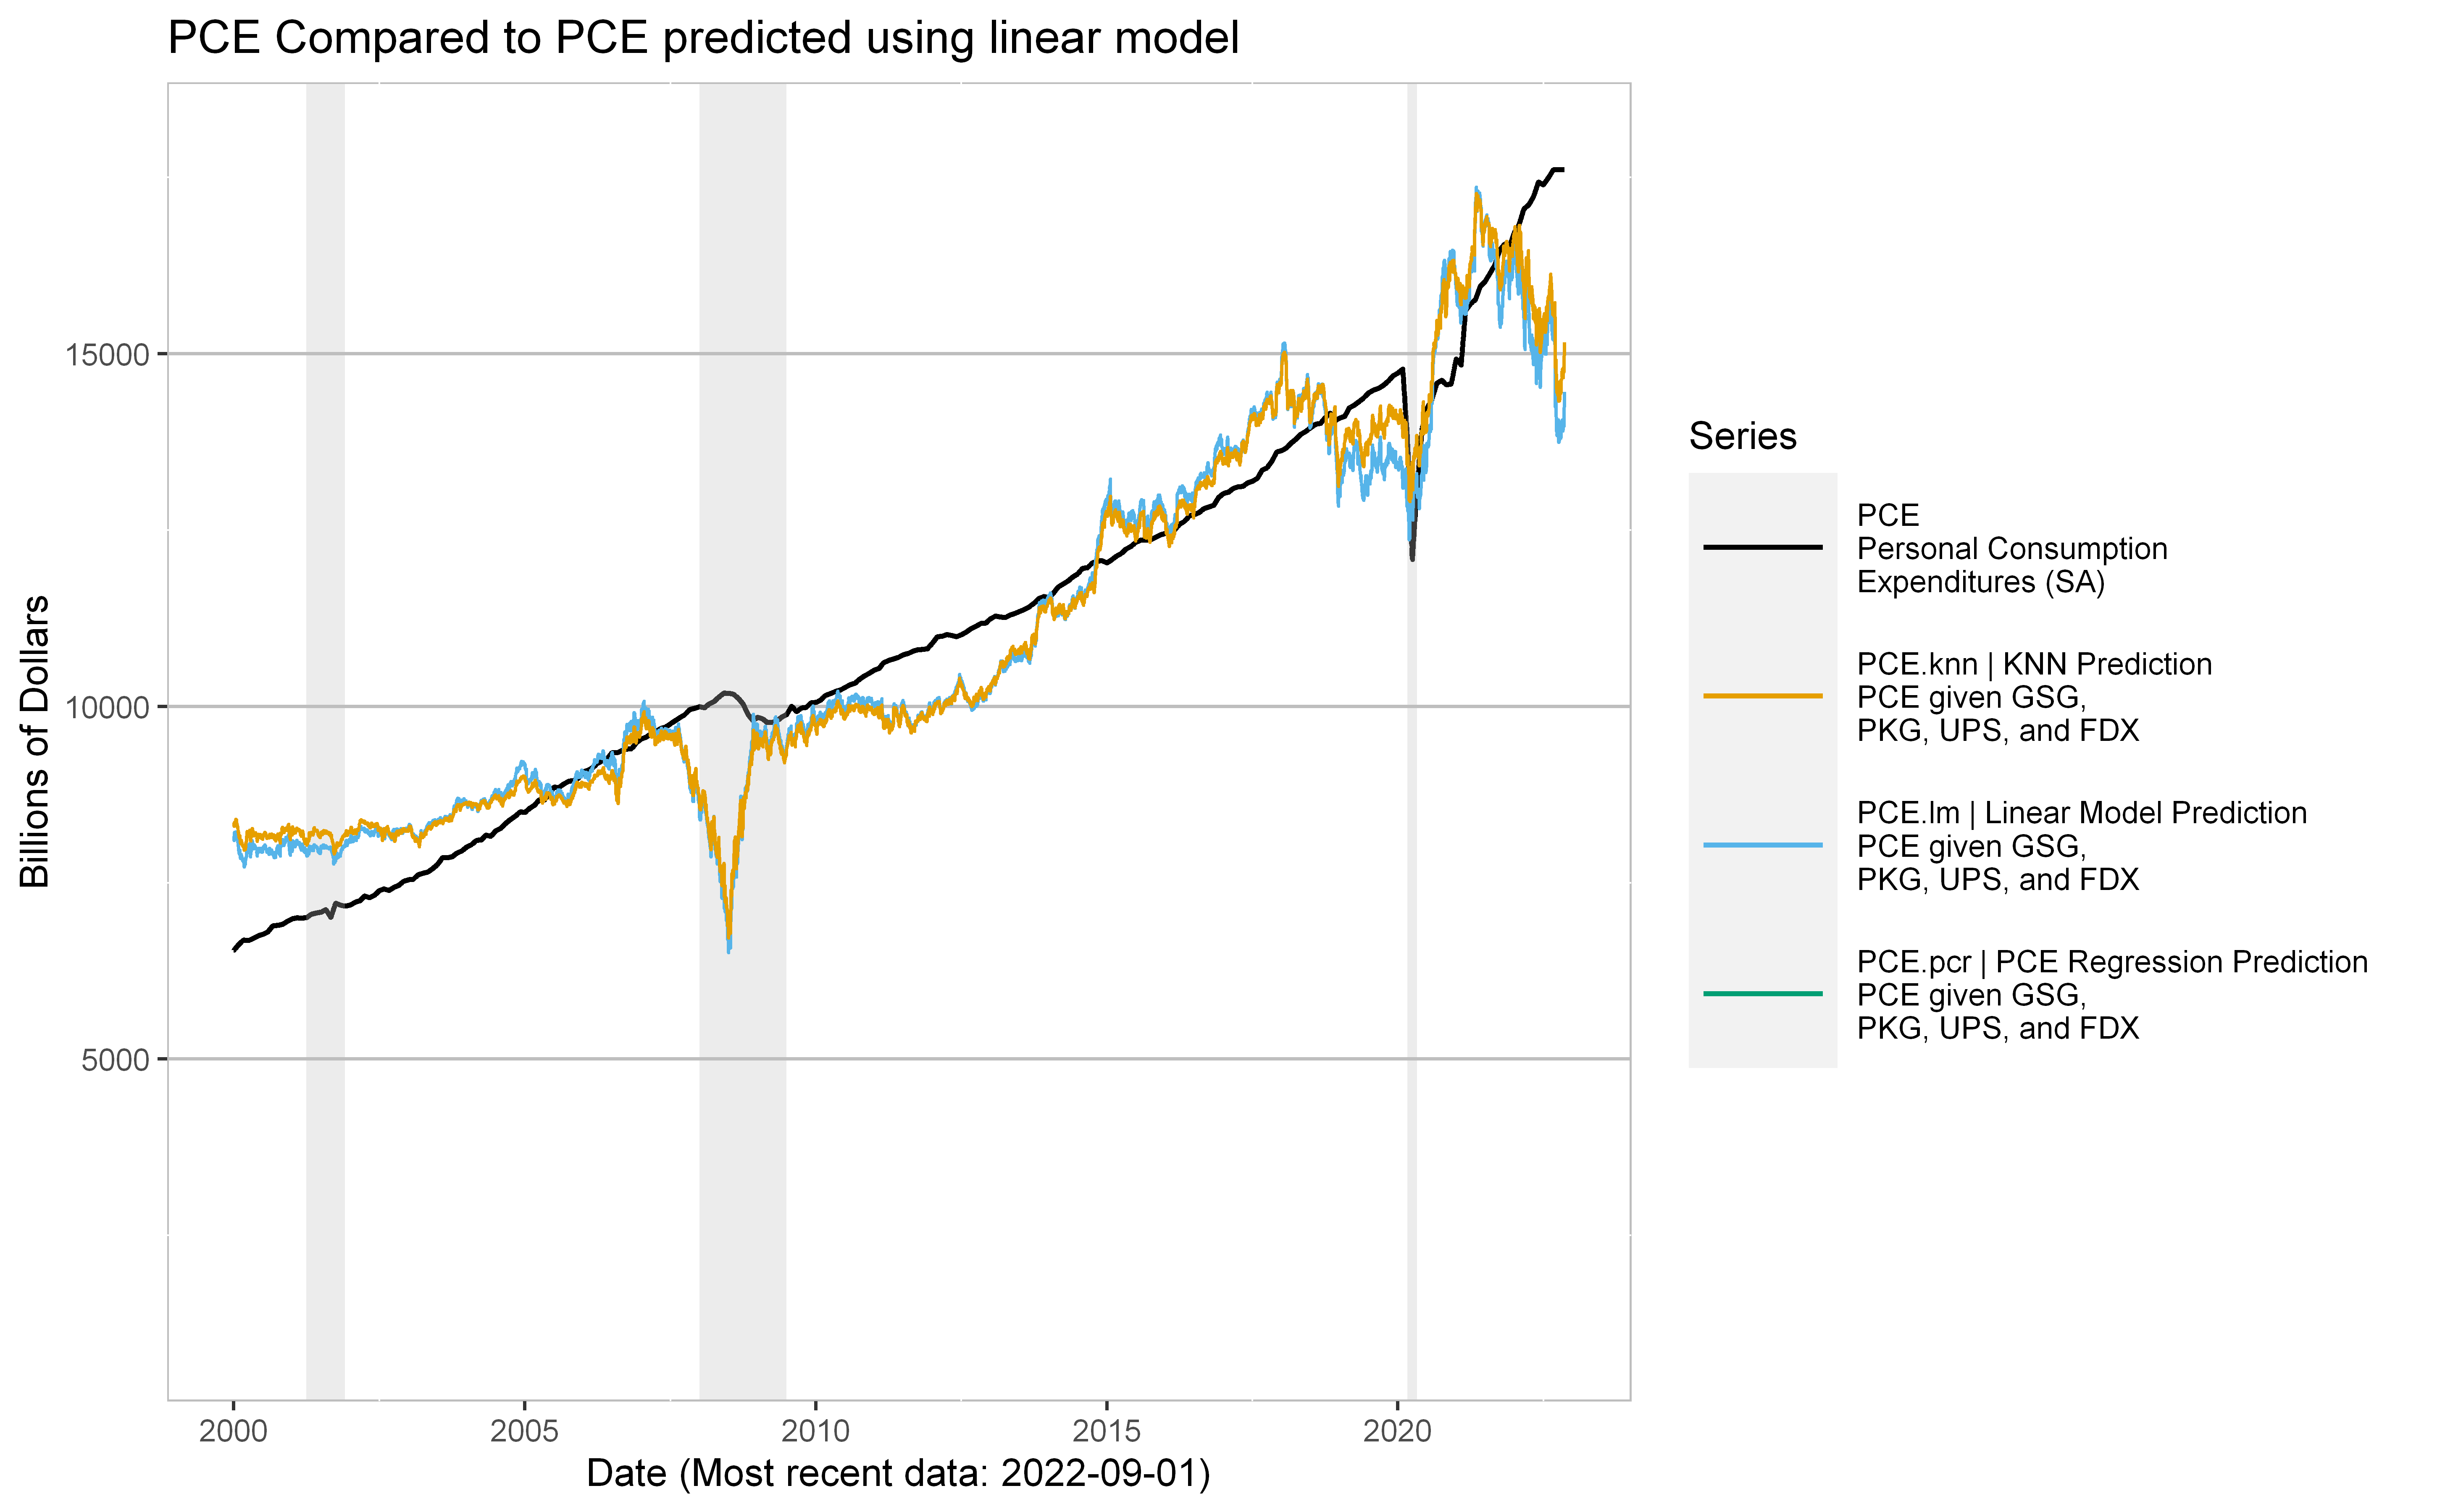

In [35]:
options(repr.plot.width = 9.7, repr.plot.height = 6, repr.plot.res = 600)
datay <- "PCE"
datay.aux <- "PCE.lm"
datay.aux.1 <- "PCE.pcr"
datay.aux.2 <- "PCE.knn"
ylim <- c(1000, 18000)
dt.end <- Sys.Date()
myPlot <- 
  plotSingle(
    dfRecession,
    df.data,
    "date",
    datay,
    "PCE Compared to PCE predicted using linear model",
    "Date",
    getPlotYLabel(df.symbols, datay),
    c(dt.start.prediction.pce, dt.end),
    ylim,
    b.legend = TRUE,
    b.percentile = FALSE,
    b.long.legend = TRUE
  )
myPlot <- myPlot + geom_line(
  data = df.data,
  aes_string(
    x = "date",
    y = datay.aux,
    colour = shQuote(getPlotTitle(df.symbols, datay.aux)[[1]])
  ),
  na.rm = TRUE
)
myPlot <- myPlot + geom_line(
  data = df.data,
  aes_string(
    x = "date",
    y = datay.aux.1,
    colour = shQuote(getPlotTitle(df.symbols, datay.aux.1))
  ),
  na.rm = TRUE
)
myPlot <- myPlot + geom_line(
  data = df.data,
  aes_string(
    x = "date",
    y = datay.aux.2,
    colour = shQuote(getPlotTitle(df.symbols, datay.aux.2))
  ),
  na.rm = TRUE
)


print(myPlot)

## GDP Models

### Regression, Retail sales

See if we can get there with a simple regression model. Begin by taking a look at how these datapoints correlate


Correlation for series thought to be used by BEA to generate GDP numbers

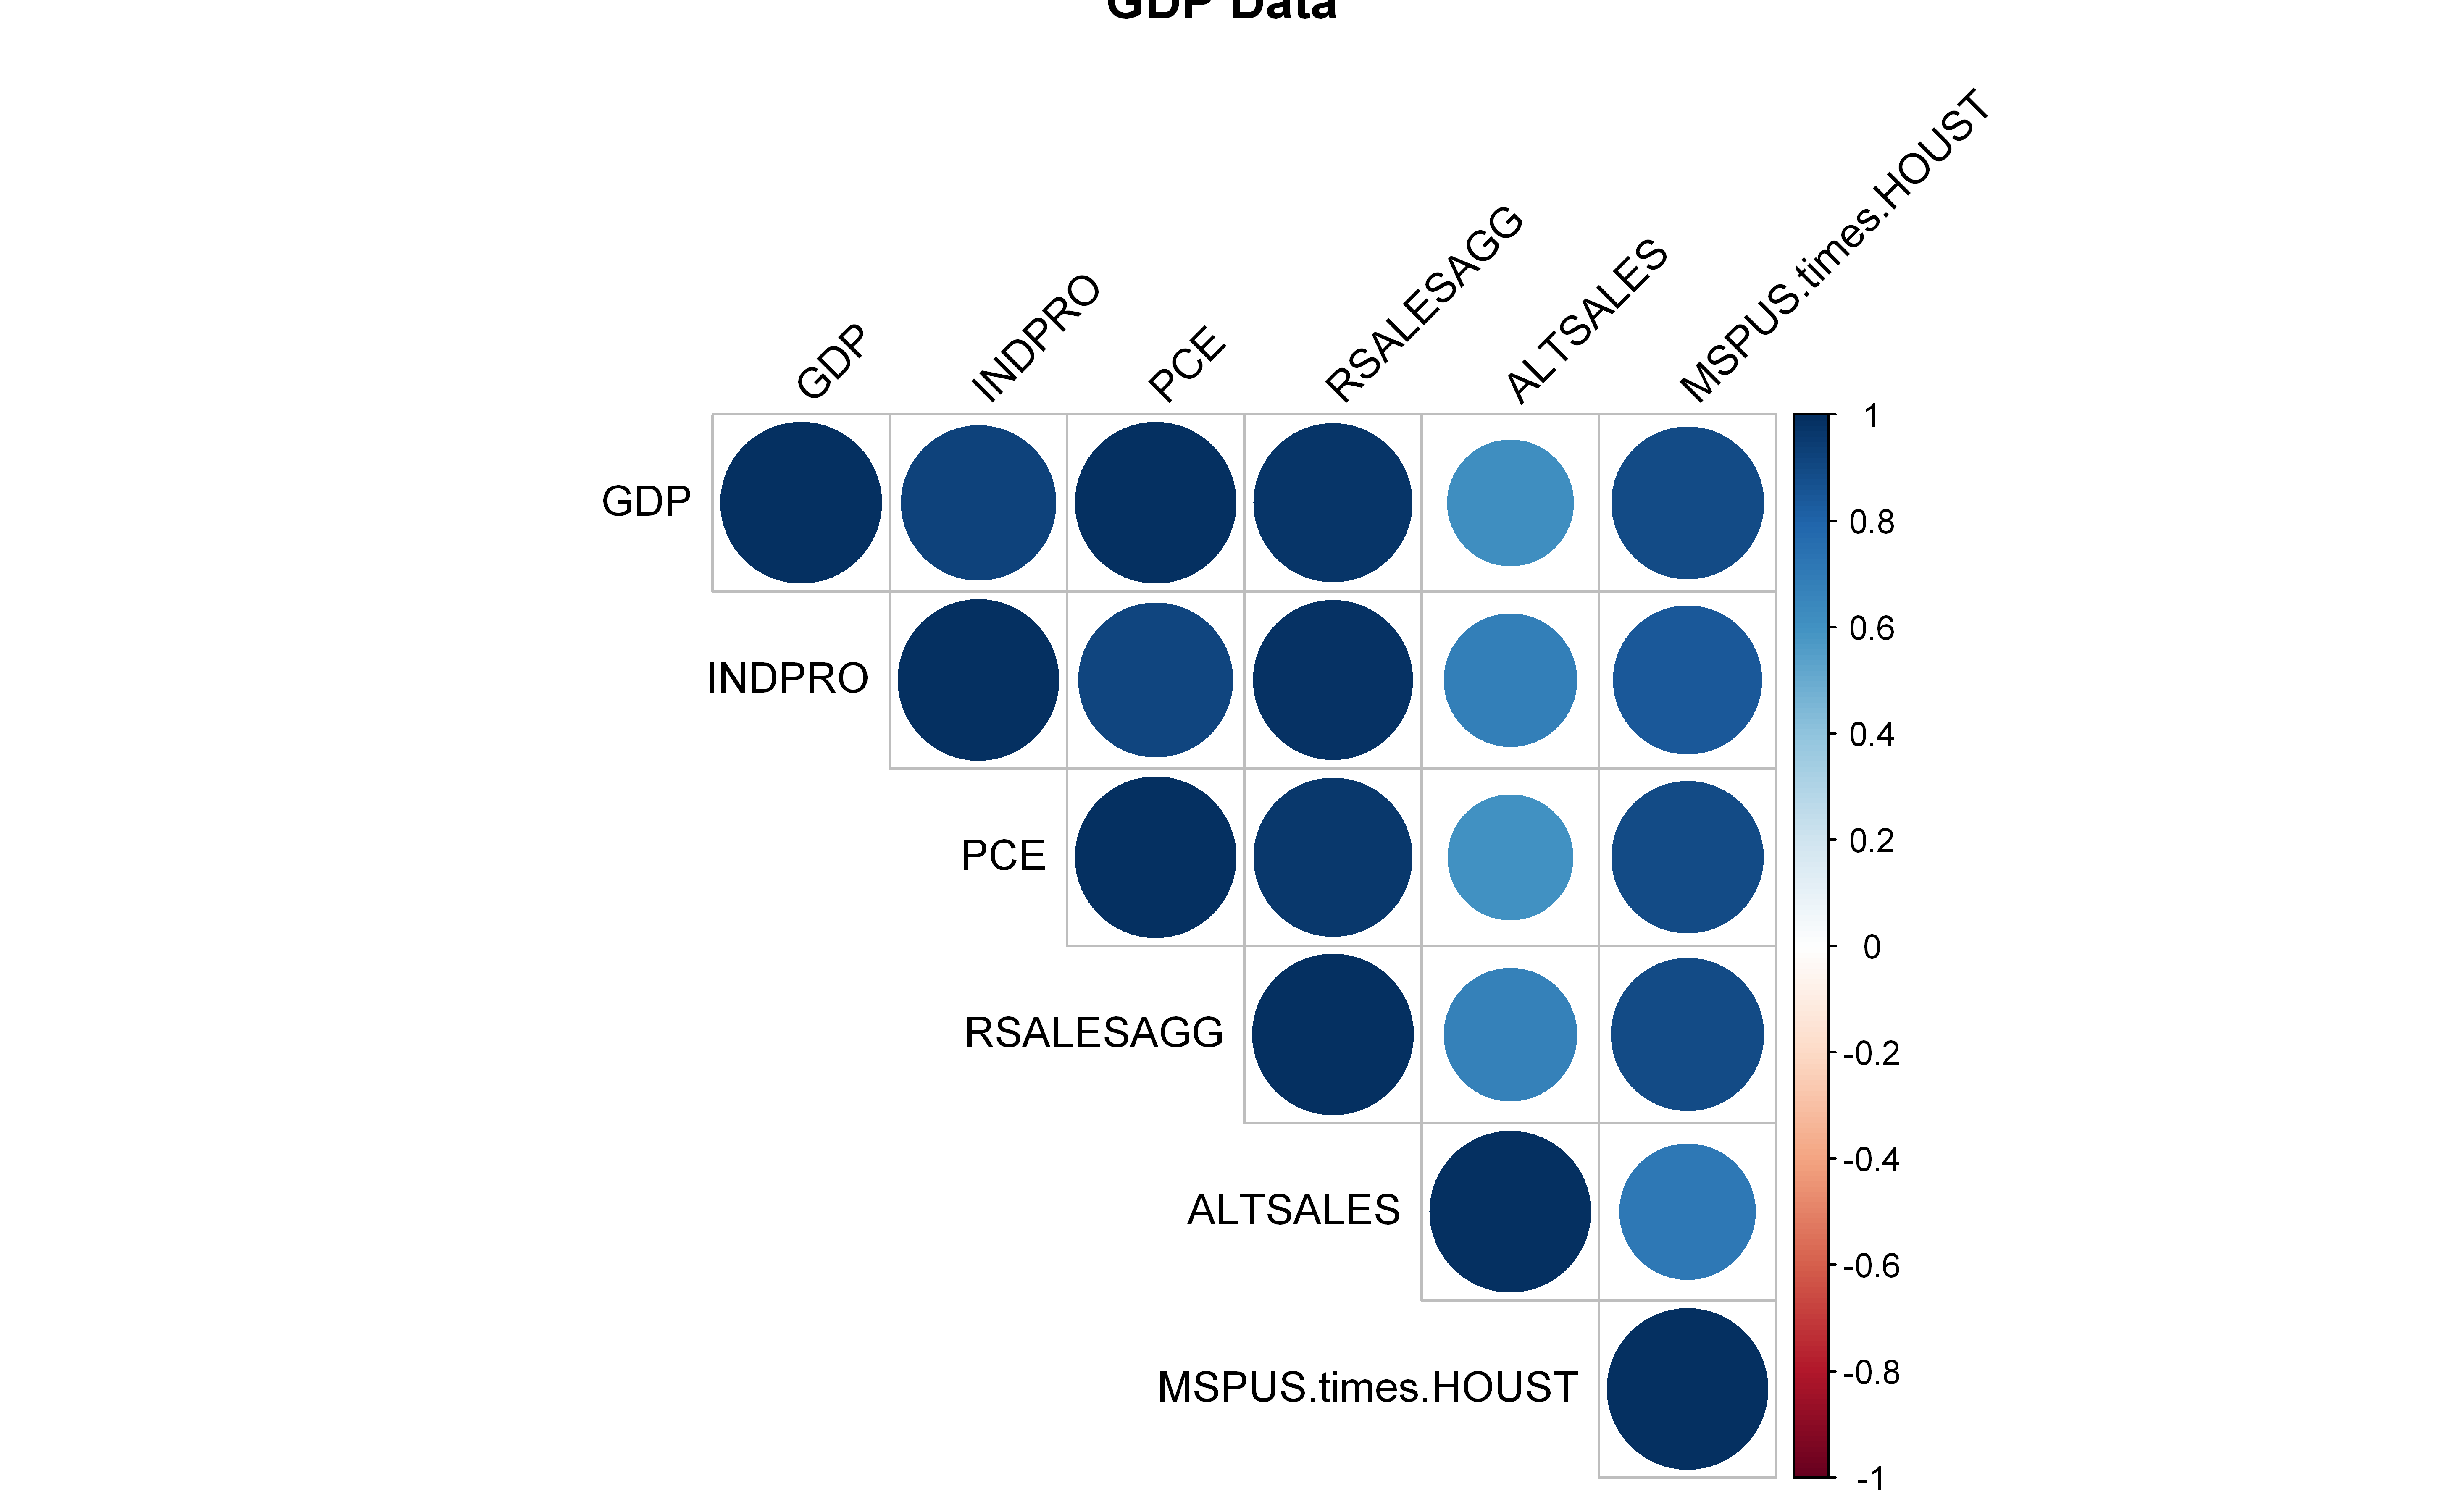

In [36]:
training.cor <-
  df.data[, c("GDP", "INDPRO", "PCE", "RSALESAGG", "ALTSALES", "MSPUS.times.HOUST")]

  rcorr.data <- rcorr(as.matrix(training.cor), type = "pearson")
  #print(rcorr.data)

  corrplot::corrplot(cor(training.cor), type="upper", order="original", 
           tl.col="black", tl.srt=45, title ="GDP Data")

### Begin training up some models for GDP

In [37]:
df.gdp.model <-
  df.data[df.data$date >= dt.start.prediction &
            df.data$date <= dt.end.prediction,]

# I break the data into three sets: 50% for training, 25% for testing, and 25% for validation.
set.seed(123456)
in.train <- createDataPartition(y=df.gdp.model$GDP, p = 0.50, list=FALSE)
df.train <- df.gdp.model[in.train,]
df.data.rest <- df.gdp.model[-in.train,]
in.val <- createDataPartition(y = df.data.rest$GDP, p = 0.50, list = FALSE)
df.val <- df.data.rest[in.val,]
df.test <- df.data.rest[-in.val,]
rm(df.data.rest)

# Perform the linear fit
list.fit.reg <- train(
  GDP ~ INDPRO + PCE + RSALESAGG + ALTSALES + MSPUS.times.HOUST,
  data = df.train,
  method = "lm",
  preProcess = c('center', 'scale')
)


# Perform the pca fit
list.fit.pcr <- train(
  GDP ~ INDPRO + PCE + RSALESAGG + ALTSALES + MSPUS.times.HOUST,
  data = df.train,
  method = "pcr",
  preProcess = c('center', 'scale')
)


### Adds the linear prediction to the data frame

In [38]:
# Add linear prediction to the dataframe
str.symbol <- "GDP.lm"
df.data[str.symbol] <-
  predict(list.fit.reg, newdata = df.data)

# Add the linear model prediction to the symbols table
str.description <- "Linear Model Prediction\nGDP given INDPRO,\nPCE, RSALESAGG, ALTSALES,\nand housing"
df.symbols <-
  rbind(
    df.symbols,
    data.frame(
      string.symbol = str.symbol,
      string.source = "Predict",
      string.description = str.description,
      string.label.y = getPlotYLabel(df.symbols, "POPTHM")[1],
      float.expense.ratio = -1.00,
      Max030 = FALSE,
      Max180 = FALSE,
      date.series.start = dt.start.prediction,
      date.series.end = as.Date(Sys.Date())
    )
  )


# Normalize linear model GDP commodities by GDP deflator
df.data$GDP.lm.by.GDPDEF <-
  (df.data$GDP.lm / df.data$GDPDEF)
df.symbols <-
  rbind(
    df.symbols,
    data.frame(
      string.symbol = "GDP.lm.by.GDPDEF",
      string.source = "Calc",
      string.description = "Linear Model Est. GDP \nNormalized by GDP def",
      string.label.y = "(-)",
      float.expense.ratio = -1.00,
      Max030 = FALSE,
      Max180 = FALSE,
      date.series.start =  as.Date(max(c(
        index(GDP[1]), index(GDPDEF[1])
      ))) ,
      date.series.end = as.Date(min(c(
        index(tail(GDP, 1)), index(tail(GDPDEF, 1))
      )))
    )
  )

Add the nominal linear prediction year-over-year growth

In [39]:
str.symbolYoY <- paste(str.symbol, "_YoY", sep = "")
df.data[str.symbolYoY] <- CalcYoY(df.data, str.symbol, 365)

df.symbols <-
  rbind(
    df.symbols,
    data.frame(
      string.symbol = str.symbolYoY,
      string.source = "Calc",
      string.description = paste(str.description, "\nYear over Year", sep =
                                   ""),
      string.label.y = "Percent",
      float.expense.ratio = -1.00,
      Max030 = FALSE,
      Max180 = FALSE,
      date.series.start = dt.start.prediction,
      date.series.end = as.Date(Sys.Date())
    )
  )

Add the real linear prediction (nominal/deflator) year-over-year growth

In [40]:
str.symbol <- "GDP.lm.by.GDPDEF"
str.symbolYoY <- paste(str.symbol, "_YoY", sep = "")
df.data[str.symbolYoY] <- CalcYoY(df.data, str.symbol, 365)

df.symbols <-
  rbind(
    df.symbols,
    data.frame(
      string.symbol = str.symbolYoY,
      string.source = "Calc",
      string.description = paste(str.description, "\nYear over Year", sep =
                                   ""),
      string.label.y = "Percent",
      float.expense.ratio = -1.00,
      Max030 = FALSE,
      Max180 = FALSE,
      date.series.start = dt.start.prediction,
      date.series.end = as.Date(Sys.Date())
    )
  )

### Add linear prediction by PCA to the dataframe

In [41]:
str.symbol.pcr <- "GDP.pcr"
df.data[str.symbol.pcr] <-
  predict(list.fit.pcr, newdata = df.data, ncomp = 1)

In [42]:
list.fit.pcr

Principal Component Analysis 

11156 samples
    5 predictor

Pre-processing: centered (5), scaled (5) 
Resampling: Bootstrapped (25 reps) 
Summary of sample sizes: 11156, 11156, 11156, 11156, 11156, 11156, ... 
Resampling results across tuning parameters:

  ncomp  RMSE       Rsquared   MAE      
  1      2025.7183  0.8970301  1548.7072
  2      1050.5486  0.9723152   818.9892
  3       929.0834  0.9783476   694.6747

RMSE was used to select the optimal model using the smallest value.
The final value used for the model was ncomp = 3.

In [43]:
# Add the linear model prediction to the symbols table
str.description.pcr <- "PCA regression\nGDP given INDPRO,\nPCE, RSALESAGG, ALTSALES,\nand housing"  
df.symbols <-
  rbind(
    df.symbols,
    data.frame(
      string.symbol = str.symbol.pcr,
      string.source = "Predict",
      string.description = str.description.pcr,
      string.label.y = getPlotYLabel(df.symbols, "POPTHM")[1],
      float.expense.ratio = -1.00,
      Max030 = FALSE,
      Max180 = FALSE,
      date.series.start = dt.start.prediction,
      date.series.end = as.Date(Sys.Date())
    )
  )

Add the PCA prediction year-over-year growth

In [44]:
# The YoY calculation for PCA
str.symbolYoY <- paste(str.symbol.pcr, "_YoY", sep = "")
df.data[str.symbolYoY] <- CalcYoY(df.data, str.symbol.pcr, 365)

df.symbols <-
  rbind(
    df.symbols,
    data.frame(
      string.symbol = str.symbolYoY,
      string.source = "Calc",
      string.description = paste(str.description.pcr, "\nYear over Year", sep =
                                   ""),
      string.label.y = "Percent",
      float.expense.ratio = -1.00,
      Max030 = FALSE,
      Max180 = FALSE,
      date.series.start = dt.start.prediction,
      date.series.end = as.Date(Sys.Date())
    )
  )

Plot the predicted and actual values

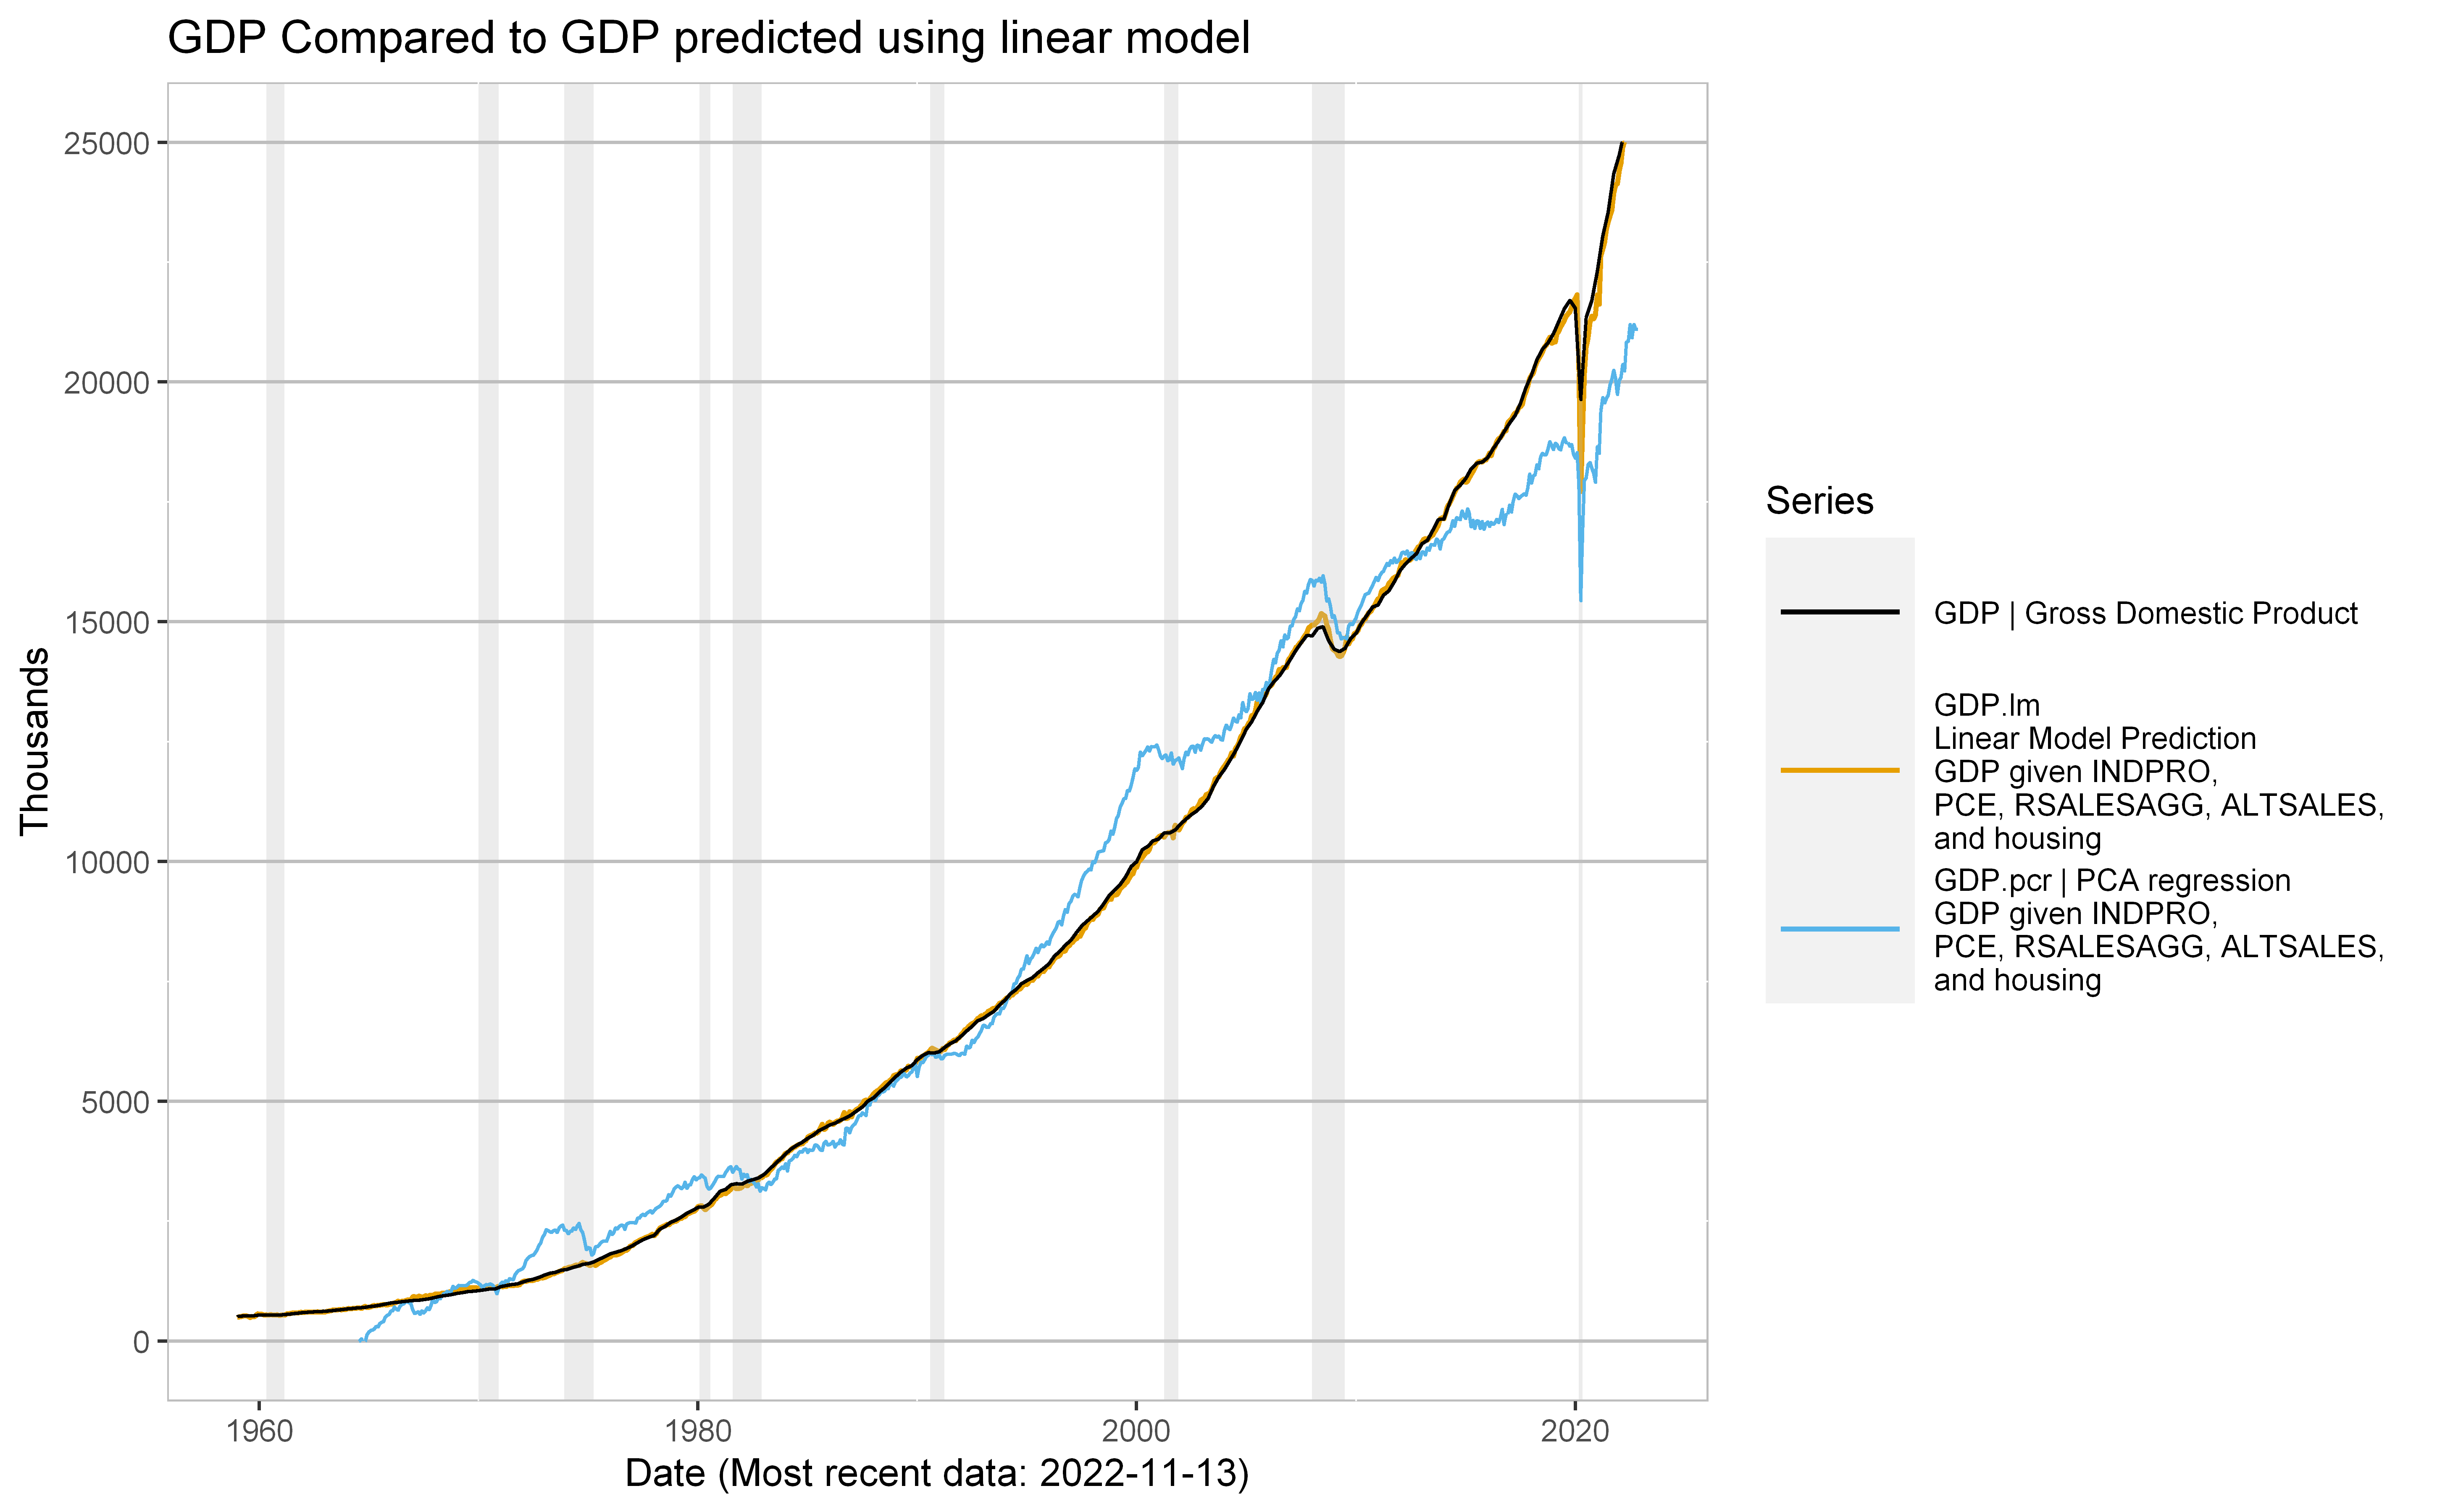

In [45]:
options(repr.plot.width = 9.7, repr.plot.height = 6, repr.plot.res = 600)
datay <- "GDP.lm"
datay.aux <- "GDP.pcr"
datay.aux.1 <- "GDP"
ylim <- c(0, 25000)
dt.end <- Sys.Date()
myPlot <- 
  plotSingle(
    dfRecession,
    df.data,
    "date",
    datay,
    "GDP Compared to GDP predicted using linear model",
    "Date",
    getPlotYLabel(df.symbols, datay),
    c(dt.start.prediction, dt.end),
    ylim,
    b.legend = TRUE,
    b.percentile = FALSE,
    b.long.legend = TRUE
  )
myPlot <- myPlot + geom_line(
  data = df.data,
  aes_string(
    x = "date",
    y = datay.aux,
    colour = shQuote(getPlotTitle(df.symbols, datay.aux))
  ),
  na.rm = TRUE
)
myPlot <- myPlot + geom_line(
  data = df.data,
  aes_string(
    x = "date",
    y = datay.aux.1,
    colour = shQuote(getPlotTitle(df.symbols, datay.aux.1))
  ),
  na.rm = TRUE
)

print(myPlot)

Looking at some more recent data points

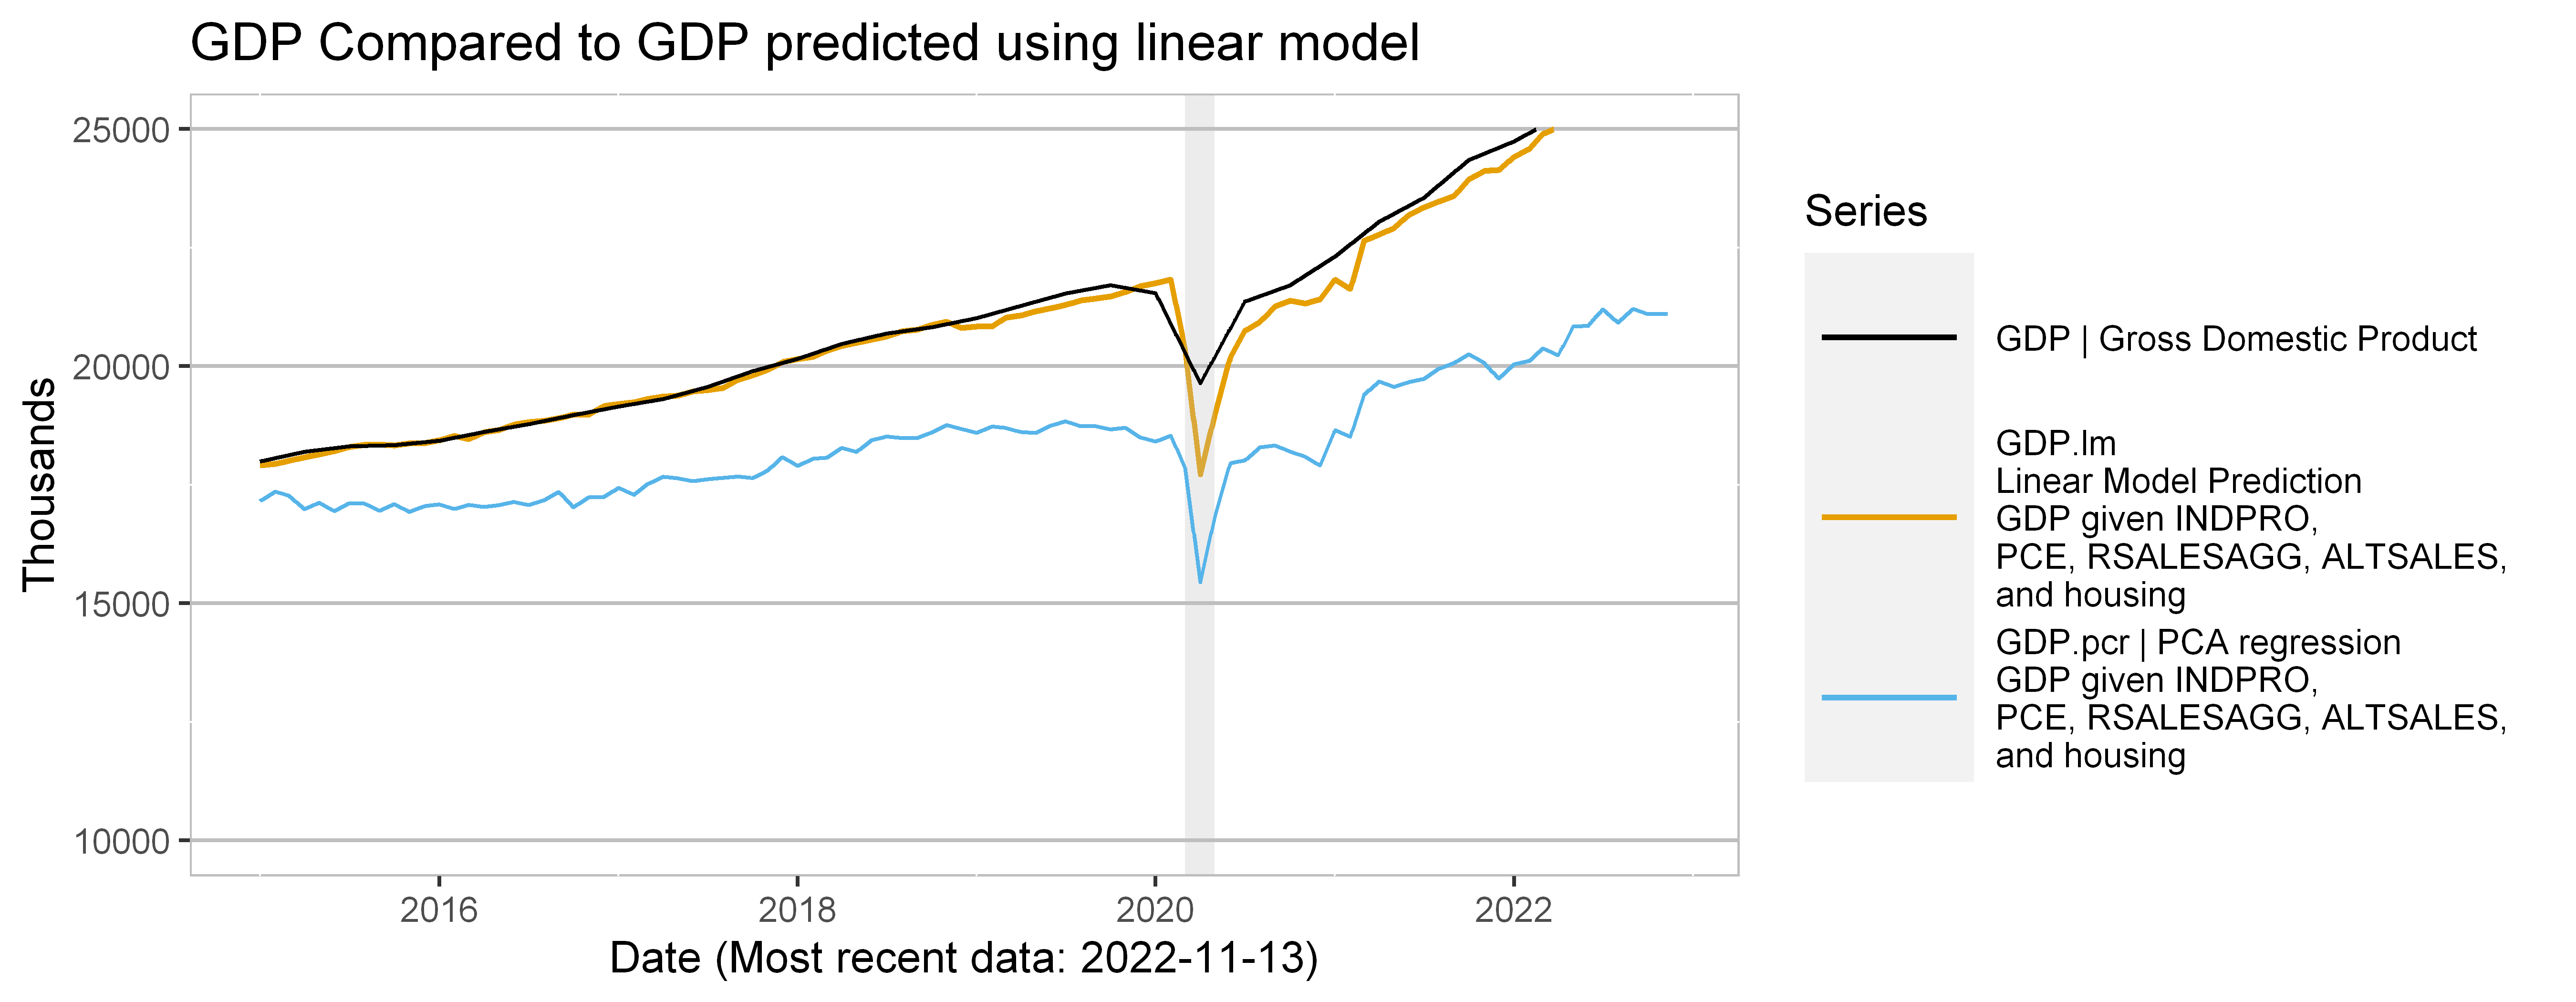

In [46]:
options(repr.plot.width = 9, repr.plot.height = 3.5, repr.plot.res = 600)
datay <- "GDP.lm"
datay.aux <- "GDP.pcr"
datay.aux.1 <- "GDP"
ylim <- c(10000, 25000)
dt.end <- Sys.Date()
dt.start <- as.Date("2015-01-01")
myPlot <-
  plotSingle(
    dfRecession,
    df.data,
    "date",
    datay,
    "GDP Compared to GDP predicted using linear model",
    "Date",
    getPlotYLabel(df.symbols, datay),
    c(dt.start, dt.end),
    ylim,
    b.legend = TRUE,
    b.percentile = FALSE,
    b.long.legend = TRUE
  )
myPlot <- myPlot + geom_line(
  data = df.data,
  aes_string(
    x = "date",
    y = datay.aux,
    colour = shQuote(getPlotTitle(df.symbols, datay.aux))
  ),
  na.rm = TRUE
)
myPlot <- myPlot + geom_line(
  data = df.data,
  aes_string(
    x = "date",
    y = datay.aux.1,
    colour = shQuote(getPlotTitle(df.symbols, datay.aux.1))
  ),
  na.rm = TRUE
)

print(myPlot)

In [47]:
df.data$GDPNOW <- df.data$GDPNOW/4 

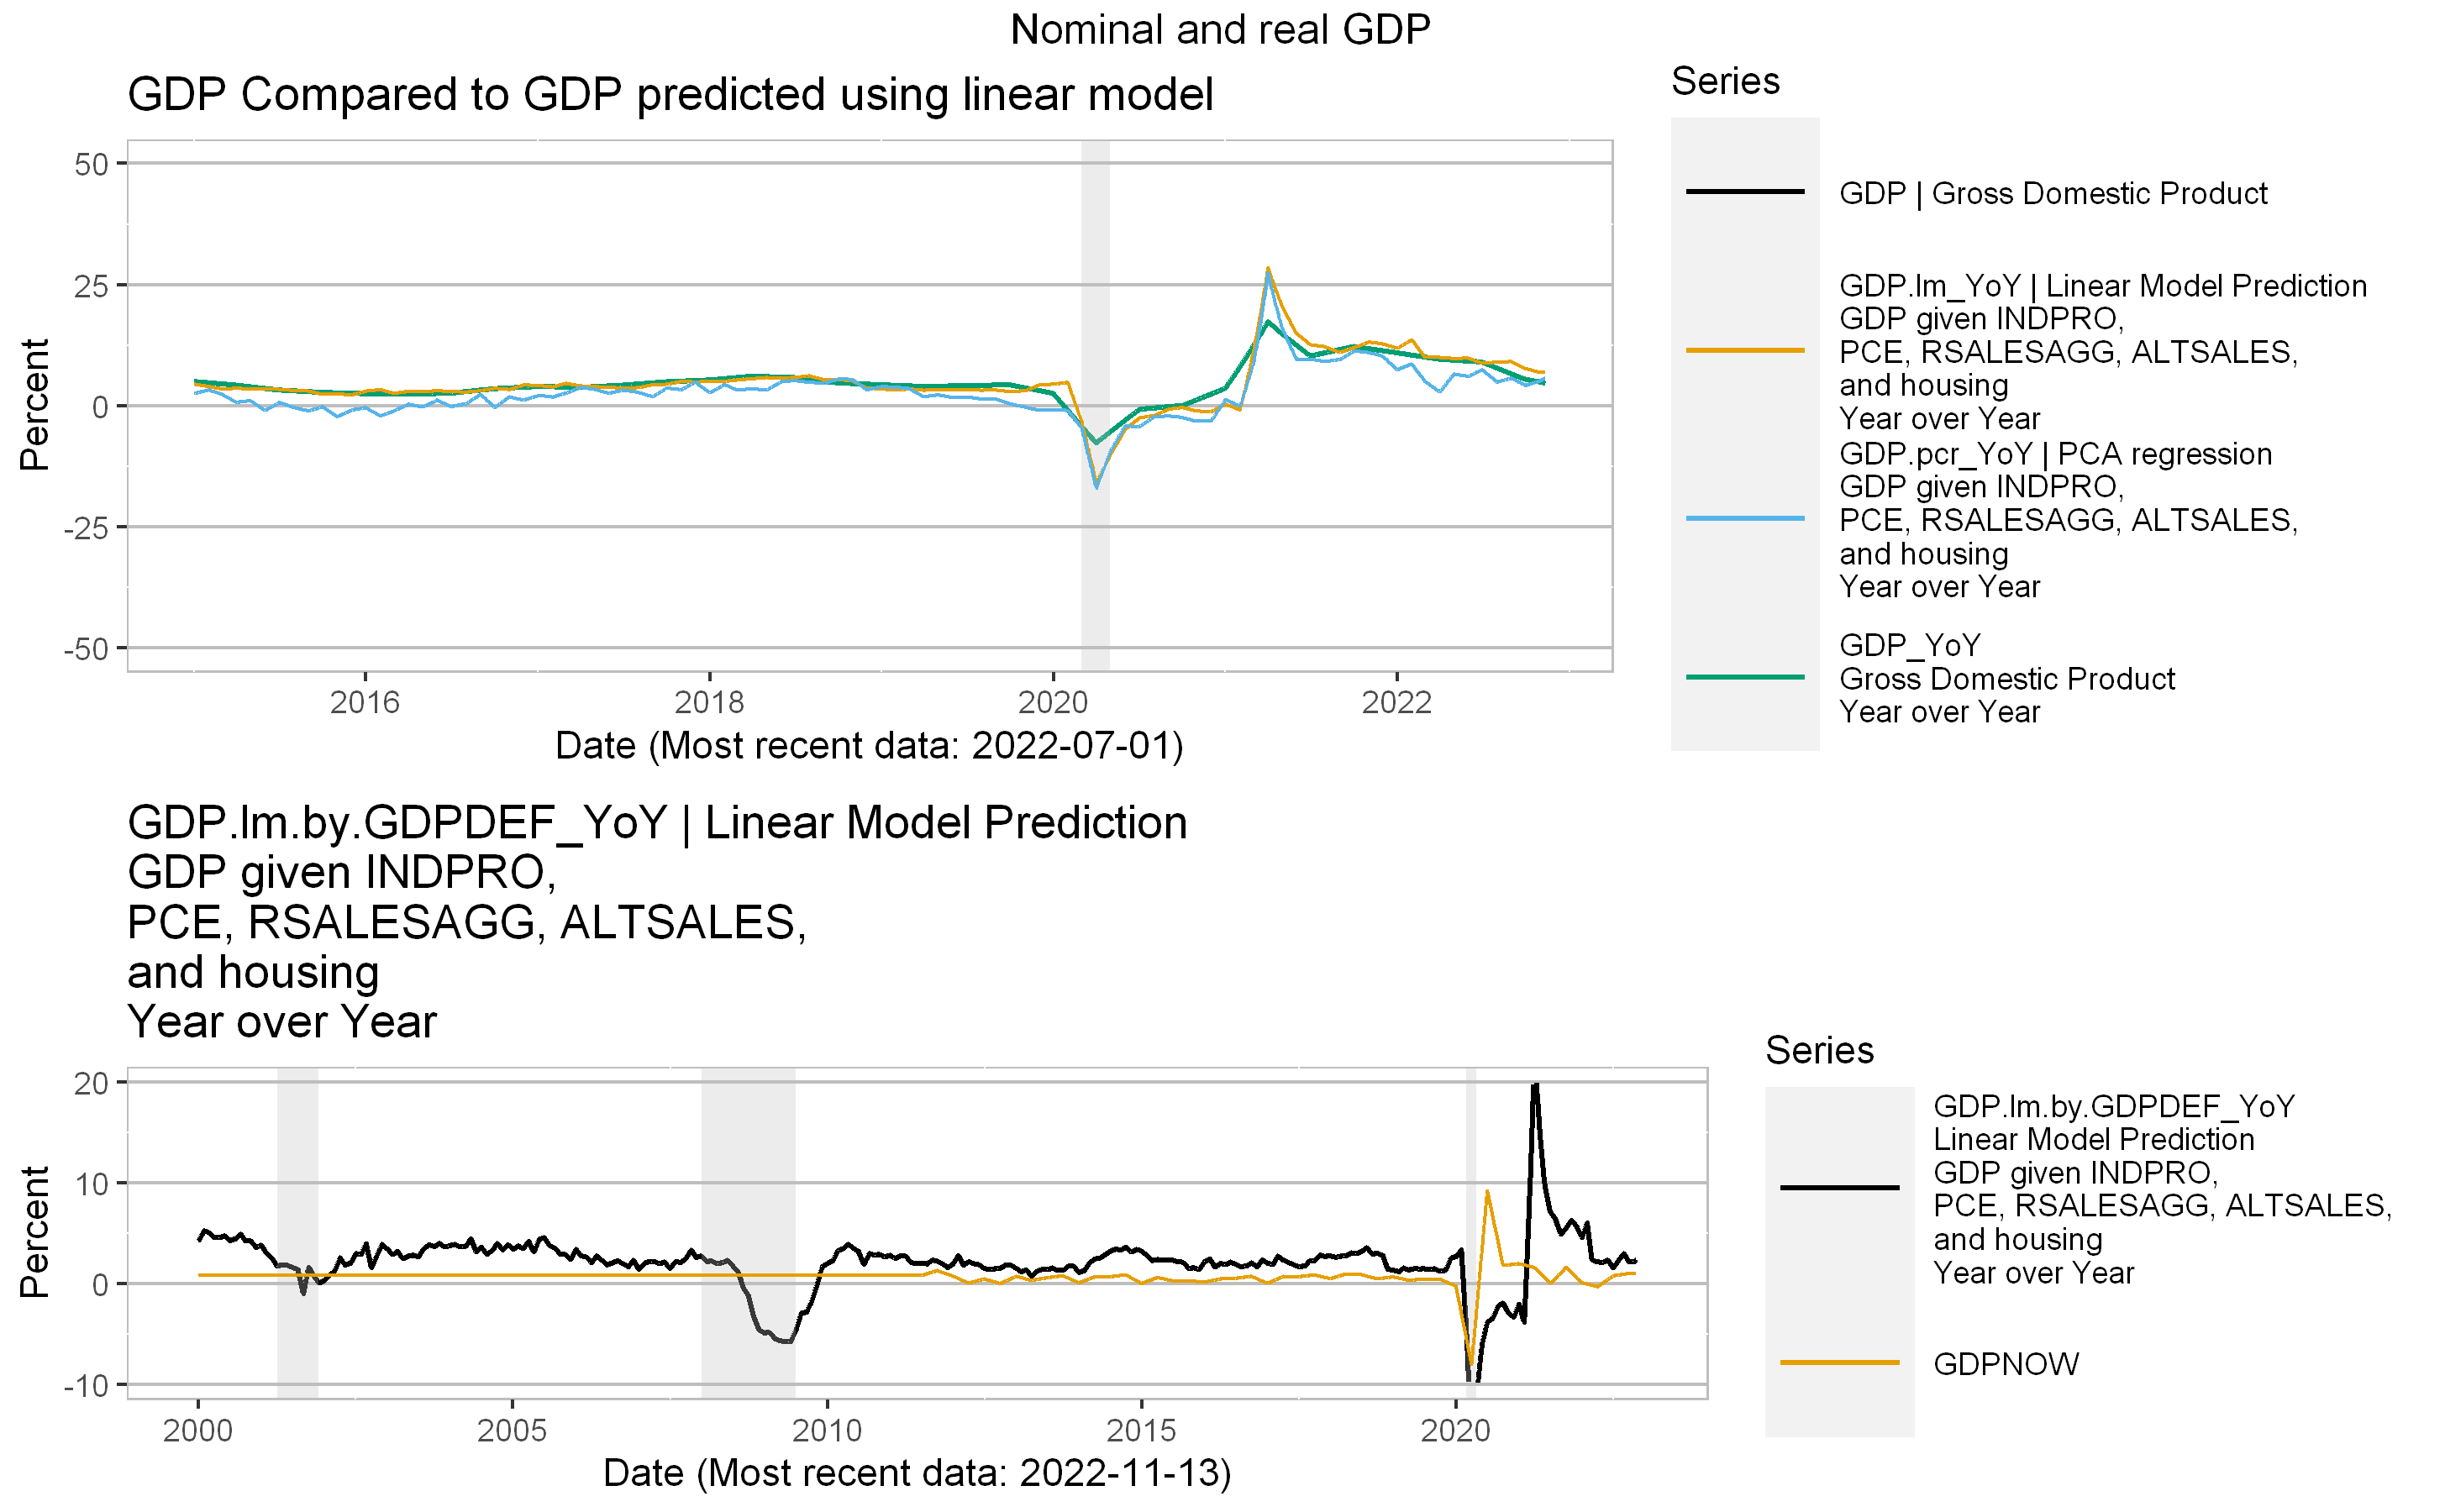

In [48]:
options(repr.plot.width = 9.7, repr.plot.height = 6, repr.plot.res = 300)

datay <- "GDP_YoY"
datay.aux <- "GDP.lm_YoY"
datay.aux.2 <- "GDP.pcr_YoY"
ylim <- c(-50, 50)
dt.end <- Sys.Date()
dt.start <- as.Date("2015-01-01")
p1 <-
  plotSingle(
    dfRecession,
    df.data,
    "date",
    datay,
    "GDP Compared to GDP predicted using linear model",
    "Date",
    getPlotYLabel(df.symbols, datay),
    c(dt.start, dt.end),
    ylim,
    b.legend = TRUE,
    b.percentile = FALSE,
    b.long.legend = TRUE
  )
p1 <- p1 + geom_line(
  data = df.data,
  aes_string(
    x = "date",
    y = datay.aux,
    colour = shQuote(getPlotTitle(df.symbols, datay.aux))
  ),
  na.rm = TRUE
)
p1 <- p1 + geom_line(
  data = df.data,
  aes_string(
    x = "date",
    y = datay.aux.1,
    colour = shQuote(getPlotTitle(df.symbols, datay.aux.1))
  ),
  na.rm = TRUE
)

p1 <- p1 + geom_line(
  data = df.data,
  aes_string(
    x = "date",
    y = datay.aux.2,
    colour = shQuote(getPlotTitle(df.symbols, datay.aux.2))
  ),
  na.rm = TRUE
)

datay.1 <- "GDP.lm.by.GDPDEF_YoY"
datay.aux.1 <- "GDPNOW"
ylim.1 <- c(-10, 20)
p2 <- plotSingleQuick(dfRecession, 
                      df.data, datay.1, 
                      ylim.1, dtStart, 
                      b.percentile = FALSE, 
                      b.legend = TRUE,
                      b.long.legend = TRUE)
p2 <- p2 + geom_line(
    data = df.data,
    aes_string(x = "date",
      y = datay.aux.1,
      colour = shQuote(datay.aux.1)
    ),
    na.rm = TRUE
  )

grid.arrange(p1,
             p2,
             ncol = 1,
             top = "Nominal and real GDP")

Look at how the GDP linear fit performed on the test data partition

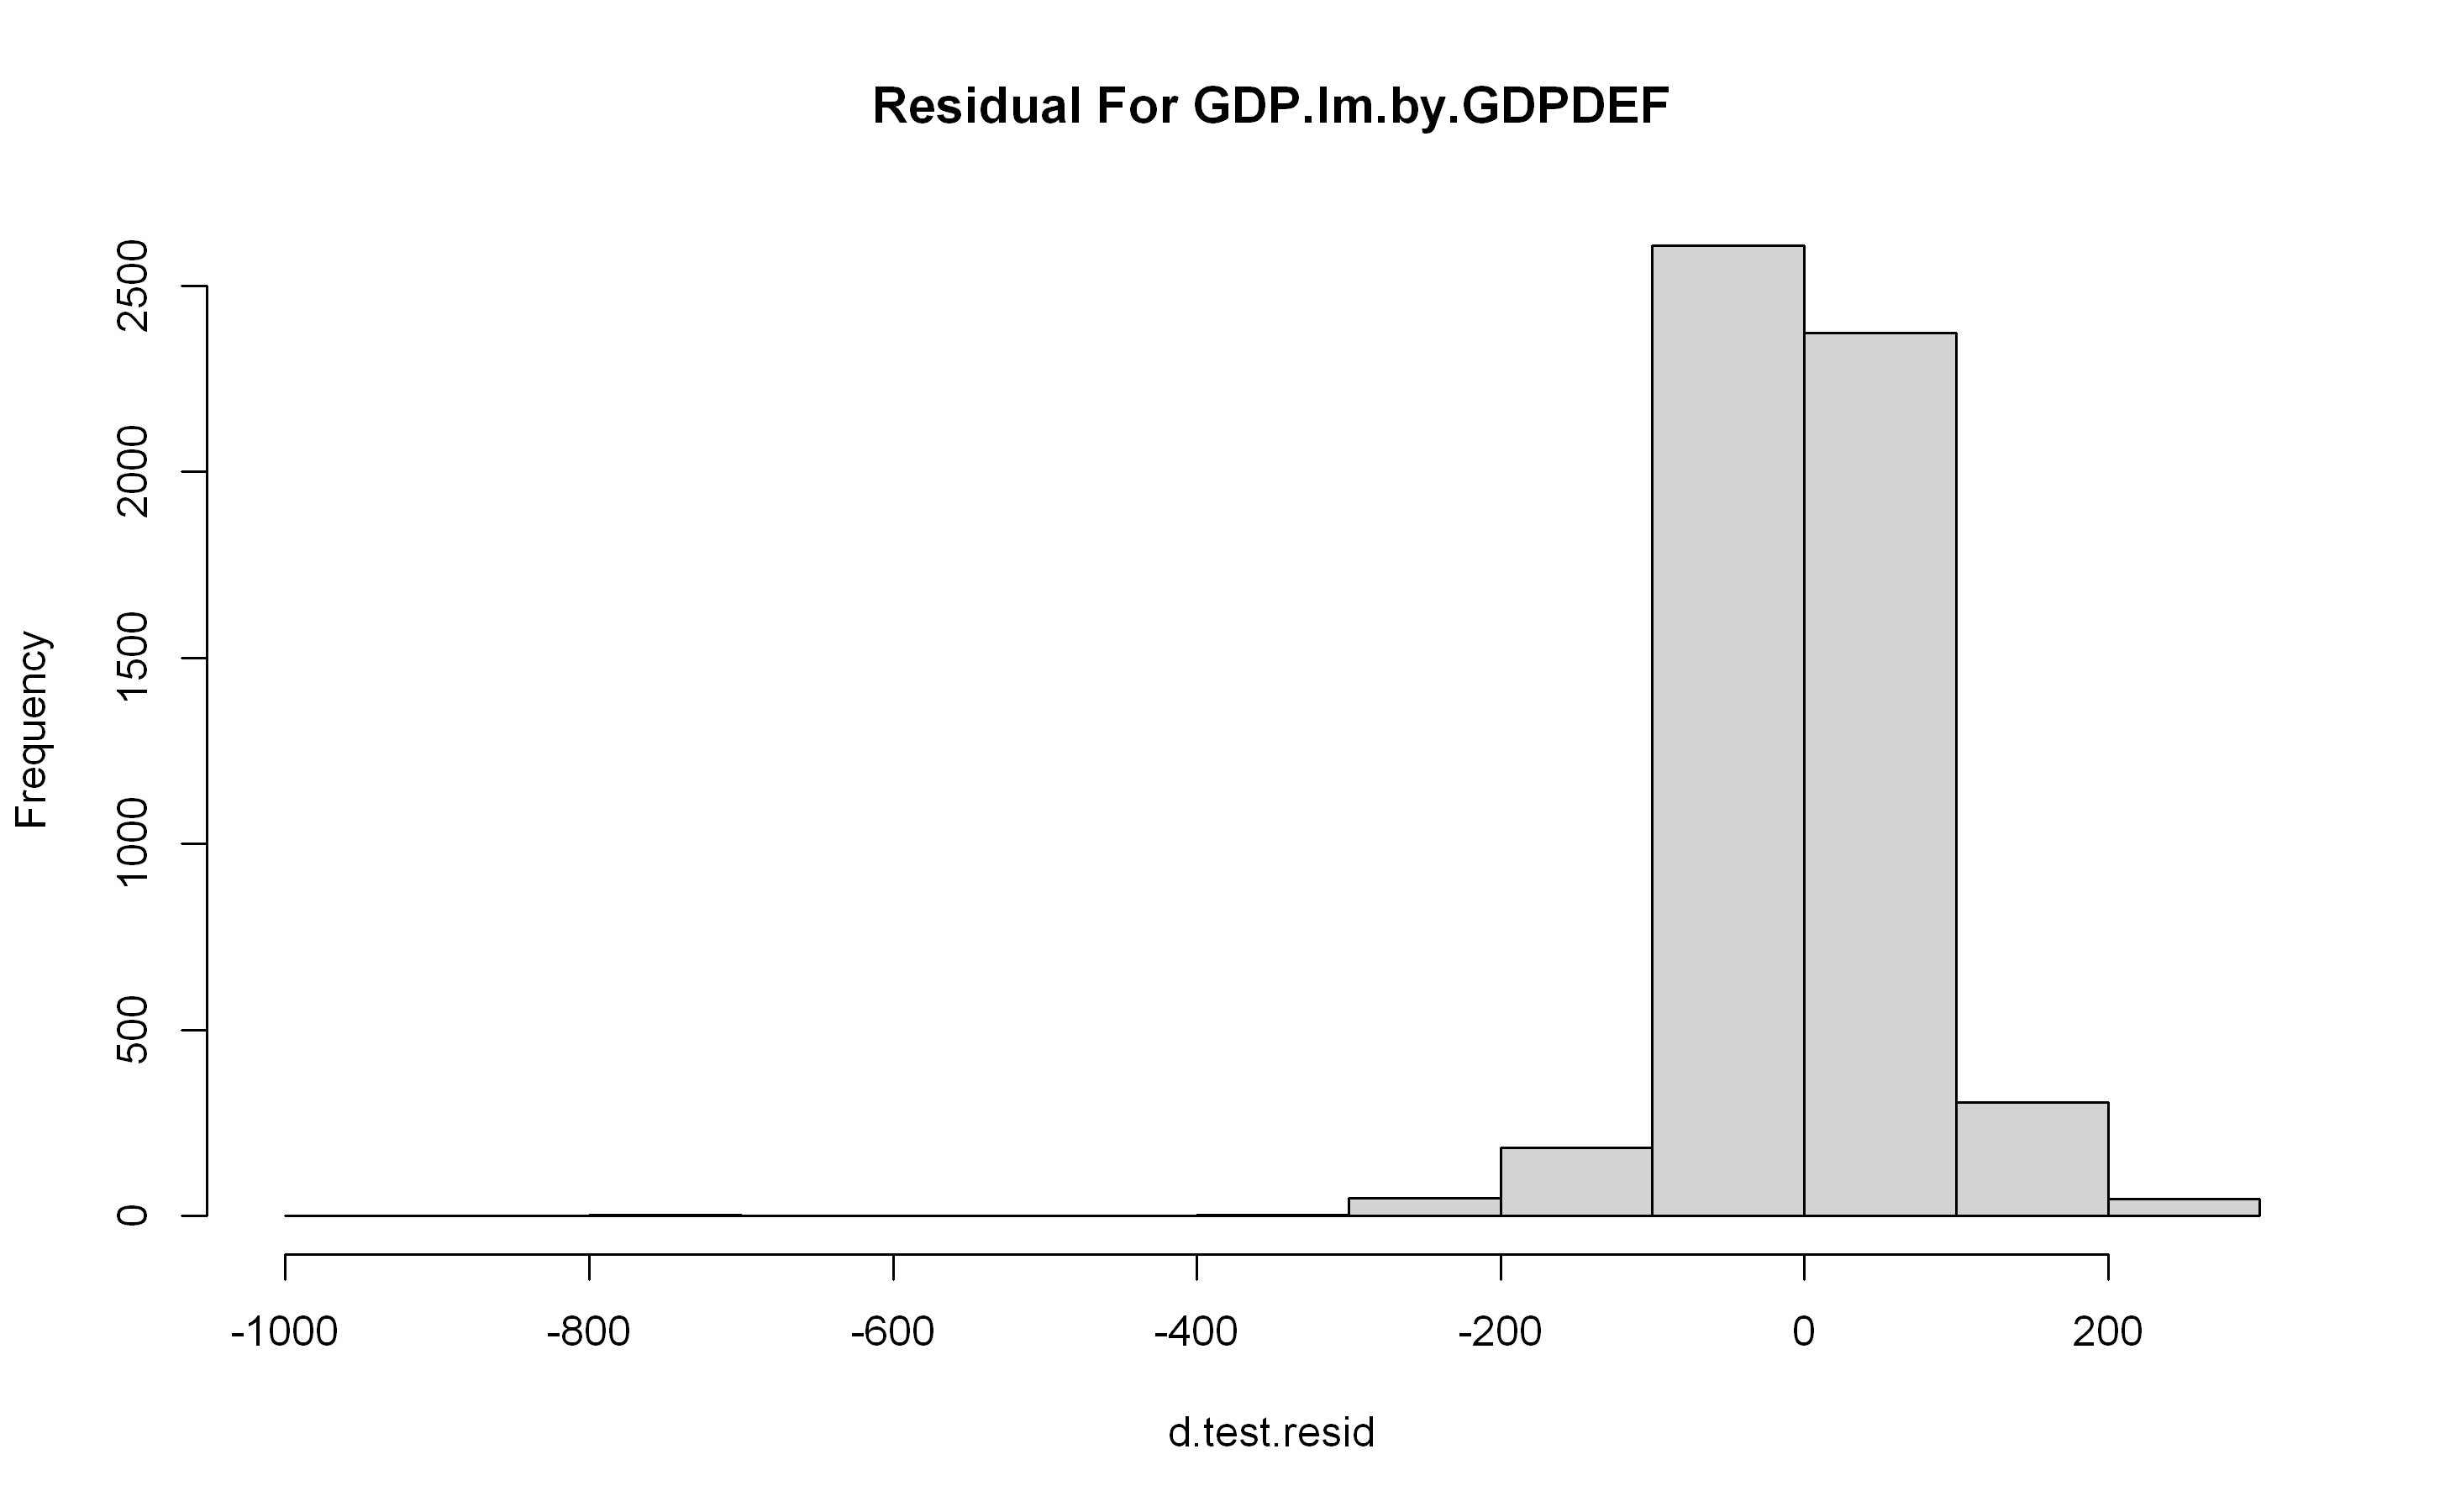

In [49]:
d.test.resid = (df.test$GDP - predict(list.fit.reg, newdata = df.test))
hist(d.test.resid, main=paste("Residual For", str.symbol, sep=" "))
sd.fit.gdp.m = sd(d.test.resid)

In [50]:
list.fit.reg$finalModel


Call:
lm(formula = .outcome ~ ., data = dat)

Coefficients:
      (Intercept)             INDPRO                PCE          RSALESAGG  
          7403.77             641.58            6372.65            -781.71  
         ALTSALES  MSPUS.times.HOUST  
            46.25              68.29  


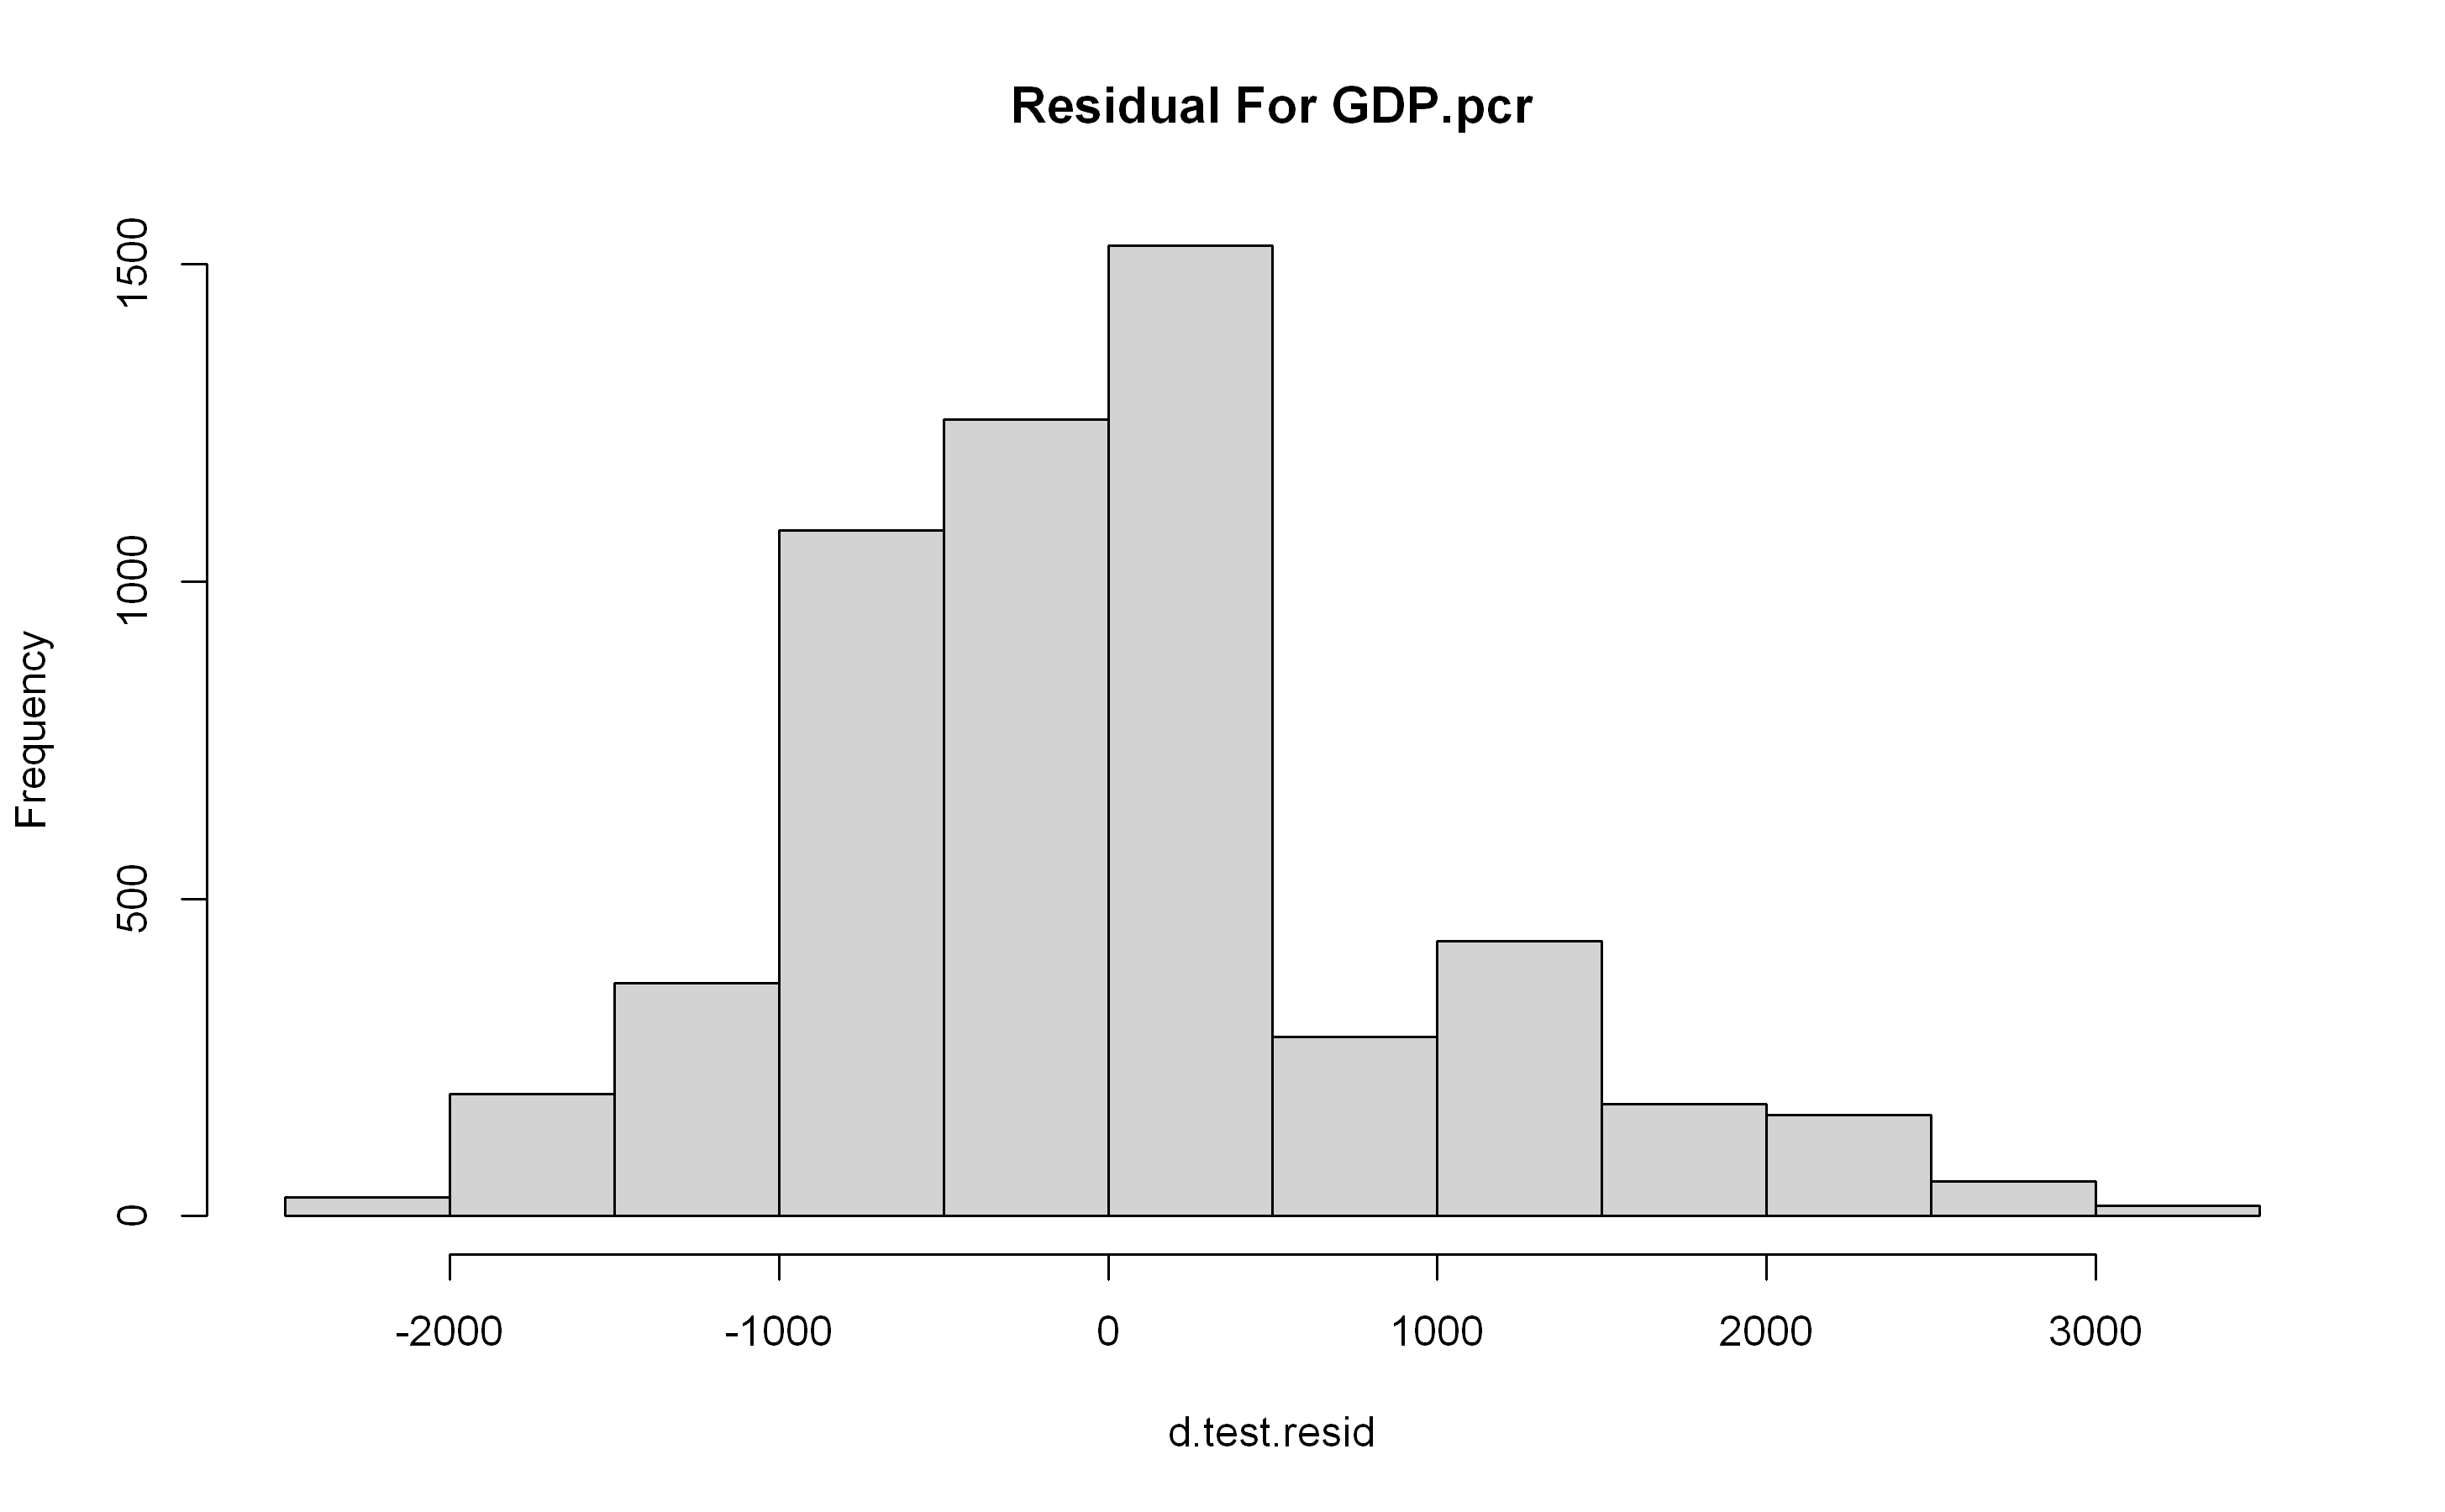

In [51]:
d.test.resid = (df.test$GDP - predict(list.fit.pcr, newdata = df.test))
hist(d.test.resid, main=paste("Residual For", str.symbol.pcr, sep=" "))
sd.fit.gdp.pcr = sd(d.test.resid)

In [52]:
summary(list.fit.pcr)

Data: 	X dimension: 11156 5 
	Y dimension: 11156 1
Fit method: svdpc
Number of components considered: 3
TRAINING: % variance explained
          1 comps  2 comps  3 comps
X           86.37    96.81    98.88
.outcome    89.68    97.23    97.84


Document the residual as well

In [53]:
str.symbol.res <- "GDP.lm.res"
df.data[str.symbol.res] <- df.data$GDP - df.data[str.symbol]

# Add the GDP linear model prediction residual to the symbols table
df.symbols <-
  rbind(
    df.symbols,
    data.frame(
      string.symbol = str.symbol.res,
      string.source = "Predict Resid.",
      string.description = "Residual for \nGDP given INDPRO,PCE, RSALESAGG,\nauto sales, and home sales",
      string.label.y = df.symbols[df.symbols$string.symbol==str.symbol,"string.label.y"],
      float.expense.ratio = -1.00,
      Max030 = FALSE,
      Max180 = FALSE,
      date.series.start = dt.start.prediction,
      date.series.end = as.Date(Sys.Date())
    )
  )


Document the PCR residual

In [54]:
str.symbol.pcr.res <- "GDP.pcr.res"
df.data[str.symbol.pcr.res] <- df.data$GDP - df.data[str.symbol.pcr]

# Add the GDP linear model prediction residual to the symbols table
df.symbols <-
  rbind(
    df.symbols,
    data.frame(
      string.symbol = str.symbol.pcr.res,
      string.source = "Predict Resid.",
      string.description = "PCR Residual for \nGDP given INDPRO,\nPCE, and RSALESAGG",
      string.label.y = df.symbols[df.symbols$string.symbol==str.symbol,"string.label.y"],
      float.expense.ratio = -1.00,
      Max030 = FALSE,
      Max180 = FALSE,
      date.series.start = dt.start.prediction,
      date.series.end = as.Date(Sys.Date())
    )
  )


Plot the residual  GDP to the linear fit prediction. 

The residuals decrease quite a bit during the Covid numbers, at least as of Jun 2020. Probably indicates uncertainty in the numbers.

Warning message:
"Removed 1 rows containing missing values (geom_text)."
Warning message:
"Removed 1 rows containing missing values (geom_hline)."


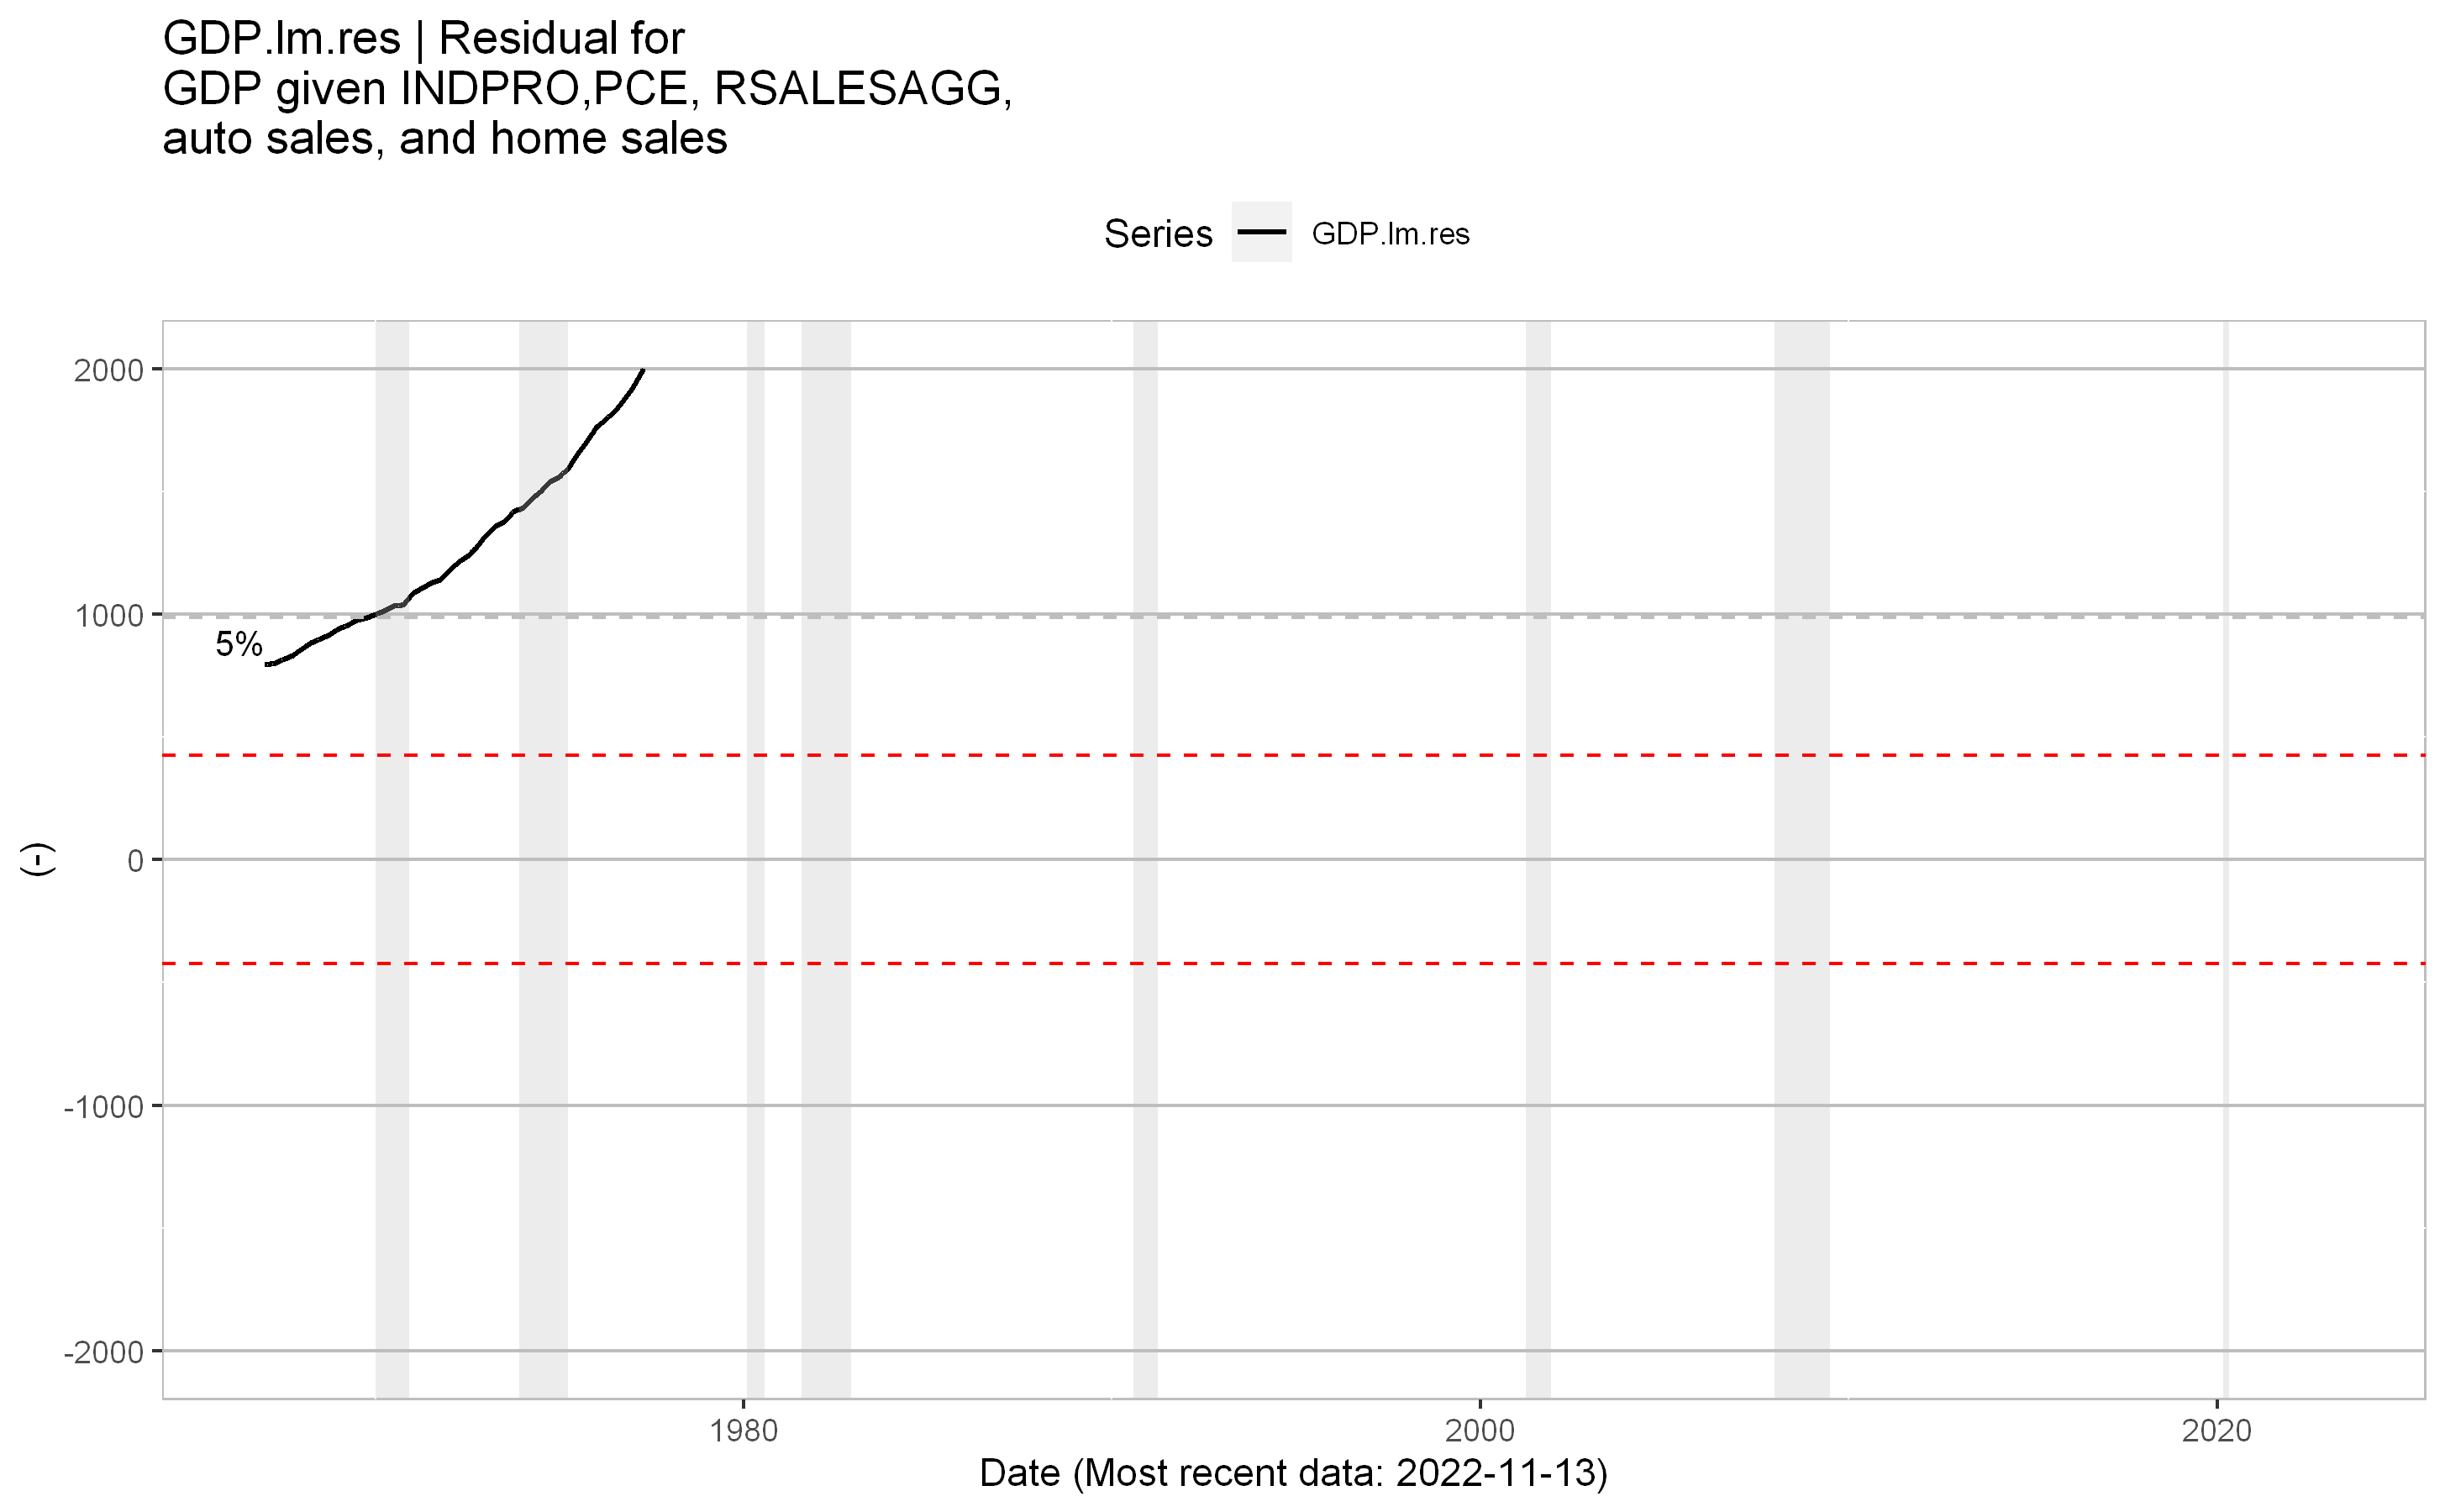

In [55]:
datay <- str.symbol.res
ylim <- c(-2000, 2000)
myPlot <- plotSingle(
  dfRecession,
  df.data,
  "date",
  datay,
  getPlotTitle(df.symbols, datay),
  "Date",
  getPlotYLabel(df.symbols, datay),
  c(as.Date("1jan1967", "%d%b%Y"), Sys.Date()),
  ylim,
  b.legend = TRUE,
  b.percentile = TRUE,
  b.long.legend = FALSE
)

myPlot <- myPlot + geom_hline(yintercept=(6*sd.fit.gdp.m), color = "red", linetype="dashed")
myPlot <- myPlot + geom_hline(yintercept=(-6*sd.fit.gdp.m), color = "red", linetype="dashed")

print(myPlot)

Plot the residual GDP to the PCR fit prediction. 

The residuals decrease quite a bit during the Covid numbers, at least as of Jun 2020. Probably indicates uncertainty in the numbers.

Warning message:
"Removed 1 rows containing missing values (geom_text)."
Warning message:
"Removed 1 rows containing missing values (geom_hline)."
Warning message:
"Removed 1 rows containing missing values (geom_hline)."
Warning message:
"Removed 1 rows containing missing values (geom_hline)."


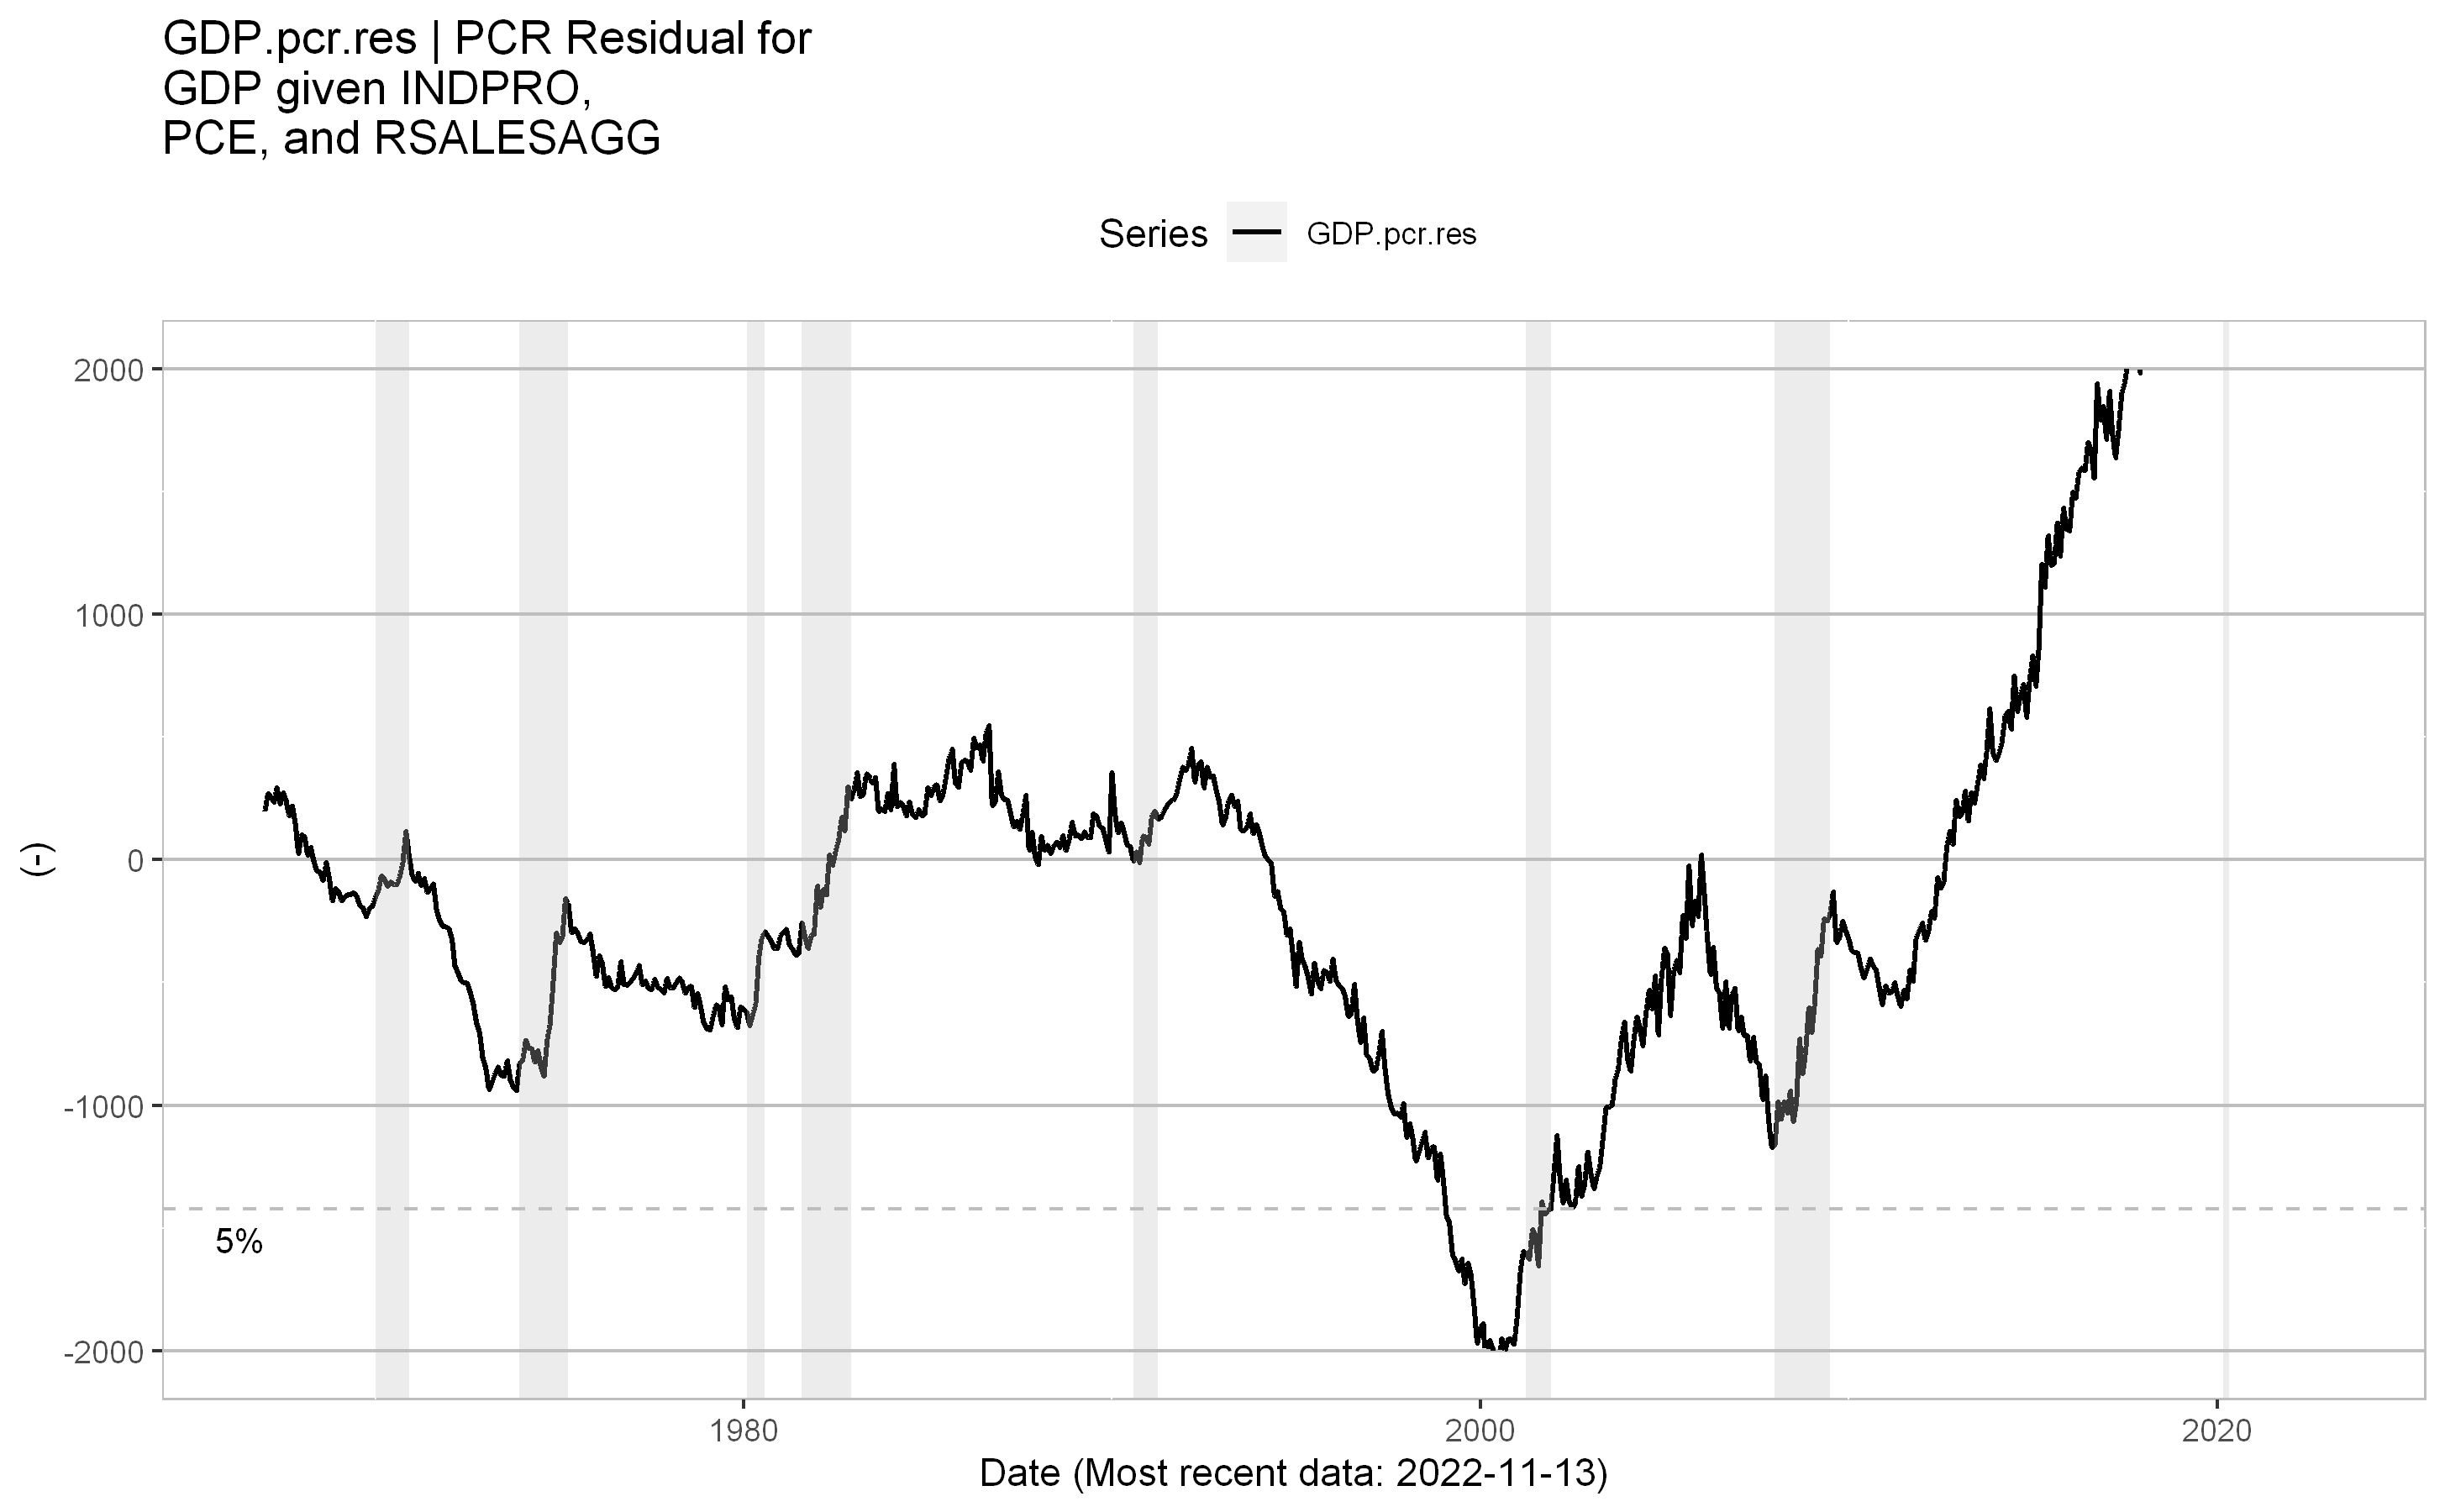

In [56]:
datay <- str.symbol.pcr.res
ylim <- c(-2000, 2000)
myPlot <- plotSingle(
  dfRecession,
  df.data,
  "date",
  datay,
  getPlotTitle(df.symbols, datay),
  "Date",
  getPlotYLabel(df.symbols, datay),
  c(as.Date("1jan1967", "%d%b%Y"), Sys.Date()),
  ylim,
  b.legend = TRUE,
  b.percentile = TRUE,
  b.long.legend = FALSE
)

myPlot <- myPlot + geom_hline(yintercept=(6*sd.fit.gdp.pcr), color = "red", linetype="dashed")
myPlot <- myPlot + geom_hline(yintercept=(-6*sd.fit.gdp.pcr), color = "red", linetype="dashed")

print(myPlot)


### Regression, Advanced Retail sales

See if we can get there with a simple regression model. Begin by taking a look at how these datapoints correlate with advanced retail sales

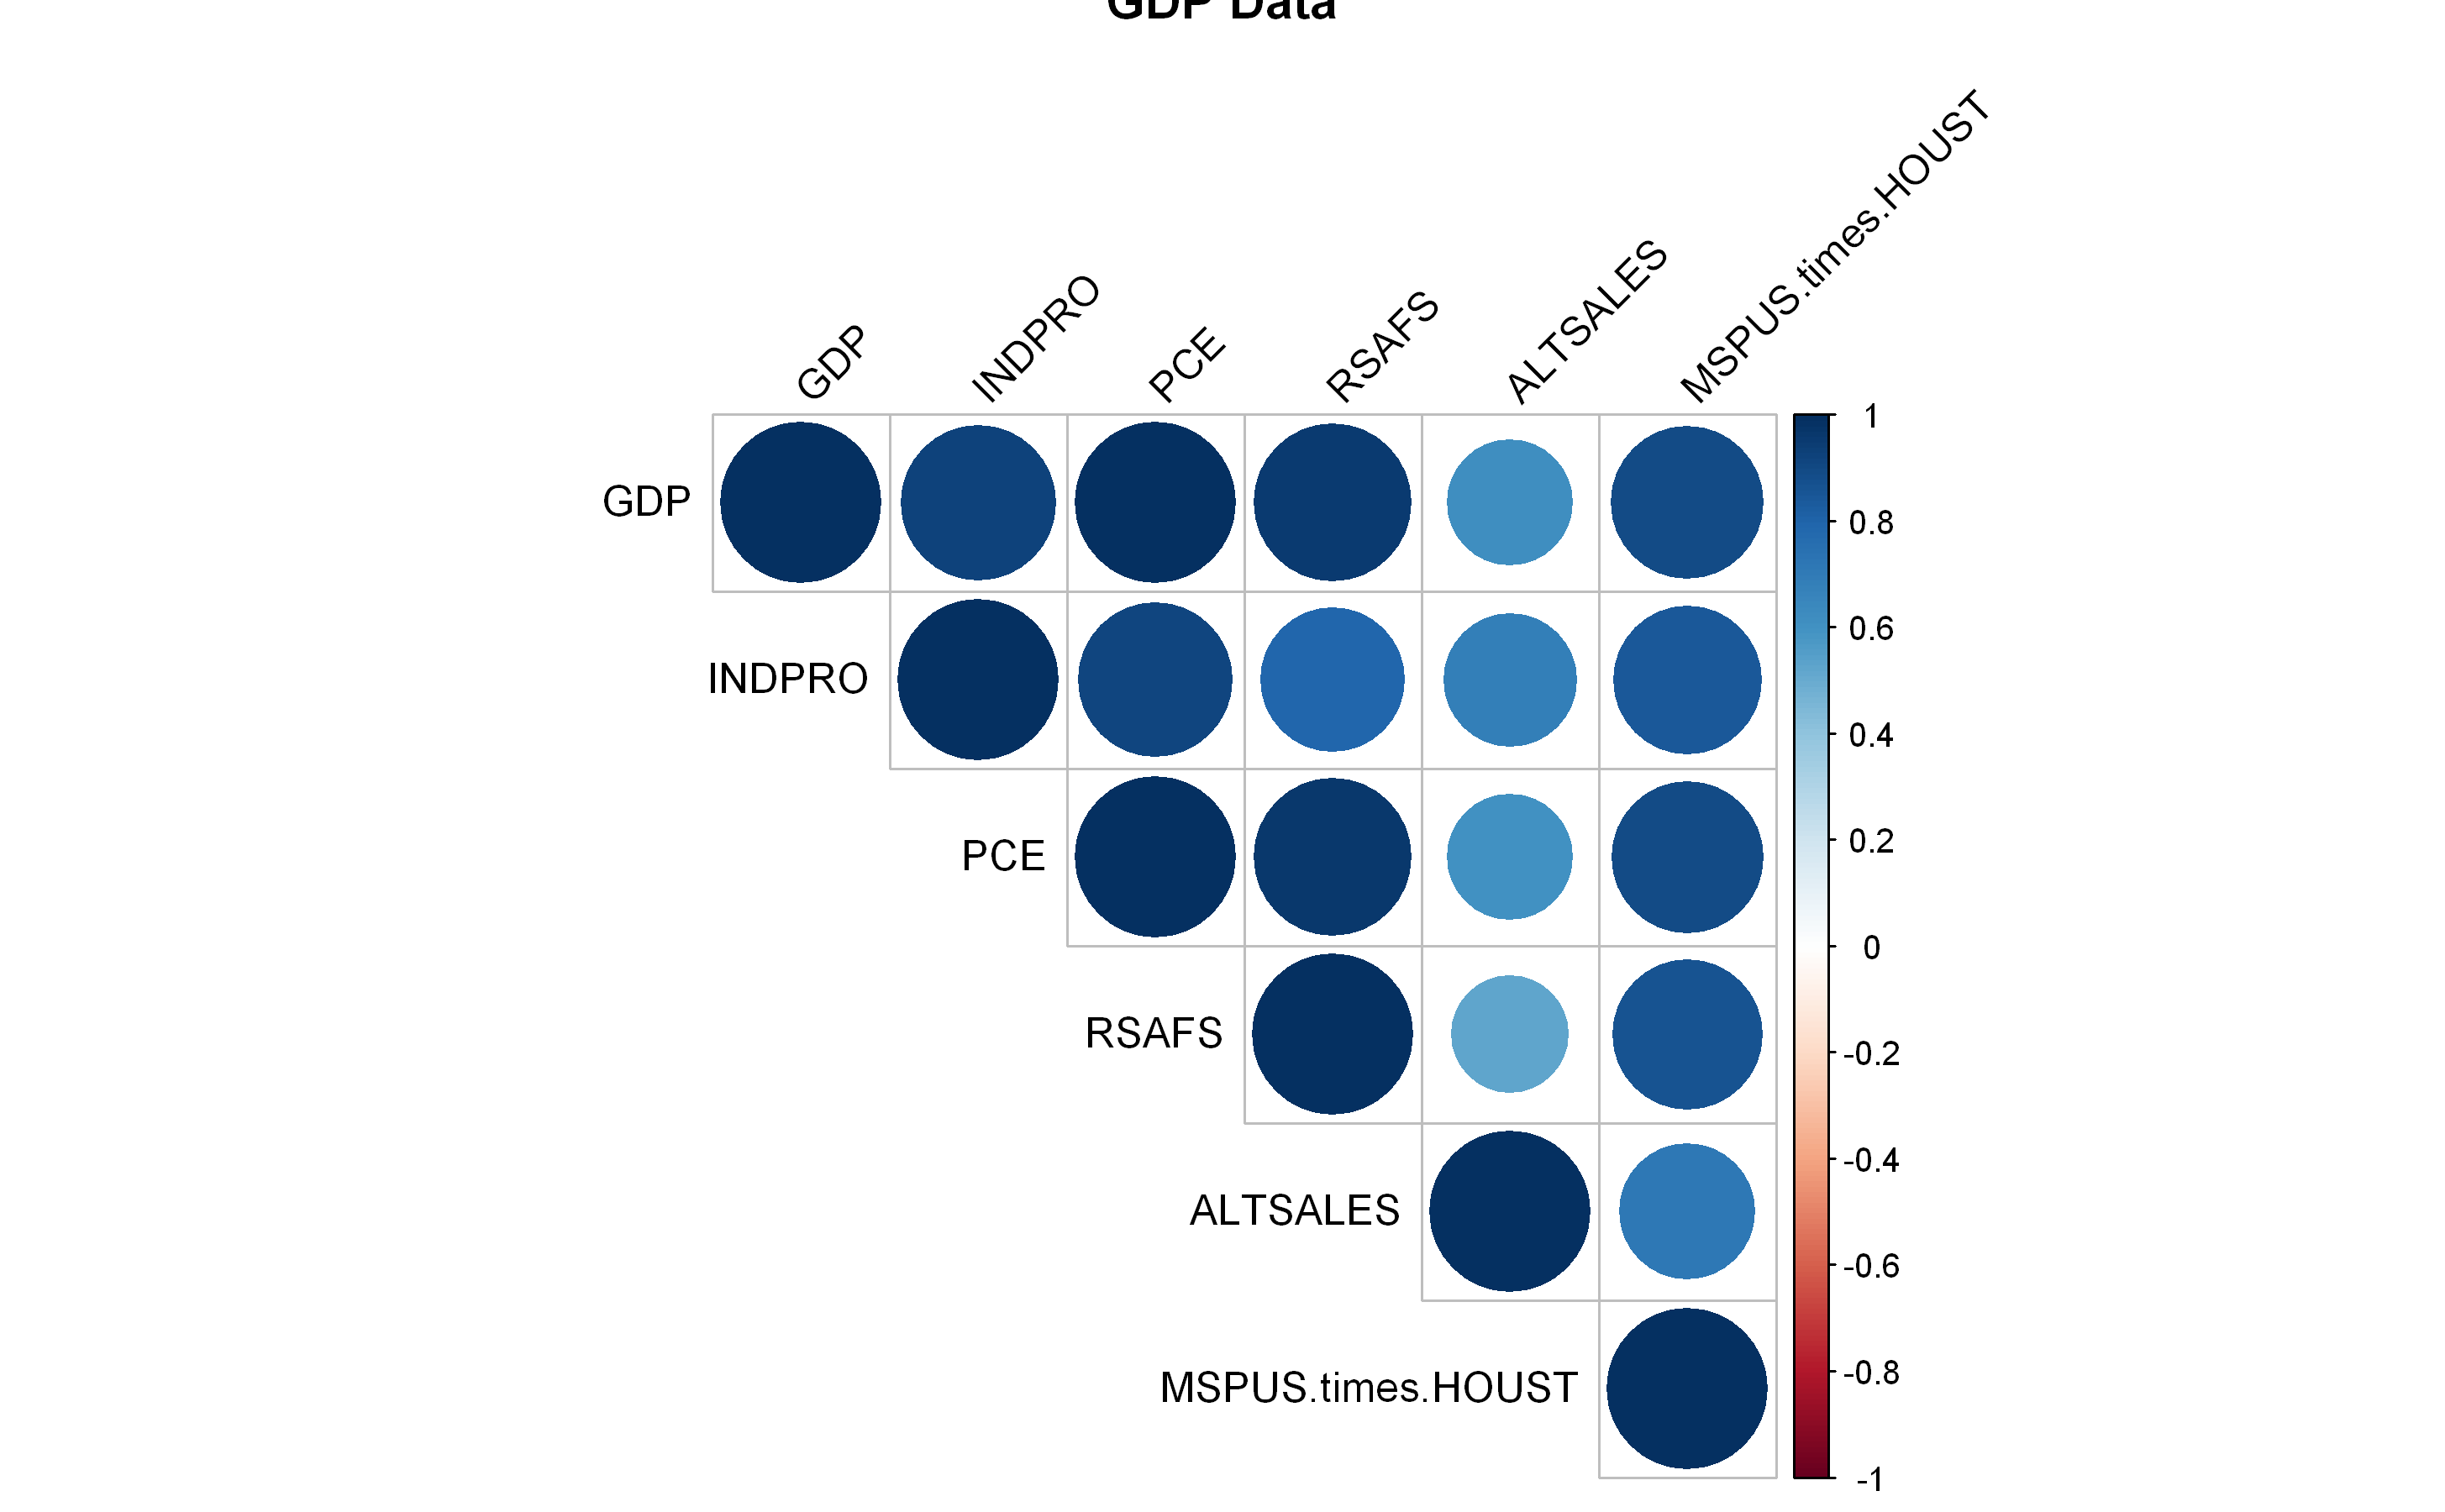

In [57]:
# Correlation for the entire data set
training.cor <-
  df.data[, c("GDP", "INDPRO", "PCE", "RSAFS", "ALTSALES", "MSPUS.times.HOUST")]

  rcorr.data <- rcorr(as.matrix(training.cor), type = "pearson")
  #print(rcorr.data)

  corrplot::corrplot(cor(training.cor), type="upper", order="original", 
           tl.col="black", tl.srt=45, title ="GDP Data")

In [58]:

df.gdp.model <-
  df.data[df.data$date >= dt.start.prediction &
            df.data$date <= dt.end.prediction,]

# I break the data into three sets: 50% for training, 25% for testing, and 25% for validation.
set.seed(123456)
in.train <- createDataPartition(y=df.gdp.model$GDP, p = 0.50, list=FALSE)
df.train <- df.gdp.model[in.train,]
df.data.rest <- df.gdp.model[-in.train,]
in.val <- createDataPartition(y = df.data.rest$GDP, p = 0.50, list = FALSE)
df.val <- df.data.rest[in.val,]
df.test <- df.data.rest[-in.val,]
rm(df.data.rest)

# Perform the linear fit
list.fit.reg.adv <- train(
  GDP ~ INDPRO + PCE + RSAFS + ALTSALES + MSPUS.times.HOUST,
  data = df.train,
  method = "lm",
  preProcess = c('center', 'scale')
)


In [59]:
# Add linear prediction to the dataframe
str.symbol <- "GDP.lm.adv"
df.data[str.symbol] <-
  predict(list.fit.reg.adv, newdata = df.data)

# Add the linear model prediction to the symbols table
df.symbols <-
  rbind(
    df.symbols,
    data.frame(
      string.symbol = str.symbol,
      string.source = "Predict",
      string.description = "Linear Model Prediction\nGDP given INDPRO,\nPCE, RSAFS, auto sales,\nand housing",
      string.label.y = getPlotYLabel(df.symbols, "POPTHM")[1],
      float.expense.ratio = -1.00,
      Max030 = FALSE,
      Max180 = FALSE,
      date.series.start = dt.start.prediction,
      date.series.end = as.Date(Sys.Date())
    )
  )

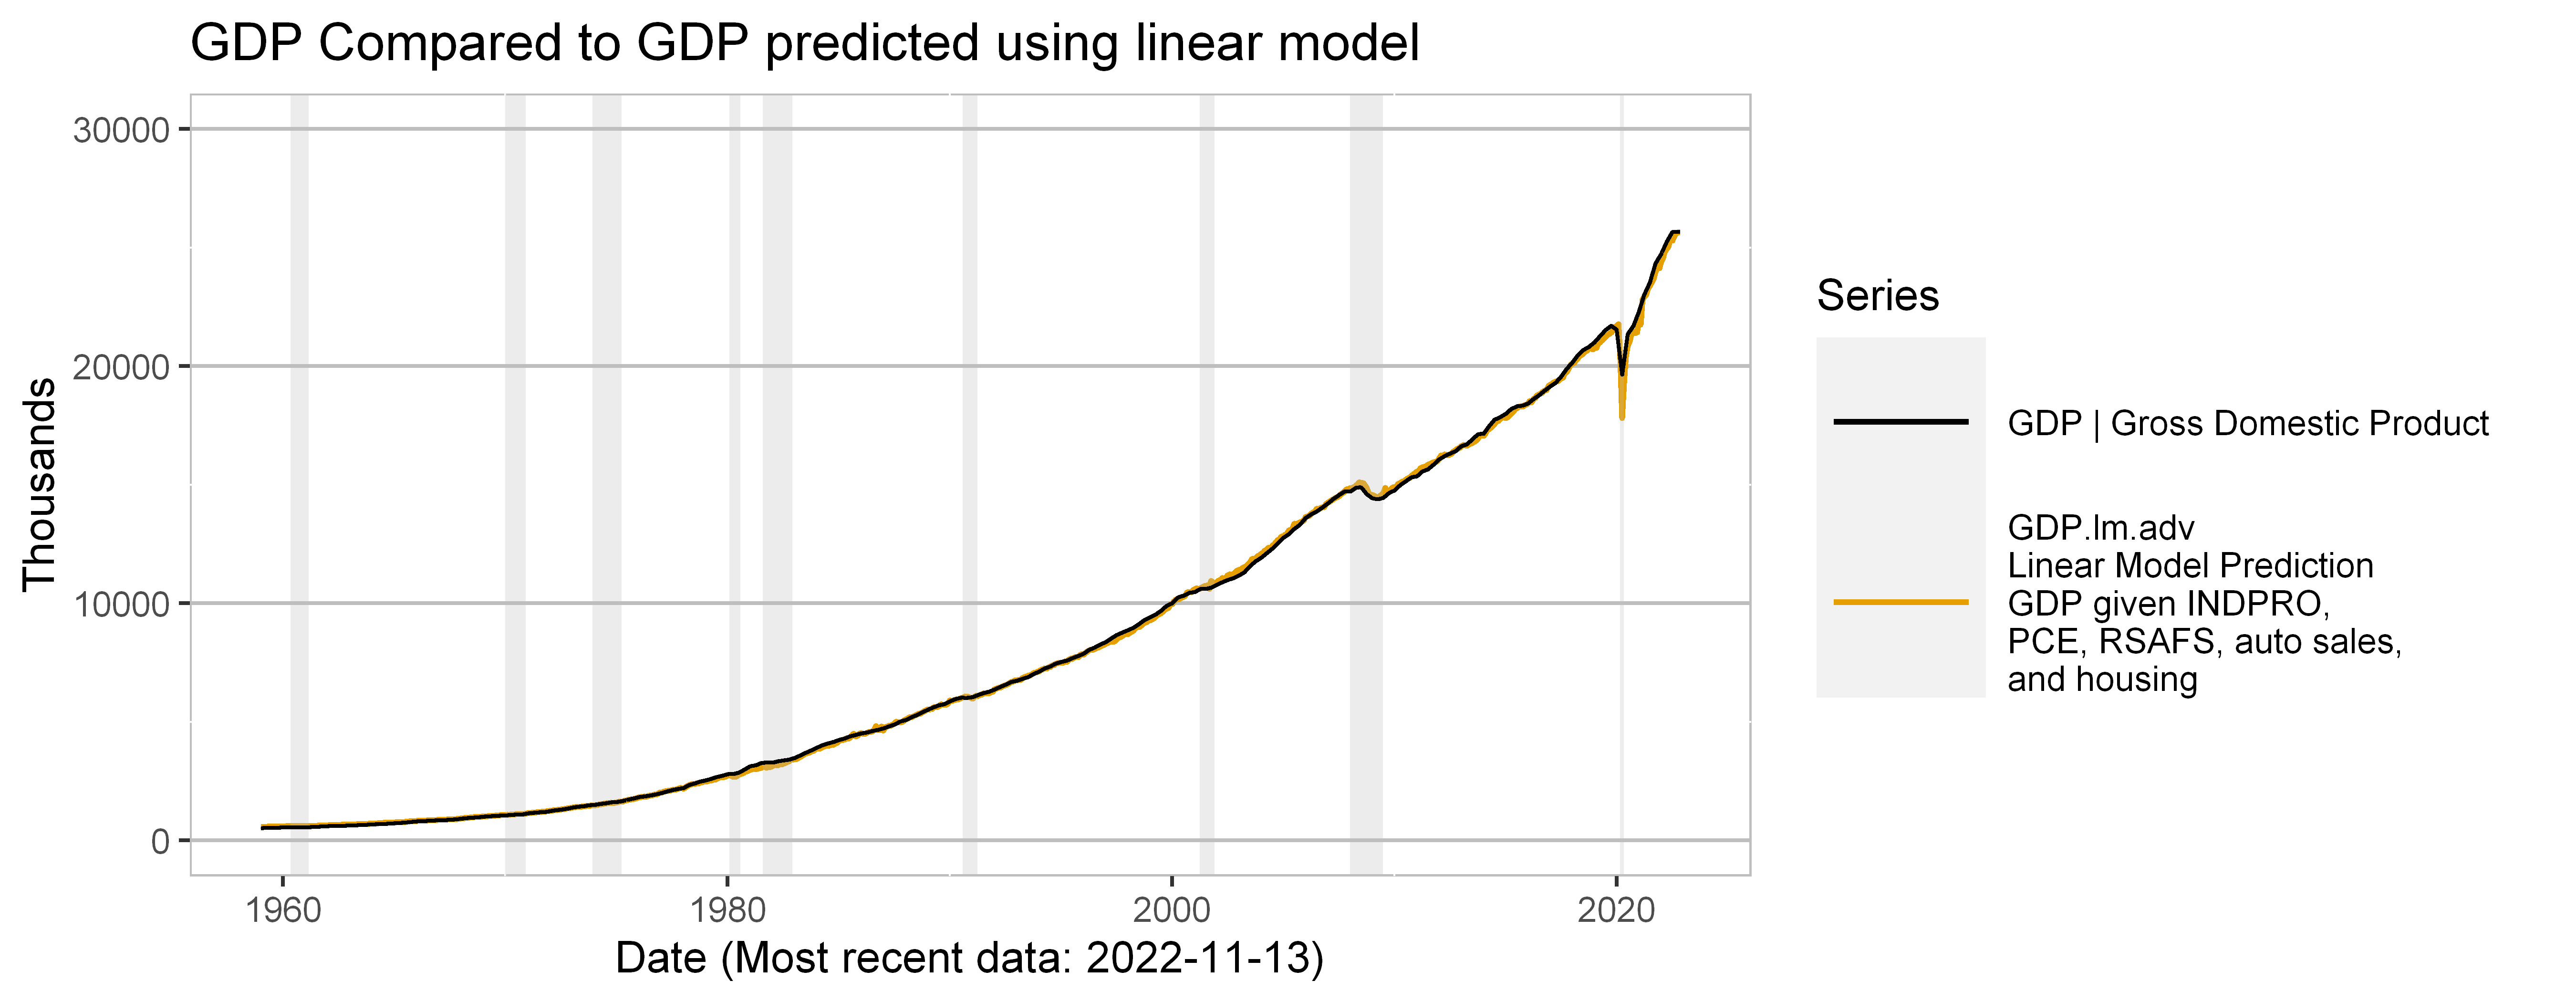

In [65]:

datay <- "GDP.lm.adv"
datay.aux <- "GDP"
ylim <- c(0, 30000)
dt.end <- Sys.Date()
myPlot <- 
  plotSingle(
    dfRecession,
    df.data,
    "date",
    datay,
    "GDP Compared to GDP predicted using linear model",
    "Date",
    getPlotYLabel(df.symbols, datay),
    c(dt.start.prediction, dt.end),
    ylim,
    b.legend = TRUE,
    b.percentile = FALSE,
    b.long.legend = TRUE
  )
myPlot <- myPlot + geom_line(
  data = df.data,
  aes_string(
    x = "date",
    y = datay.aux,
    colour = shQuote(getPlotTitle(df.symbols, datay.aux))
  ),
  na.rm = TRUE
)

print(myPlot)

Looking at some more recent data points

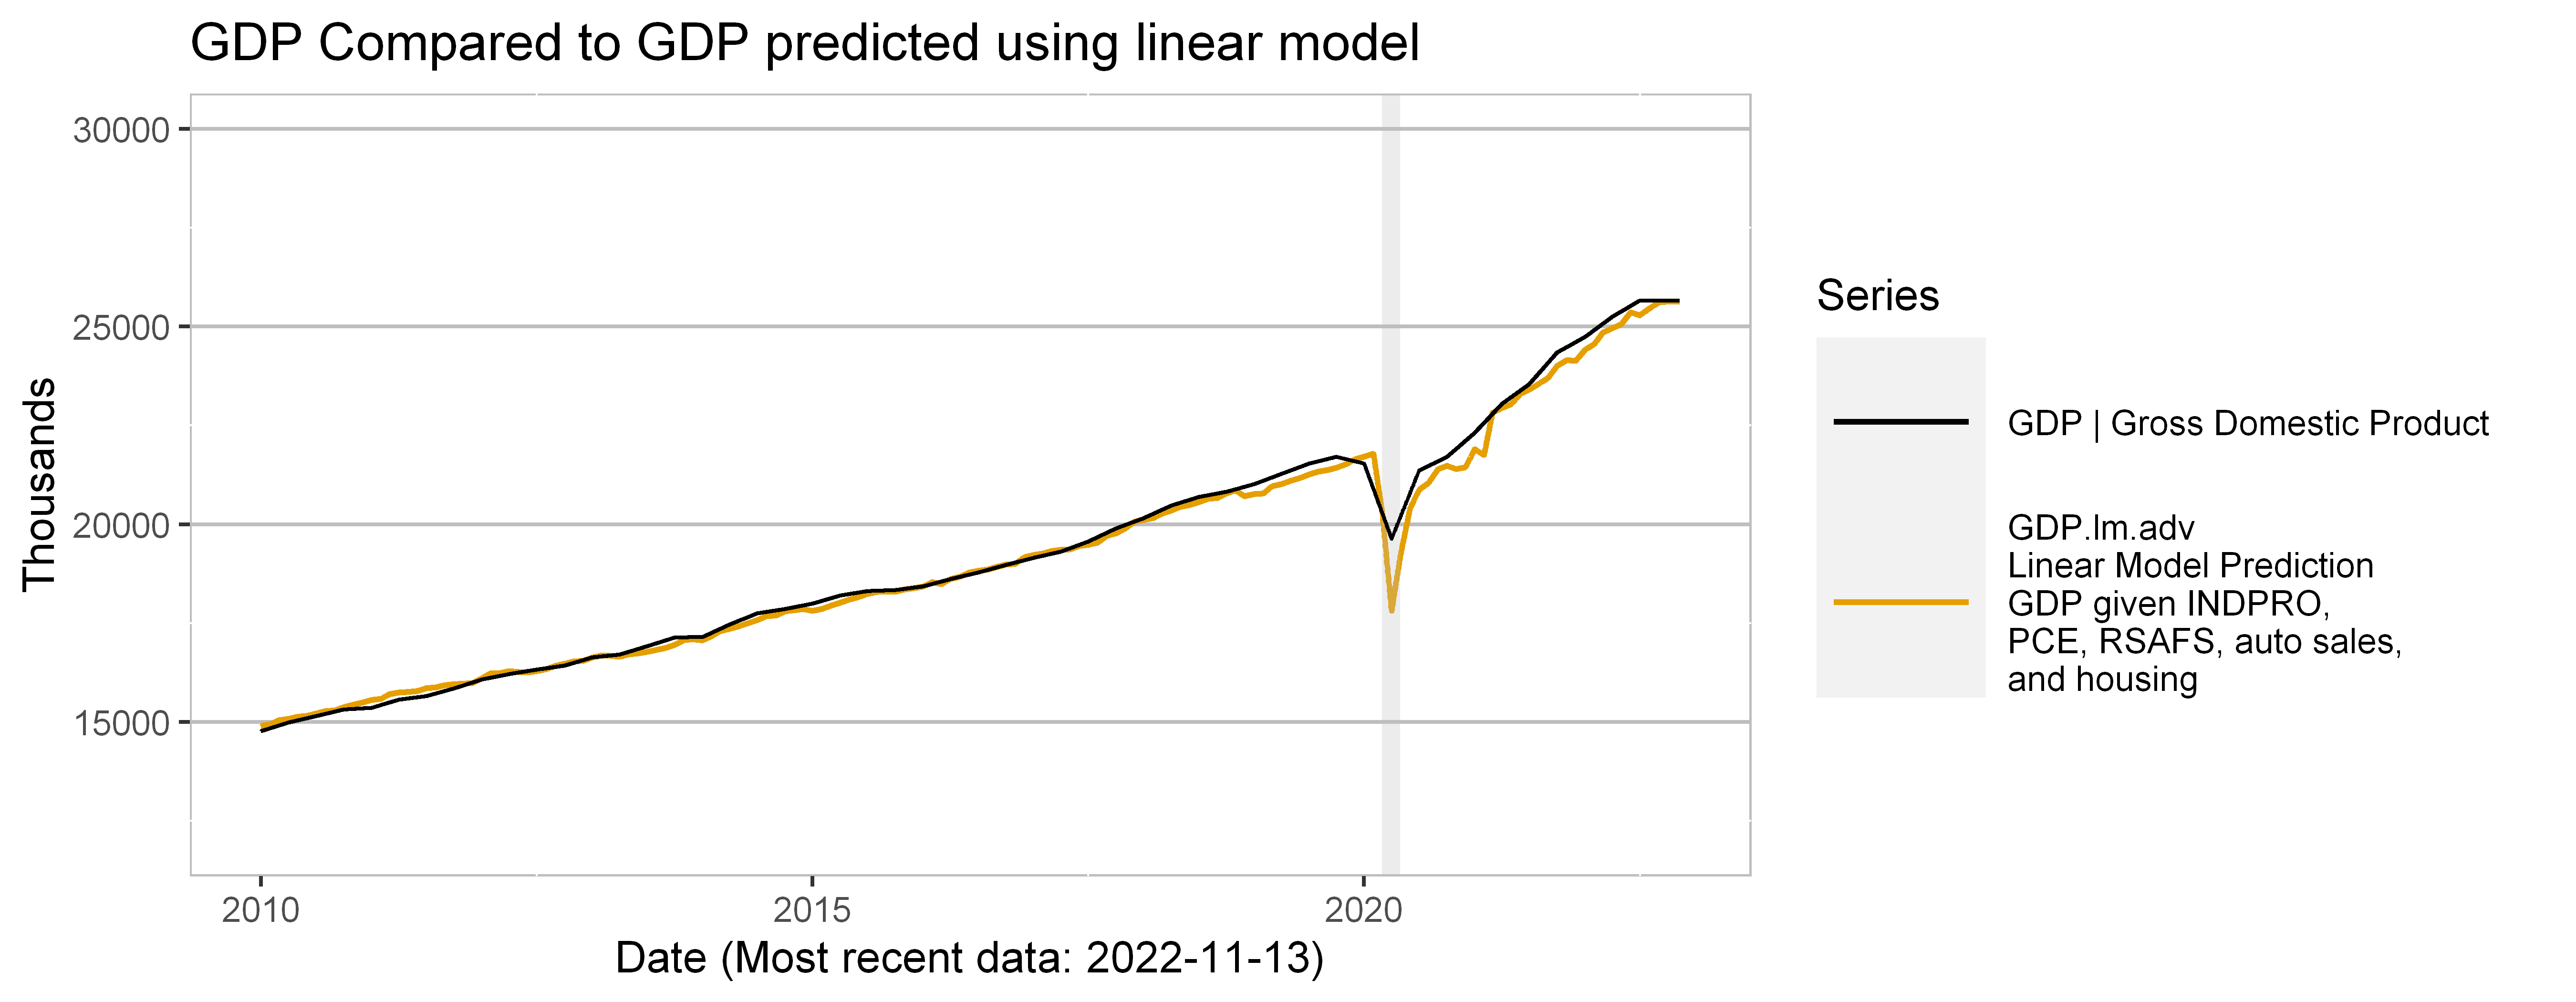

In [66]:
options(repr.plot.width = 9, repr.plot.height = 3.5, repr.plot.res = 600)
datay <- "GDP.lm.adv"
datay.aux <- "GDP"
ylim <- c(12000, 30000)
dt.end <- Sys.Date()
dt.start <- as.Date("2010-01-01")
myPlot <-
  plotSingle(
    dfRecession,
    df.data,
    "date",
    datay,
    "GDP Compared to GDP predicted using linear model",
    "Date",
    getPlotYLabel(df.symbols, datay),
    c(dt.start, dt.end),
    ylim,
    b.legend = TRUE,
    b.percentile = FALSE,
    b.long.legend = TRUE
  )
myPlot <- myPlot + geom_line(
  data = df.data,
  aes_string(
    x = "date",
    y = datay.aux,
    colour = shQuote(getPlotTitle(df.symbols, datay.aux))
  ),
  na.rm = TRUE
)

print(myPlot)

Look at how the GDP linear fit performed on the test data partition

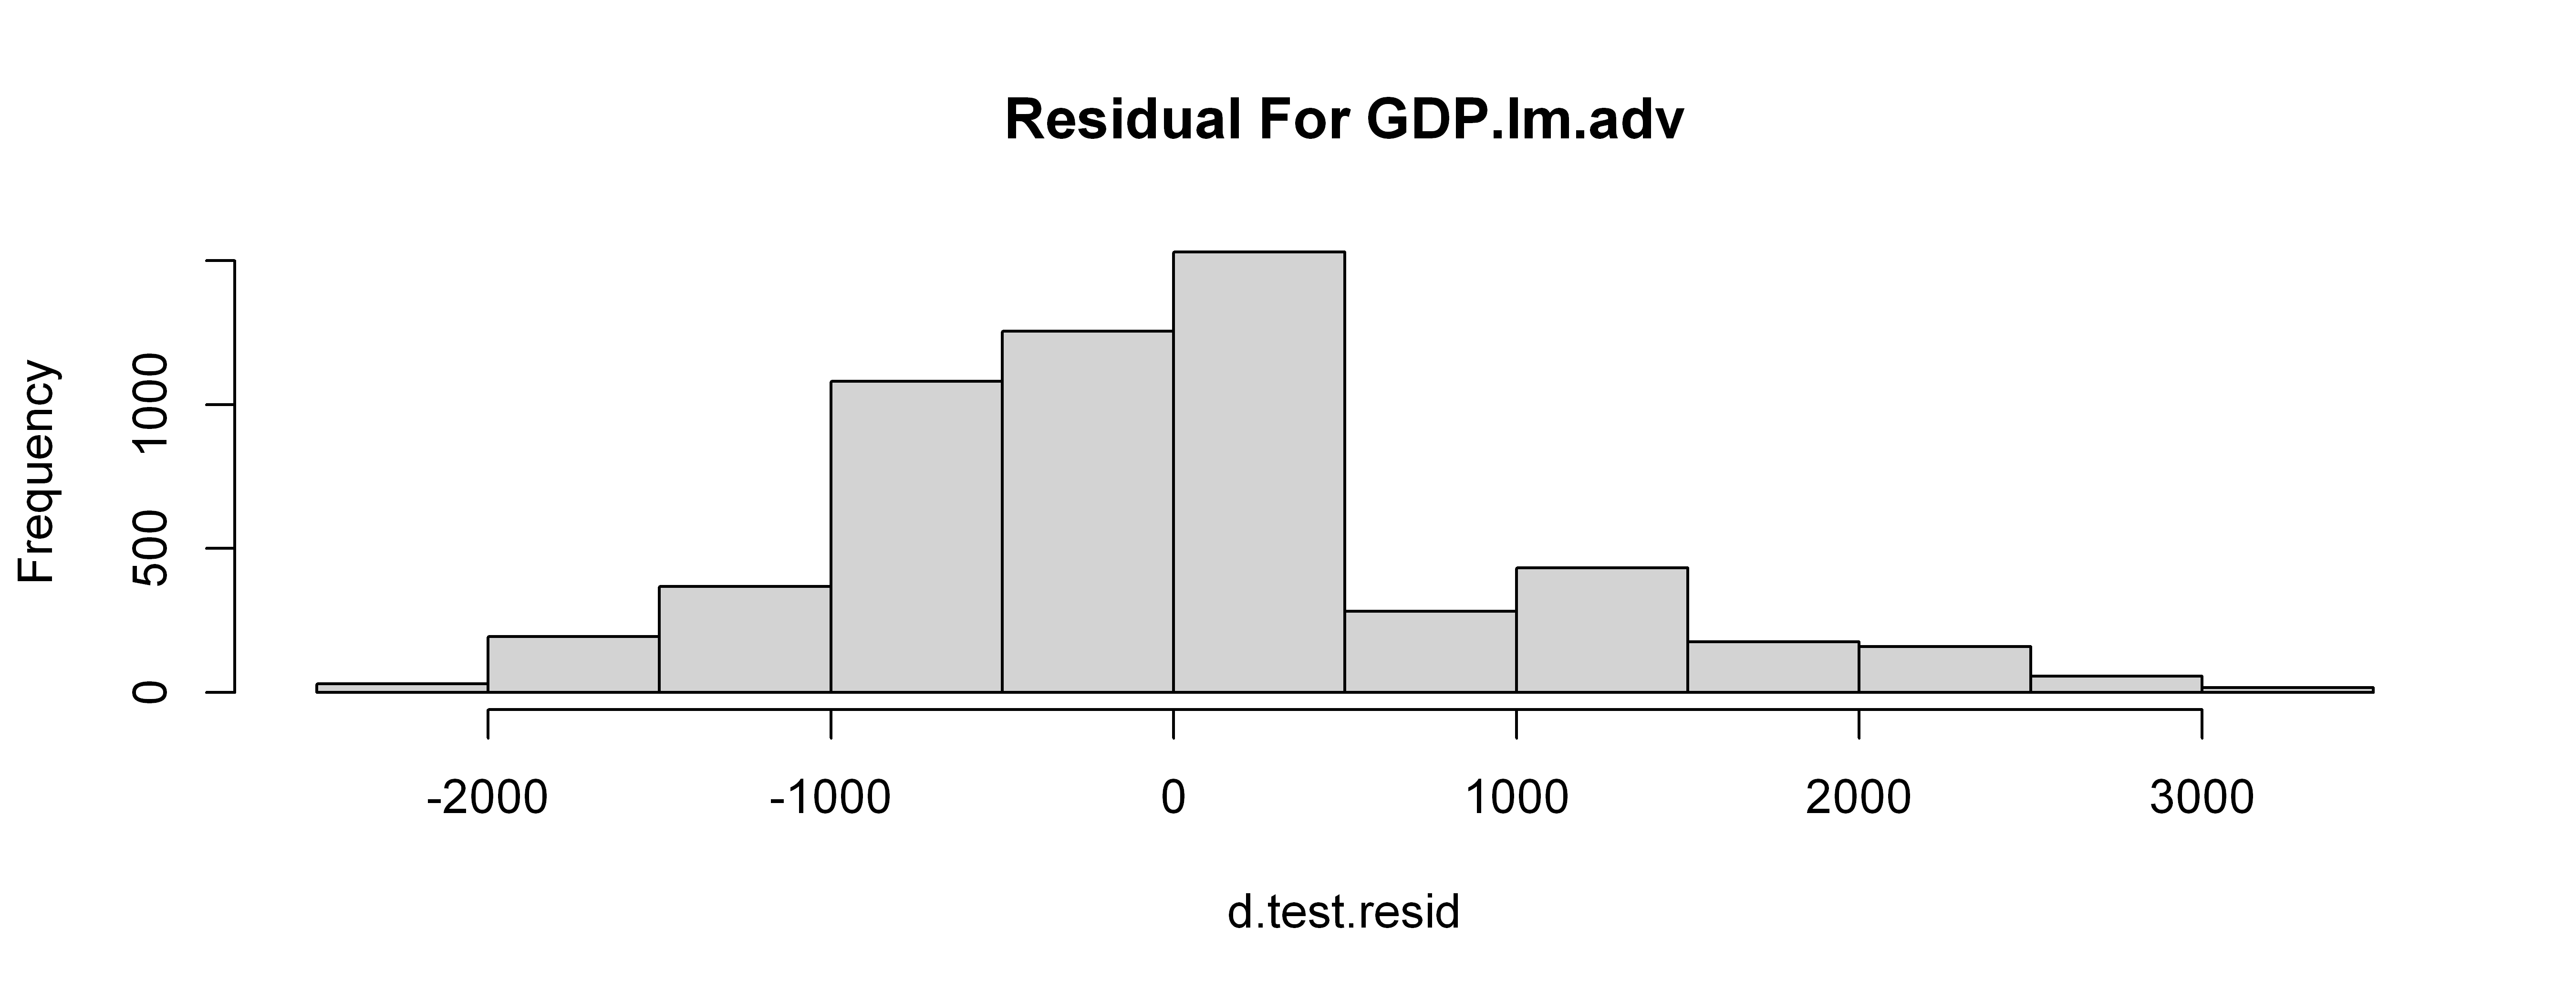

In [67]:
d.test.resid.adv = (df.test$GDP - predict(list.fit.reg.adv, newdata = df.test))
hist(d.test.resid, main=paste("Residual For", str.symbol, sep=" "))
sd.fit.gdp.lm.adv = sd(d.test.resid)


In [68]:
list.fit.reg.adv$finalModel


Call:
lm(formula = .outcome ~ ., data = dat)

Coefficients:
      (Intercept)             INDPRO                PCE              RSAFS  
          7403.77              32.51            6515.51            -312.23  
         ALTSALES  MSPUS.times.HOUST  
            33.17              47.45  


Document the residual as well

In [69]:
str.symbol.res <- "GDP.lm.adv.res"
df.data[str.symbol.res] <- df.data$GDP - df.data[str.symbol]

# Add the GDP linear model prediction residual to the symbols table
df.symbols <-
  rbind(
    df.symbols,
    data.frame(
      string.symbol = str.symbol.res,
      string.source = "Predict Resid.",
      string.description = "Residual for \nGDP given INDPRO,\nPCE, and RSALESAGG",
      string.label.y = df.symbols[df.symbols$string.symbol==str.symbol,"string.label.y"],
      float.expense.ratio = -1.00,
      Max030 = FALSE,
      Max180 = FALSE,
      date.series.start = dt.start.prediction,
      date.series.end = as.Date(Sys.Date())
    )
  )


Plot the residual  GDP to the linear fit prediction. 

The residuals decrease quite a bit during the Covid numbers, at least as of Jun 2020. Probably indicates uncertainty in the numbers.

Warning message:
"Removed 1 rows containing missing values (geom_hline)."
Warning message:
"Removed 1 rows containing missing values (geom_hline)."


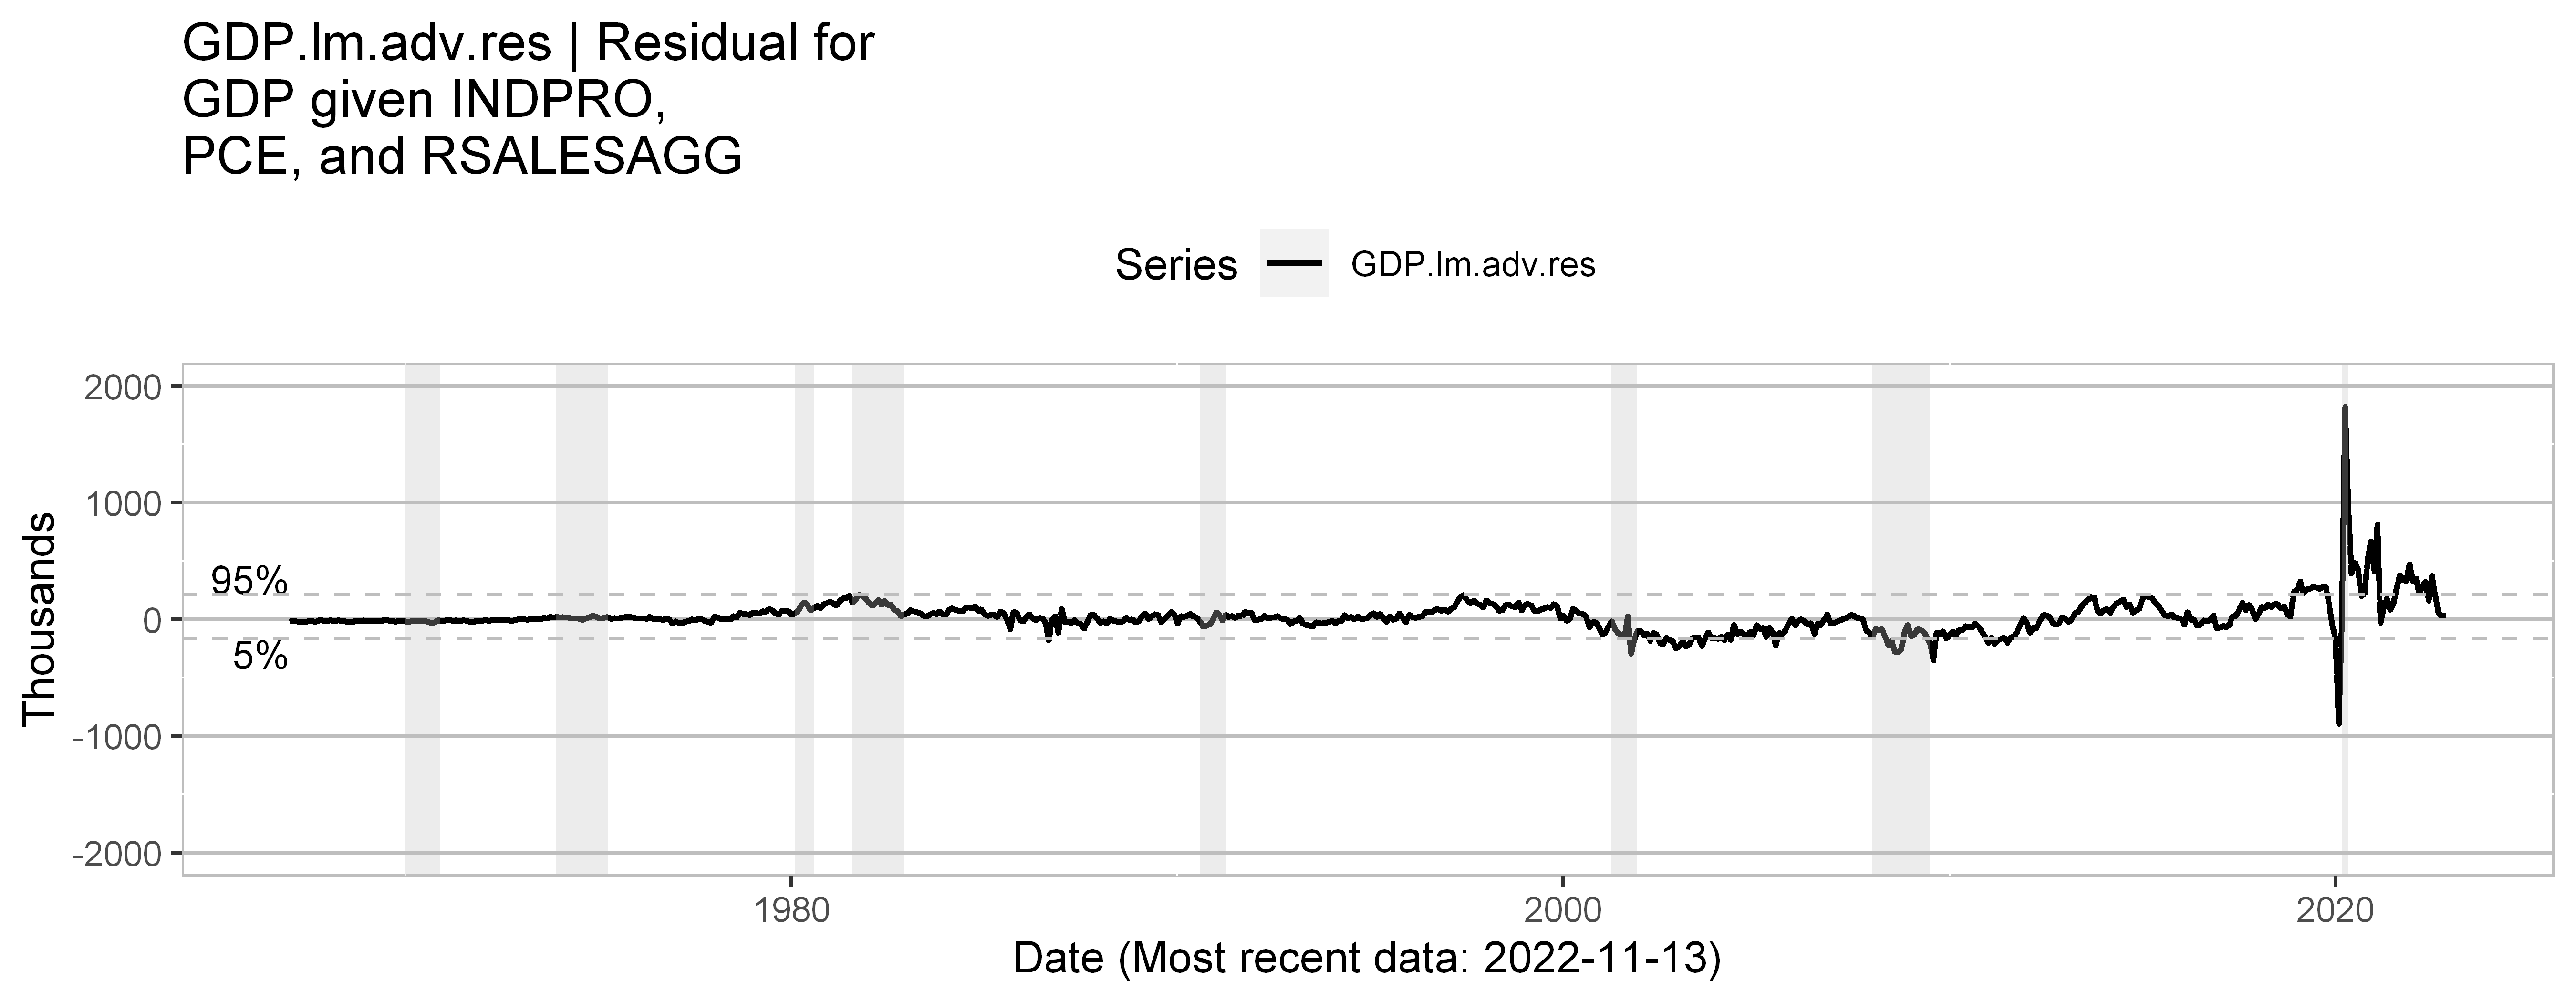

In [70]:
datay <- str.symbol.res
ylim <- c(-2000, 2000)
myPlot <- plotSingle(
  dfRecession,
  df.data,
  "date",
  datay,
  getPlotTitle(df.symbols, datay),
  "Date",
  getPlotYLabel(df.symbols, datay),
  c(as.Date("1jan1967", "%d%b%Y"), Sys.Date()),
  ylim,
  b.legend = TRUE,
  b.percentile = TRUE,
  b.long.legend = FALSE
)

myPlot <- myPlot + geom_hline(yintercept=(6*sd.fit.gdp.lm.adv), color = "red", linetype="dashed")
myPlot <- myPlot + geom_hline(yintercept=(-6*sd.fit.gdp.lm.adv), color = "red", linetype="dashed")

print(myPlot)


Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



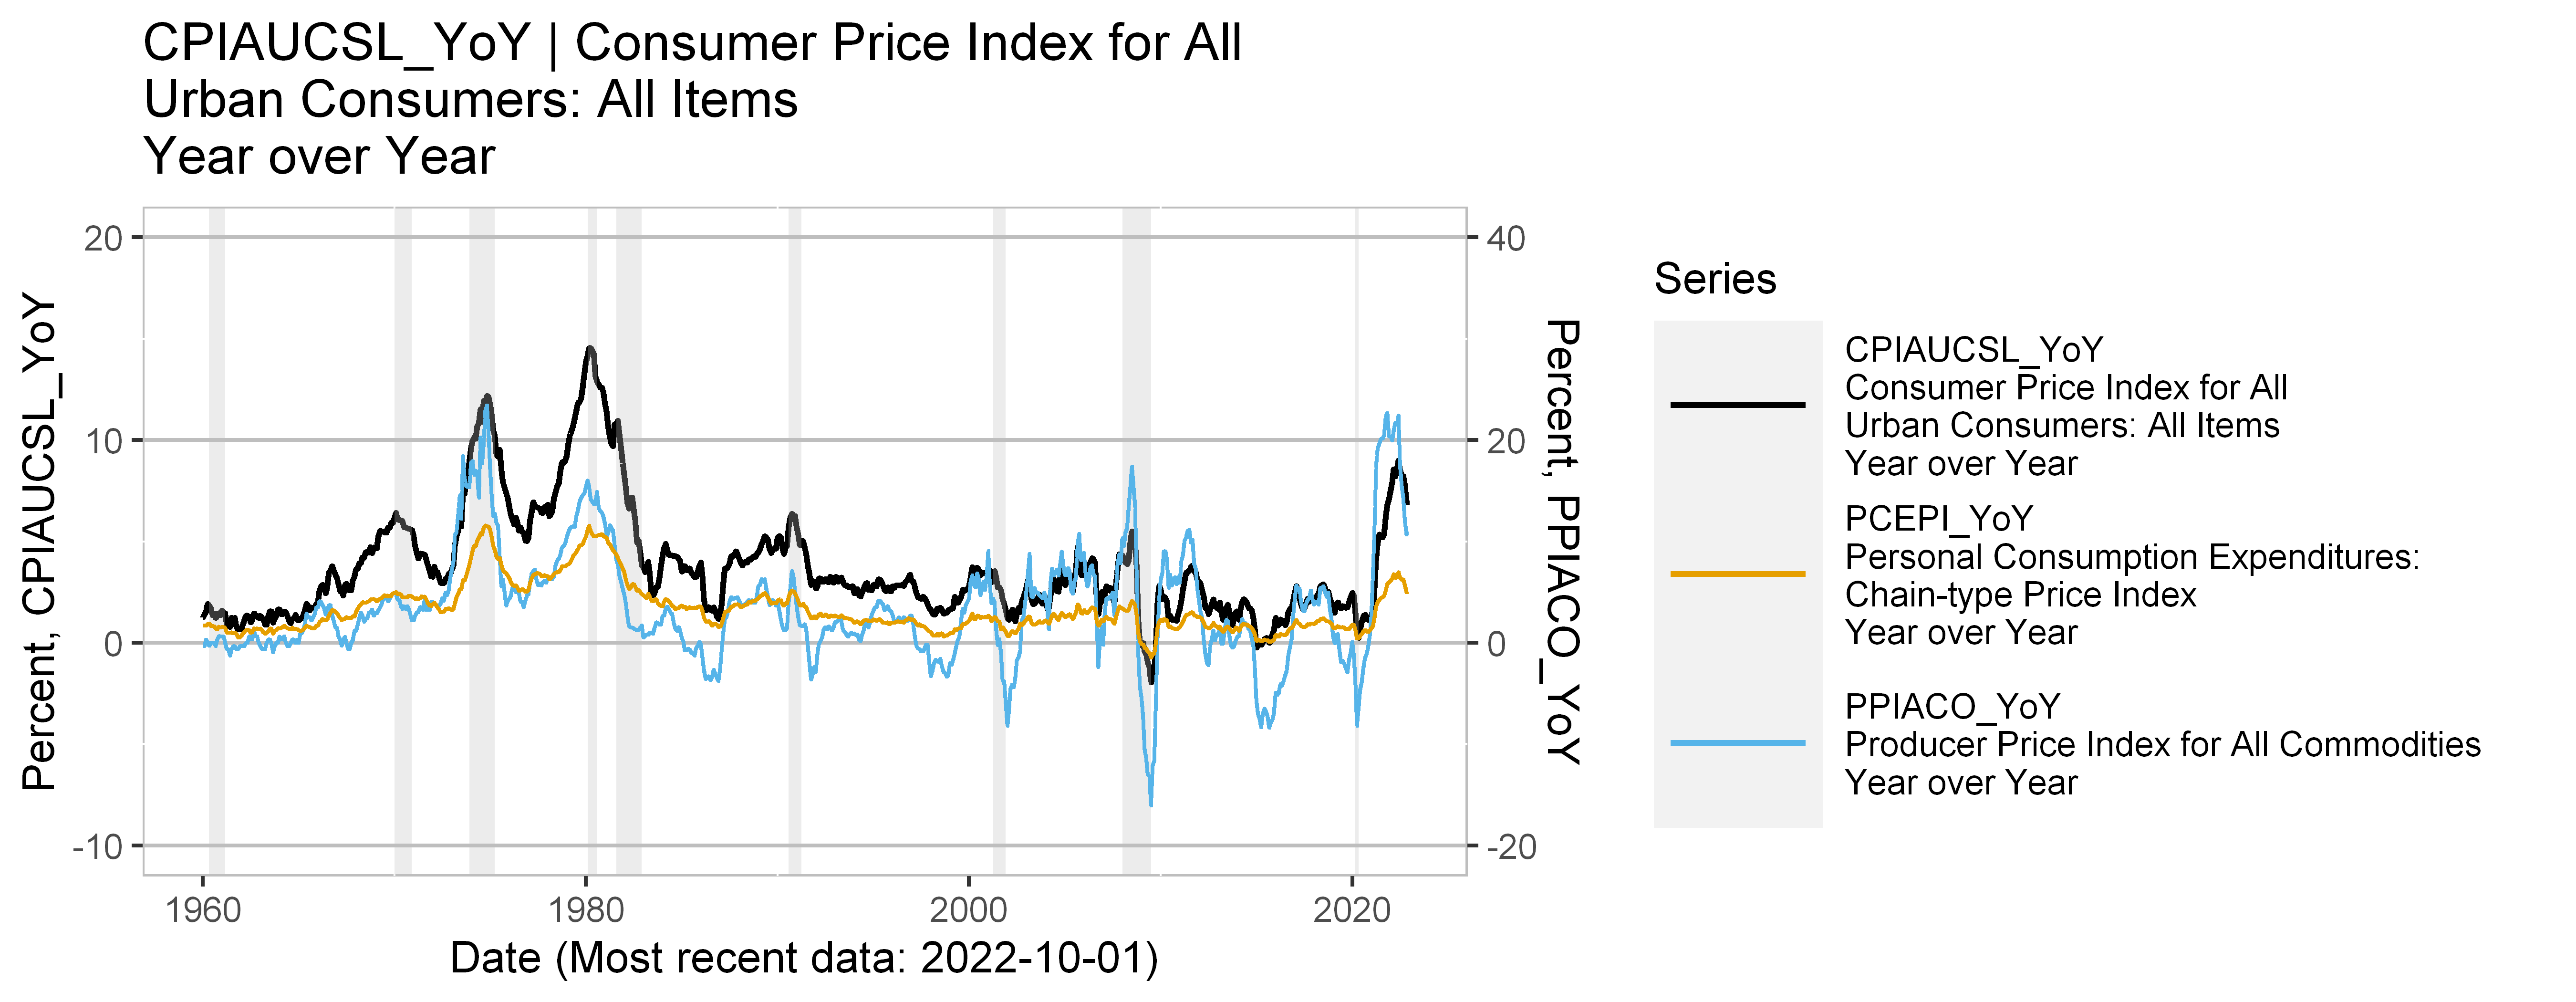

In [71]:
datay <- "CPIAUCSL_YoY"
datay.aux <- "PPIACO_YoY"
datay.aux.scale <- 0.5
datay.aux.1 <- "PCEPI_YoY"

ylim <- c(-10, 20)
dtStart = as.Date('1960-01-01')
myPlot <-
  plotSingle(
    dfRecession,
    df.data,
    "date",
    datay,
    getPlotTitle(df.symbols, datay),
    "Date",
    paste(getPlotYLabel(df.symbols, datay), ", ", datay, sep=""),
    c(dtStart, Sys.Date()),
    ylim,
    b.legend = TRUE,
    b.long.legend = TRUE
  )
myPlot <- myPlot + geom_line(
  data = df.data,
  aes_string(
    x = "date",
    y = df.data[[datay.aux]] * datay.aux.scale,
    colour = shQuote(getPlotTitle(df.symbols, datay.aux, str.sep = "\n"))
  ),
  na.rm = TRUE
)

myPlot <- myPlot + geom_line(
  data = df.data,
  aes_string(
    x = "date",
    y = df.data[[datay.aux.1]] * datay.aux.scale,
    colour = shQuote(getPlotTitle(df.symbols, datay.aux.1, str.sep = "\n"))
  ),
  na.rm = TRUE
)


myPlot + scale_y_continuous(sec.axis = sec_axis(
  ~ . * (1 / datay.aux.scale),
  name = paste(getPlotYLabel(df.symbols, datay.aux), ", ", datay.aux, sep = "")
), limits = ylim)
